# Importy bibliotek

In [10]:
import os
import sys
import time # Jeśli używasz time.sleep

print(f"--- Sprawdzanie XLA_FLAGS przed importem JAX ---")
xla_flags_value = os.environ.get('XLA_FLAGS')
print(f"Wartość XLA_FLAGS w Pythonie: {xla_flags_value}")
# Sprawdź, czy flaga jest obecna
if not xla_flags_value or "--xla_force_host_platform_device_count=12" not in xla_flags_value:
    print("!!! UWAGA: XLA_FLAGS nie ustawione poprawnie przed importem JAX!!!", file=sys.stderr)
else:
    print("XLA_FLAGS wydaje się ustawione poprawnie.")
print(f"--- Kontynuacja importu JAX ---")

# Teraz importuj JAX
import jax
import jax.numpy as jnp
import numpy as np # Jeśli używasz numpy

# --- Reszta twojego kodu ---
print(f"Liczba urządzeń JAX: {jax.device_count()}")

--- Sprawdzanie XLA_FLAGS przed importem JAX ---
Wartość XLA_FLAGS w Pythonie: None
--- Kontynuacja importu JAX ---
Liczba urządzeń JAX: 1


!!! UWAGA: XLA_FLAGS nie ustawione poprawnie przed importem JAX!!!


In [2]:
# Standardowe biblioteki
import os

import copy
import gc
import logging
import operator
import pprint
import sys
import time
import traceback
import warnings
from collections import OrderedDict
from functools import partial, reduce  # Połączone importy z functools
from itertools import combinations, product
from typing import Any, Dict, List, Optional, OrderedDict as OrderedDictType, Tuple, Union # Ujednolicony import typing

# Biblioteki zewnętrzne (third-party)
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import patsy
import plotly.express as px
import plotly.io as pio
import pymc as pm
import pytensor
import pytensor.tensor as pt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import umap

from jax import random
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO # Posortowane nazwy
from numpyro.infer.autoguide import AutoNormal
from patsy import bs # Dodano import z patsy tutaj
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Ujednolicony import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler # Dodano LabelEncoder, StandardScaler
from statsmodels.regression.mixed_linear_model import MixedLMResults
from statsmodels.tools.sm_exceptions import ConvergenceWarning, PerfectSeparationError # Posortowane nazwy

print(f"Python widzi {os.cpu_count()} logicznych rdzeni CPU.")
print(f"JAX widzi {jax.device_count()} logicznych rdzeni CPU.")


INFO:2025-05-03 15:46:45,775:jax._src.xla_bridge:867: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
2025-05-03 15:46:45,775 - INFO - Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Python widzi 12 logicznych rdzeni CPU.
JAX widzi 1 logicznych rdzeni CPU.


# Tworzenie danych

## Parametry dla agumentacji danych

In [3]:
CONFIG = {
    # Parametry symulacji
    'num_subjects': 12,                # Liczba obiektów badawczych (subject/podmiot/warunek)
    'num_samples_per_condition': 250,  # Liczba losowych próbek/czasu na dany podmiot/warunek
    'cycle_range_max': 1000,           # Górny zakres dla losowania numerów próbek
    'seed': 123,                       # Ziarno losowości dla powtarzalności

    # Definicja siatki punktów pomiarowych (podmitów)
    'conditions_grid': {
        'Alpha': [15.0, 18, 20, 22.5, 25, 26.5, 28, 30.0, 32, 33.5, 35, 37, 40, 45.0],            # poziomy Alpha        
        'Beta':  [-1.5, -1.0, -0.75, -0.5, -0.35, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0, 1.125, 2],     # poziomy Beta
        'Gamma': [0.25, 0.75, 1.0, 1.5, 2, 2.25, 3.0, 3.5, 4, 5.0, 5.25, 5.5, 2*np.pi-0.28]      # poziomy Gamma (w radianach)
    },
    #### Wartości do walidacji modelu
    #### Alpha 22.5, 26.5, 33.5, 37, Beta -0.75, -0.35, 0.75, 1.125, Gamma 0.75, 2, 3.5, 5.25 <--- Scenariusz 1.
    #### Dodanie trzech nowych subjectów.                    <--- Scenariusz 2.

    # Parametry efektów stałych
    'fixed_intercept': 80.0,          # Wartość oczekiwana zmiennej zależnej "Reaction" na początku
    'mean_omega_slope': -1.0 / 50.0,  # Stałe średnie nachylenie (slope) odpowiedzi "Reaction" względem SampleNumber
    'beta_midpoint': 0.0,             # Punkt środkowy dla funkcji sigmoidalnej 
    'alpha_input_min': 10.0,          # Minimalna wartość wejściowa dla Alpha

    # Parametry struktury błędu resztkowego
    'error_type': 'homoscedastic', # Heteroskedastyczność [wariancja błędu losowego (reszty) jest stała dla wszystkich obserwacji (nie zależy od wartości predyktorów ani efektów losowych)]
    'error_std_dev': 0.25,         # Wartość efektu

    # Parametry efektów losowych
    'mean_random_effects': {
        'slope_cycle': 0.0,    # Nie zmieniać
        'alpha_center': 30.0,  # Wartość parametru centrum dla efektu Alpha (parabola)
        'beta_steepness': 2.5, # Wartość parametru "stromizny" dla sigmoidalnego efektu Beta
        'alpha_range': 20.0,   # Wartość  dla efektu Alpha
        'beta_max': 15.0,      # Maksimum zakresu dla sigmoidalnego efektu Beta
        'gamma_amp': 10.0      # Średnia amplituda dla sinusa efektu Gamma
    },
    
    # Odchylenia stanadarodwe dla każdego z 6 parametrów losowych
    'std_dev_random_effects': {
        'slope_cycle': 0.006,
        'alpha_center': 2.25,
        'beta_steepness': 0.42,
        'alpha_range': 0.6,
        'beta_max': 0.55,
        'gamma_amp': 0.8
    },
    
    # Macierz Korelacji parametrów 
    # Macierz korelacji między sześcioma efektami losowymi. Wartości poza przekątną określają stopień liniowej zależności między losowymi odchyleniami parametrów dla danego obiektu.
    # Ta macierz, w połączeniu ze średnimi i odchyleniami standardowymi, pozwala na wygenerowanie skorelowanych efektów losowych dla każdego obiektu. 
    # Na przykład, korelacja 0.20 między alpha_center a beta_steepness oznacza, że obiekty z wyższym alpha_center mają tendencję do posiadania również nieco wyższego beta_steepness.
    'correlation_matrix_6x6': np.array([
        [1.00 , -0.10, 0.10, 0.10, 0.05, 0.0],
        [-0.10, 1.00,  0.20, 0.15, 0.00, 0.0],
        [0.10 , 0.20,  1.00, 0.00, 0.10, 0.0],
        [0.10 , 0.15,  0.00, 1.00, 0.20, 0.0],
        [0.05 , 0.00,  0.10, 0.20, 1.00, 0.0],
        [0.00 , 0.00,  0.00, 0.10, 0.10, 1.00]
    ]),
    # Ograniczenia, dopuszczalne zakresy wartości dla wygenerowanych parametrów losowych dla poszczególnych obiektów.
        'constraints': {
        'alpha_center': {'min': 11.0, 'max': 45.0},
        'beta_steepness': {'min': 0.1},
        'alpha_range': {'min': 1.0},
        'beta_max': {'min': 1.0},
        'gamma_amp': {'min': 0.0}
    }
}

##  Generowanie danych

In [4]:
def calculate_covariance_matrix(stds: Dict[str, float], corr_matrix: np.ndarray) -> Tuple[np.ndarray, List[str]]:
    """
    Oblicza macierz kowariancji na podstawie odchyleń standardowych i macierzy korelacji.

    Args:
        stds (Dict[str, float]): Słownik odchyleń standardowych efektów losowych.
        corr_matrix (np.ndarray): Macierz korelacji.

    Returns:
        Tuple[np.ndarray, List[str]]: Macierz kowariancji i lista nazw efektów w kolejności.
    """
    param_names = list(stds.keys())
    std_devs_array = np.array([stds[name] for name in param_names])

    # Zapewnienie symetrii macierzy korelacji
    corr_matrix = (corr_matrix + corr_matrix.T) / 2
    np.fill_diagonal(corr_matrix, 1.0)

    if corr_matrix.shape[0] != len(std_devs_array):
        raise ValueError("Wymiary macierzy korelacji i liczby odchyleń standardowych nie zgadzają się.")

    covariance_matrix = np.outer(std_devs_array, std_devs_array) * corr_matrix

    # Sprawdzenie dodatniej półokreśloności
    eigenvalues = np.linalg.eigvalsh(covariance_matrix)
    if not np.all(eigenvalues >= -1e-8): # Tolerancja dla błędów numerycznych
        print(f"OSTRZEŻENIE: Macierz kowariancji {covariance_matrix.shape} może nie być dodatnio półokreślona!")
        print(f"Wartości własne: {eigenvalues}") # Odkomentuj dla debugowania
    
    return covariance_matrix, param_names

def generate_subject_specific_effects(means: Dict[str, float],
                                      cov_matrix: np.ndarray,
                                      param_names: List[str],
                                      num_subjects: int) -> pd.DataFrame:
    """
    Generuje skorelowane efekty losowe specyficzne dla każdego subjectu, z uwwzględnieniem średniej populacji
    macierzy kowiariancji dla efektu wielowymiarowego.

    Args:
        means (Dict[str, float]): Słownik średnich wartości efektów losowych.
        cov_matrix (np.ndarray): Macierz kowariancji.
        param_names (List[str]): Lista nazw parametrów (w kolejności zgodnej z means i cov_matrix).
        num_subjects (int): Liczba podmiotów.

    Returns:
        pd.DataFrame: Ramka danych z efektami losowymi dla każdego subjectu.
                      Kolumny: 'Subject', nazwy parametrów losowych.
    """
    means_array = np.array([means[name] for name in param_names])
    
    # Losowanie z wielowymiarowego rozkładu normalnego
    generated_effects = np.random.multivariate_normal(means_array, cov_matrix, num_subjects)
    
    # Tworzenie DataFrame
    effects_df = pd.DataFrame(generated_effects, columns=param_names)
    effects_df['Subject'] = np.arange(num_subjects)
    
    # Zmiana kolejności kolumn dla czytelności
    effects_df = effects_df[['Subject'] + param_names]
    
    return effects_df

def apply_constraints(effects_df: pd.DataFrame, constraints: Dict) -> pd.DataFrame:
    """
    Nakłada ograniczenia (min/max) na wygenerowane parametry losowe.

    Args:
        effects_df (pd.DataFrame): Ramka danych z parametrami losowymi podmiotów.
        constraints (Dict): Słownik ograniczeń, np. {'param_name': {'min': v1, 'max': v2}}.

    Returns:
        pd.DataFrame: Ramka danych z parametrami po nałożeniu ograniczeń.
    """
    constrained_df = effects_df.copy()
    for param_name, constraint_rules in constraints.items():
        if param_name in constrained_df.columns:
            if 'min' in constraint_rules and 'max' in constraint_rules:
                constrained_df[param_name] = np.clip(constrained_df[param_name], 
                                                     constraint_rules['min'], 
                                                     constraint_rules['max'])
            elif 'min' in constraint_rules:
                 constrained_df[param_name] = np.maximum(constrained_df[param_name], constraint_rules['min'])
            elif 'max' in constraint_rules:
                 constrained_df[param_name] = np.minimum(constrained_df[param_name], constraint_rules['max'])
                 
    return constrained_df

def map_effects_to_observations(subject_effects_df: pd.DataFrame, 
                                subject_ids_per_obs: np.ndarray,
                                param_names: List[str]) -> Dict[str, np.ndarray]:
    """
    Mapuje parametry specyficzne dla podmiotu na wszystkie obserwacje.

    Args:
        subject_effects_df (pd.DataFrame): Ramka danych z (ograniczonymi) parametrami podmiotów.
        subject_ids_per_obs (np.ndarray): Tablica ID podmiotu dla każdej obserwacji.
        param_names (List[str]): Lista nazw parametrów do zmapowania.

    Returns:
        Dict[str, np.ndarray]: Słownik, gdzie klucze to nazwy parametrów, 
                               a wartości to tablice NumPy z wartością parametru dla każdej obserwacji.
    """
    mapped_effects = {}
    subject_effects_df = subject_effects_df.sort_values('Subject').reset_index(drop=True) 
    
    for param_name in param_names:
        if param_name in subject_effects_df.columns:
             mapped_effects[param_name + '_subj'] = subject_effects_df[param_name].iloc[subject_ids_per_obs].values
             
    return mapped_effects

def calculate_effect_alpha(alpha_input: np.ndarray, 
                           alpha_center_subj: np.ndarray, 
                           alpha_range_subj: np.ndarray,
                           alpha_input_min: float) -> np.ndarray:
    """
    Oblicza efekt Alpha (parabola) dla każdej obserwacji.
    f_alpha: Parabola z indywidualnym centrum, zakresem i stała k, ograniczona >= 0.
             Współczynnik k jest obliczany tak, aby parabola miała wartość 0 dla alpha_input_min.

    Args:
        alpha_input (np.ndarray): Wartości wejściowe Alpha.
        alpha_center_subj (np.ndarray): Centrum paraboli specyficzne dla podmiotu.
        alpha_range_subj (np.ndarray): Zakres (wysokość) paraboli specyficzny dla podmiotu.
        alpha_input_min (float): Minimalna wartość wejściowa Alpha (punkt, gdzie parabola ma wartość 0).

    Returns:
        np.ndarray: Wartość efektu Alpha dla każdej obserwacji.
    """
    denominator = (alpha_center_subj - alpha_input_min)**2
    epsilon = 1e-9 
    alpha_k_subj = alpha_range_subj / (denominator + epsilon)
    
    # Obliczanie surowego efektu paraboli
    raw_effect_alpha = -alpha_k_subj * (alpha_input - alpha_center_subj)**2 + alpha_range_subj
    
    # Ograniczenie efektu do wartości nieujemnych
    effect_alpha = np.maximum(0.0, raw_effect_alpha)
    
    return effect_alpha

def calculate_effect_beta(beta_input: np.ndarray, 
                          beta_steepness_subj: np.ndarray, 
                          beta_max_subj: np.ndarray,
                          beta_midpoint: float) -> np.ndarray:
    """
    Oblicza efekt Beta (sigmoida) dla każdej obserwacji.
    f_beta: Sigmoida (funkcja logistyczna) z indywidualną stromością i SKALĄ (max).

    Args:
        beta_input (np.ndarray): Wartości wejściowe Beta.
        beta_steepness_subj (np.ndarray): Stromość sigmoidy specyficzna dla podmiotu.
        beta_max_subj (np.ndarray): Maksymalna wartość (nasycenie) sigmoidy specyficzna dla podmiotu.
        beta_midpoint (float): Punkt środkowy sigmoidy (stały).

    Returns:
        np.ndarray: Wartość efektu Beta dla każdej obserwacji.
    """
    effect_beta = beta_max_subj / (1 + np.exp(-beta_steepness_subj * (beta_input - beta_midpoint)))
    return effect_beta

def calculate_effect_gamma(gamma_input: np.ndarray, gamma_amp_subj: np.ndarray) -> np.ndarray:
    """
    Oblicza efekt Gamma (sinusoida) dla każdej obserwacji.
    f_gamma: Sinusoida z indywidualną AMPLITUDĄ.

    Args:
        gamma_input (np.ndarray): Wartości wejściowe Gamma (w radianach).
        gamma_amp_subj (np.ndarray): Amplituda sinusoidy specyficzna dla podmiotu.

    Returns:
        np.ndarray: Wartość efektu Gamma dla każdej obserwacji.
    """
    effect_gamma = gamma_amp_subj * np.sin(gamma_input)
    return effect_gamma

def calculate_effect_omega(cycles: np.ndarray, 
                           mean_omega_slope: float, 
                           slope_cycle_subj: np.ndarray) -> np.ndarray:
    """
    Oblicza efekt Omega (liniowy efekt czasu (SampleNumber/cycles)) dla każdej obserwacji.
    f_omega: Liniowy trend z indywidualnym nachyleniem (średnia + odchylenie losowe), 
             OGRANICZONYM do wartości niepozytywnych (<= 0).

    Args:
        cycles (np.ndarray): Numer cyklu dla każdej obserwacji.
        mean_omega_slope (float): Średnie (stałe) nachylenie trendu.
        slope_cycle_subj (np.ndarray): Odchylenie nachylenia od średniej, specyficzne dla podmiotu.

    Returns:
        np.ndarray: Wartość efektu Omega dla każdej obserwacji.
    """
    # Całkowite nachylenie specyficzne dla podmiotu dla danej obserwacji
    total_omega_slope_subj = mean_omega_slope + slope_cycle_subj 
    
    # Ograniczenie nachylenia do wartości niepozytywnych
    constrained_omega_slope_subj = np.minimum(total_omega_slope_subj, 0.0)
    
    # Obliczenie efektu liniowego
    effect_omega = constrained_omega_slope_subj * cycles
    return effect_omega

def generate_error_term(config: Dict, 
                        total_obs: int, 
                        subject_ids: np.ndarray, 
                        cycles: np.ndarray,
                        num_subjects: int,
                        num_cycles: int,
                        predicted_values_no_error: Optional[np.ndarray] = None) -> np.ndarray:
    """
    Generuje błąd homoskedastyczny (o stałej wariancji) z rozkładu normalnegodla dla każdej obserwacji.

    Args:
        config (Dict): Słownik konfiguracyjny.
        total_obs (int): Całkowita liczba obserwacji.
        subject_ids (np.ndarray): ID podmiotu dla każdej obserwacji.
        cycles (np.ndarray): Numer cyklu dla każdej obserwacji.
        num_subjects (int): Liczba podmiotów.
        num_cycles (int): Liczba cykli na podmiot.
        predicted_values_no_error (Optional[np.ndarray]): Przewidywane wartości Y
                                                        (bez błędu), potrzebne dla 'hetero_pred'.

    Returns:
        np.ndarray: Wygenerowany wektor błędów.
    """
    error_type = config.get('error_type', 'homoscedastic')
    base_std_dev = config['error_std_dev']
    
    if error_type == 'homoscedastic':
        # Błąd o stałej wariancji (standardowy)
        errors = np.random.normal(0, base_std_dev, total_obs)                  
    else:
        raise ValueError(f"Nieznany typ błędu: {error_type}")
        
    return errors

##########################################
# Główny Proces Generowania Danych 
def generate_nested_lmm_data(config: Dict) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Generuje dane symulacyjne dla struktury zagnieżdżonej (nested):
    Każdy Podmiot przechodzi przez wszystkie Warunki (kombinacje Alpha, Beta, Gamma).
    Dla każdej pary Podmiot-Warunek generowane są dane w losowo próbkowanych
    punktach czasowych (SampleNumber/Cycle).

    Args:
        config (Dict): Słownik konfiguracyjny symulacji.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]:
            - Główna ramka danych z obserwacjami.
            - Ramka danych z parametrami specyficznymi dla podmiotów.
    """
    np.random.seed(config['seed'])

    # Parametry symulacji
    num_subjects = config['num_subjects']
    num_samples = config['num_samples_per_condition']
    cycle_range_max = config['cycle_range_max']

    # Generowanie listy warunków
    alpha_levels = config['conditions_grid']['Alpha']
    beta_levels = config['conditions_grid']['Beta']
    gamma_levels = config['conditions_grid']['Gamma']
    conditions_list = list(product(alpha_levels, beta_levels, gamma_levels))
    num_conditions = len(conditions_list)
    #conditions_map = {c_idx: cond for c_idx, cond in enumerate(conditions_list)} 

    total_obs = num_subjects * num_conditions * num_samples

    print(f"Generowanie danych dla {num_subjects} podmiotów.")
    print(f"Liczba warunków na podmiot: {num_conditions}")
    print(f"Liczba losowych próbek na podmiot-warunek: {num_samples}")
    print(f"Zakres losowania numerów próbek: 1 - {cycle_range_max}")
    print(f"Całkowita liczba obserwacji: {total_obs}")

    # Generowanie parametrów losowych dla Subjectów 
    cov_matrix, random_param_names = calculate_covariance_matrix(
        config['std_dev_random_effects'],
        config['correlation_matrix_6x6']
    )
    subject_params_df_raw = generate_subject_specific_effects(
        config['mean_random_effects'],
        cov_matrix,
        random_param_names,
        num_subjects
    )
    subject_params_df = apply_constraints( 
        subject_params_df_raw,
        config['constraints']
    )

    subject_ids_list = []
    condition_ids_list = []
    alpha_conditions_list = []
    beta_conditions_list = []
    gamma_conditions_list = []
    sample_numbers_list = []

    # Zagnieżdżone pętle do stworzenia struktury Subject-Condition-SampleNumber
    for s_idx in range(num_subjects):
        for c_idx, (alpha_c, beta_c, gamma_c) in enumerate(conditions_list):
            # Losuj 'num_samples' unikalnych numerów próbek dla tej kombinacji S-C
            current_samples = np.random.choice(
                range(1, cycle_range_max + 1),
                size=num_samples,
                replace=False
            )
            sample_numbers_list.append(current_samples)

            # Dodaj ID podmiotu i warunku
            subject_ids_list.append(np.full(num_samples, s_idx, dtype=int))
            condition_ids_list.append(np.full(num_samples, c_idx, dtype=int))

            # Dodaj stałe wartości warunku
            alpha_conditions_list.append(np.full(num_samples, alpha_c))
            beta_conditions_list.append(np.full(num_samples, beta_c))
            gamma_conditions_list.append(np.full(num_samples, gamma_c))

    # Konwersja list do tablic NumPy o rozmiarze total_obs
    subjects_per_obs = np.concatenate(subject_ids_list)
    condition_ids_per_obs = np.concatenate(condition_ids_list)
    alpha_cond_per_obs = np.concatenate(alpha_conditions_list)
    beta_cond_per_obs = np.concatenate(beta_conditions_list)
    gamma_cond_per_obs = np.concatenate(gamma_conditions_list)
    sample_numbers_per_obs = np.concatenate(sample_numbers_list) # Wylosowane numery próbek

    # Mapowanie Parametrów Losowych Podmiotów na Obserwacje 
    effects_per_obs = map_effects_to_observations(
        subject_params_df, # Przekazujemy DataFrame z parametrami wszystkich podmiotów
        subjects_per_obs,  # Tablica ID podmiotu dla każdej obserwacji
        random_param_names # Lista nazw parametrów do zmapowania
    )

    # Obliczanie Efektów dla Wszystkich Obserwacji 
    effect_alpha = calculate_effect_alpha(
        alpha_cond_per_obs, # Stałe wejście Alpha dla warunku
        effects_per_obs['alpha_center_subj'], # Parametr losowy podmiotu
        effects_per_obs['alpha_range_subj'],  # Parametr losowy podmiotu
        config['alpha_input_min']
    )
    effect_beta = calculate_effect_beta(
        beta_cond_per_obs,  # Stałe wejście Beta dla warunku
        effects_per_obs['beta_steepness_subj'], # Parametr losowy podmiotu
        effects_per_obs['beta_max_subj'],       # Parametr losowy podmiotu
        config['beta_midpoint']
    )
    effect_gamma = calculate_effect_gamma(
        gamma_cond_per_obs, # Stałe wejście Gamma dla warunku
        effects_per_obs['gamma_amp_subj'] # Parametr losowy podmiotu
    )
    effect_omega = calculate_effect_omega(
        sample_numbers_per_obs, # Używamy LOSOWYCH numerów próbek
        config['mean_omega_slope'],
        effects_per_obs['slope_cycle_subj'] # Parametr losowy podmiotu
    )

    # Generowanie błędu
    errors = generate_error_term(
    config=config,
    total_obs=total_obs,
    subject_ids=subjects_per_obs,
    cycles=sample_numbers_per_obs,
    num_cycles=num_samples,
    num_subjects=num_subjects,
    predicted_values_no_error=None
    )

    # Obliczaniue reakcji
    Reaction = (config['fixed_intercept'] +
                effect_alpha +
                effect_beta +
                effect_gamma +
                effect_omega +
                errors)

    # Tworzenie Końcowego DataFrame 
    data = pd.DataFrame({
        'Subject': subjects_per_obs,
        'ConditionID': condition_ids_per_obs,       # Numeryczny ID warunku (0 do K-1)
        'SampleNumber': sample_numbers_per_obs,
        'Alpha_Condition': alpha_cond_per_obs,
        'Beta_Condition': beta_cond_per_obs,
        'Gamma_Condition': gamma_cond_per_obs,
        'Reaction': Reaction,
        # Opcjonalnie: obliczone efekty dla wglądu
        'Effect_Alpha': effect_alpha,
        'Effect_Beta': effect_beta,
        'Effect_Gamma': effect_gamma,
        'Effect_Omega': effect_omega,
        'Error': errors
    })
    data['Subject'] = data['Subject'].astype('category')
    data['ConditionID'] = data['ConditionID'].astype('category')
    return data, subject_params_df

# Generowanie danych w strukturze zagnieżdżonej
main_data_nested, subject_params_nested = generate_nested_lmm_data(CONFIG)


Generowanie danych dla 12 podmiotów.
Liczba warunków na podmiot: 2366
Liczba losowych próbek na podmiot-warunek: 250
Zakres losowania numerów próbek: 1 - 1000
Całkowita liczba obserwacji: 7098000


$$
\begin{aligned}
\text{Reaction}_{ijk} = \Psi_0 &+ f_{\alpha}(\text{Alpha}_j, \alpha_{\text{center},i}, \alpha_{\text{range},i}, \alpha_{\text{min}}) \\
                               &+ f_{\beta}(\text{Beta}_j, \beta_{\text{steepness},i}, \beta_{\text{max},i}, \beta_{\text{midpoint}}) \\
                               &+ f_{\gamma}(\text{Gamma}_j, \gamma_{\text{amp},i}) \\
                               &+ f_{\omega}(\text{SampleNumber}_k, \omega_{\text{slope,mean}}, \omega_{\text{slope},i}) \\
                               &+ \epsilon_{ijk}
\end{aligned}
$$

$$
\text{gdzie:}
$$

$$
\begin{aligned}
i &: \text{indeks podmiotu } (1, \dots, N_{\text{subjects}}) \\
j &: \text{indeks warunku (kombinacja } \alpha, \beta, \gamma) \quad (1, \dots, N_{\text{conditions}}) \\
k &: \text{indeks próbki/pomiaru w czasie w ramach podmiotu } i \text{ i warunku } j \quad (1, \dots, N_{\text{samples}}) \\
\Psi_0 &: \text{stały wyraz wolny (fixed\_intercept)} \\
\alpha_{\text{min}} &: \text{stała minimalna wartość Alpha (alpha\_input\_min)} \\
\beta_{\text{midpoint}} &: \text{stały punkt środkowy Beta (beta\_midpoint)} \\
\omega_{\text{slope,mean}} &: \text{stałe średnie nachylenie Omega (mean\_omega\_slope)}
\end{aligned}
$$

$$
\text{Funkcje efektów:}
$$

$$
\begin{aligned}
f_{\alpha}(x, \text{center}_i, \text{range}_i, \text{min\_val}) &= \max\left(0, -k_i (x - \text{center}_i)^2 + \text{range}_i\right), \quad \text{gdzie } k_i = \frac{\text{range}_i}{(\text{center}_i - \text{min\_val})^2 + \delta} \\
\\
f_{\beta}(x, \text{steepness}_i, \text{max}_i, \text{midpoint}) &= \frac{\text{max}_i}{1 + \exp(-\text{steepness}_i (x - \text{midpoint}))} \\
\\
f_{\gamma}(x, \text{amp}_i) &= \text{amp}_i \sin(x) \\
\\
f_{\omega}(t, \text{slope}_{\text{mean}}, \text{slope}_{\text{dev},i}) &= \min(0, \text{slope}_{\text{mean}} + \text{slope}_{\text{dev},i}) \times t
\end{aligned}
$$

$$
(\delta \text{ to mała stała zapobiegająca dzieleniu przez zero})
$$

$$
\text{Rozkład błędu losowego:}
$$

$$
\epsilon_{ijk} \sim \mathcal{N}(0, \sigma_{\epsilon}^2) \quad (\text{gdzie } \sigma_{\epsilon} = \texttt{error\_std\_dev})
$$

$$
\text{Efekty losowe podmiotu } i:
$$

$$
\mathbf{u}_i = \begin{bmatrix} \omega_{\text{slope},i} \\ \alpha_{\text{center},i} \\ \beta_{\text{steepness},i} \\ \alpha_{\text{range},i} \\ \beta_{\text{max},i} \\ \gamma_{\text{amp},i} \end{bmatrix} \sim \mathcal{N}(\boldsymbol{\mu}_u, \boldsymbol{\Sigma}_u)
$$

$$
\text{gdzie } \boldsymbol{\mu}_u \text{ to wektor średnich (\texttt{mean\_random\_effects}), a } \boldsymbol{\Sigma}_u \text{ to macierz kowariancji}
$$
$$
\text{obliczona z odchyleń standardowych (\texttt{std\_dev\_random\_effects}) i macierzy korelacji.}
$$

### Proces Generowania Danych Symulacyjnych

Kod generuje syntetyczne dane tabelaryczne, naśladujące wyniki badań z powtarzanymi pomiarami na tych samych obiektach (`Subject`) w różnych warunkach.

#### Składowa Efektów Stałych

Podstawą jest składowa **efektów stałych**, reprezentująca średnie trendy w populacji. Pochodzi ona z parametrów konfiguracyjnych:
* `fixed_intercept`: określa średni punkt startowy dla `Reaction`.
* `mean_omega_slope`: definiuje przeciętne liniowe nachylenie `Reaction` względem czasu (`SampleNumber`).
* Parametry jak `beta_midpoint` czy `alpha_input_min`: wpływają na *średni kształt* nieliniowych zależności od warunków Beta i Alpha.

Te stałe parametry tworzą wspólną "bazę" odpowiedzi dla wszystkich obiektów.

#### Składowa Efektów Losowych

Kluczowym elementem wprowadzającym realizm i zmienność jest symulacja **efektów losowych**. Odzwierciedlają one indywidualne różnice między obiektami (`Subject`), pokazując, jak charakterystyka odpowiedzi każdego z nich odchyla się od średniej populacyjnej.

Dla każdego obiektu losowany jest unikalny zestaw sześciu parametrów (np. `slope_cycle_subj`, `alpha_center_subj`, `beta_steepness_subj`, `alpha_range_subj`, `beta_max_subj`, `gamma_amp_subj`) z wielowymiarowego rozkładu normalnego. Rozkład ten jest precyzyjnie zdefiniowany w konfiguracji przez:
* Średnie (`mean_random_effects`)
* Odchylenia standardowe (`std_dev_random_effects`)
* Macierz korelacji (`correlation_matrix_6x6`)

Co ważne, te wylosowane, **specyficzne dla obiektu parametry** bezpośrednio **modyfikują** sposób, w jaki dany obiekt reaguje na czas i warunki – np.:
* `alpha_center_subj` przesuwa optimum parabolicznego efektu Alpha dla tego obiektu.
* `beta_steepness_subj` zmienia stromość jego sigmoidalnej odpowiedzi na Beta.
* `slope_cycle_subj` koryguje jego indywidualne nachylenie trendu czasowego.

#### Obliczanie Wartości 'Reaction' dla Obserwacji

Zagnieżdżona, hierarchiczna struktura danych – gdzie liczne obserwacje (każda z własnym `SampleNumber` i przypisaną kombinacją warunków `Alpha_Condition`, `Beta_Condition`, `Gamma_Condition`) są grupowane wewnątrz każdego obiektu – pozwala na obliczenie finalnej wartości `Reaction` dla **każdej pojedynczej obserwacji** jako sumy tych wpływów.

Zgodnie z logiką kodu (funkcje `calculate_effect_*` i finalne sumowanie), wartość `Reaction` dla danego wiersza danych jest obliczana według schematu:

**`Reaction` = `fixed_intercept` + `Effect_Alpha` + `Effect_Beta` + `Effect_Gamma` + `Effect_Omega` + `Error`**

Gdzie poszczególne składowe `Effect_*` dla tego konkretnego wiersza (obserwacji) są wyliczane następująco:

* **`Effect_Alpha`**: Wynik funkcji `calculate_effect_alpha`, biorący pod uwagę wartość `Alpha_Condition` z tego wiersza oraz parametry `alpha_center_subj` i `alpha_range_subj` specyficzne dla podmiotu, do którego należy ten wiersz (oraz stały `alpha_input_min`).
* **`Effect_Beta`**: Wynik funkcji `calculate_effect_beta`, zależny od `Beta_Condition` z wiersza, parametrów `beta_steepness_subj` i `beta_max_subj` podmiotu oraz stałego `beta_midpoint`.
* **`Effect_Gamma`**: Wynik funkcji `calculate_effect_gamma`, zależny od `Gamma_Condition` z wiersza i parametru `gamma_amp_subj` podmiotu.
* **`Effect_Omega`**: Wynik funkcji `calculate_effect_omega`, zależny od `SampleNumber` z wiersza oraz **całkowitego nachylenia dla podmiotu** (obliczonego jako suma stałego `mean_omega_slope` i losowego `slope_cycle_subj` tego podmiotu).
* **`Error`**: Wartość losowa dodana na końcu, pochodząca z rozkładu normalnego o średniej 0 i odchyleniu standardowym `error_std_dev` (zdefiniowanym w konfiguracji).

#### Struktura Danych

Ostatecznie, wygenerowana tabela obserwacji, wraz z osobną tabelą parametrów obiektów, dostarcza kompletny, ustrukturyzowany zestaw danych. Każdy punkt danych `Reaction` odzwierciedla złożoną interakcję między wspólnymi trendami populacyjnymi, indywidualnymi cechami obiektu, specyficznymi warunkami eksperymentalnymi w danym punkcie czasowym oraz losową zmiennością resztkową. Takie dane są idealne do testowania i stosowania zaawansowanych modeli statystycznych (jak LMM czy modele bayesowskie), które potrafią analizować dane o strukturze hierarchicznej i modelować różne źródła zmienności.

## Podział danych

In [5]:
# Konfiguracja
SUBJECT_VAR = "Subject"
TRAIN_VAL1_SUBJECT_IDS = list(range(9)) # Podmioty dla treningu i walidacji S1
VAL2_SUBJECT_IDS = [9, 10, 11]          # Podmioty dla walidacji S2
CONDITION_COLS = ['Alpha_Condition', 'Beta_Condition', 'Gamma_Condition'] # Kolumny warunków
VALIDATION_CONDITIONS_S1 = {              # Warunki dla podziału S1 
    'Alpha_Condition': [22.5, 26.5, 33.5, 37.0],
    'Beta_Condition': [-0.75, -0.35, 0.75, 1.125],
    'Gamma_Condition': [0.75, 2.0, 3.5, 5.25]
}
    #### Alpha 22.5, 26.5, 33.5, 37, Beta -0.75, -0.35, 0.75, 1.125, Gamma 0.75, 2, 3.5, 5.25 <--- Scenariusz 1.

def update_categoricals(df_list, subject_col, original_categories):
    """Aktualizuje typ kolumny Subject na kategoryczny i usuwa nieużywane kategorie."""
    print(f"Aktualizowanie typu kategorycznego dla kolumny '{subject_col}'...")
    updated_count = 0
    for df in df_list:
        if df is not None and not df.empty and subject_col in df.columns:
            try:
                current_dtype_is_cat = isinstance(df[subject_col].dtype, pd.CategoricalDtype)

                needs_setting = True
                if current_dtype_is_cat:
                    if df[subject_col].cat.categories.equals(original_categories):
                        needs_setting = False

                if needs_setting:
                    df[subject_col] = pd.Categorical(df[subject_col], categories=original_categories)
                    current_dtype_is_cat = True

                if current_dtype_is_cat:
                    unique_vals_in_df = df[subject_col].unique()
                    if len(df[subject_col].cat.categories) > len(unique_vals_in_df):
                         df[subject_col] = df[subject_col].cat.remove_unused_categories()
                    updated_count += 1 # Zliczamy udaną próbę aktualizacji/sprawdzenia
            except Exception as e:
                 print(f"Ostrzeżenie: Nie udało się zaktualizować kategorii w jednym z DF: {e}")
                 print(traceback.format_exc(limit=1)) # traceback dla debugowania
    if updated_count > 0:
         print(f"Próbowano zaktualizować kategorie w {updated_count} DataFrame'ach.")
    else:
         print("Nie dokonano aktualizacji kategorii (brak potrzeby, błędy lub puste DF).")


def print_dataset_summary(df_name, df):
    """Wyświetla podsumowanie zawartości DataFrame."""
    print(f"\n--- Zawartość zbioru: {df_name} ({df.shape[0] if df is not None else 0} wierszy) ---")
    if df is None or df.empty:
        print("Zbiór jest pusty lub None.")
        return

    try:
        if SUBJECT_VAR in df.columns:
            unique_subjects = sorted(df[SUBJECT_VAR].unique().tolist())
            print(f"Unikalni Subjectci ({len(unique_subjects)}): {unique_subjects}")
        else:
             print(f"Brak kolumny '{SUBJECT_VAR}' do analizy podmiotów.")

    except Exception as e: # Ogólny wyjątek na wypadek problemów z unique/tolist/sorted
        print(f"Błąd podczas analizy podmiotów: {e}")


    for col in CONDITION_COLS:
         try:
            if col in df.columns:
                  unique_values = sorted(df[col].unique().tolist())
                  print(f"Unikalne {col} ({len(unique_values)}): {unique_values}")
            else:
                  print(f"Brak kolumny '{col}' do analizy warunków.")
         except Exception as e: # Ogólny wyjątek
            print(f"Błąd podczas analizy kolumny '{col}': {e}")

# Inicjalizacja zmiennych wynikowych
training_data = pd.DataFrame()      
validation_data_s1 = pd.DataFrame()
validation_data_s2 = pd.DataFrame()
data_subj_0_8 = pd.DataFrame()

# Sprawdzenie czy wejściowy DF istnieje i nie jest pusty
if 'main_data_nested' not in locals() or not isinstance(main_data_nested, pd.DataFrame) or main_data_nested.empty:
        raise ValueError("DataFrame `main_data_nested` nie istnieje, nie jest typu DataFrame lub jest pusty.")

# Krok 1: Podział wg Podmiotów (Walidacja S2) 
print("\n Krok 1: Podział wg Podmiotów (Walidacja S2)")
if SUBJECT_VAR not in main_data_nested.columns:
    raise KeyError(f"Brak kolumny '{SUBJECT_VAR}' w main_data_nested do podziału wg podmiotów.")
print(f"Dzielenie wg kolumny '{SUBJECT_VAR}', podmioty walidacyjne S2: {VAL2_SUBJECT_IDS}")

mask_val_s2 = main_data_nested[SUBJECT_VAR].isin(VAL2_SUBJECT_IDS)
validation_data_s2 = main_data_nested.loc[mask_val_s2].copy()
data_subj_0_8 = main_data_nested.loc[~mask_val_s2].copy()

print(f"Rozmiar danych dla podziału S1 (Subj 0-8): {data_subj_0_8.shape}")
print(f"Rozmiar zbioru walidacyjnego S2 (przed filtrowaniem): {validation_data_s2.shape}")

# Krok 1.5: Usunięcie warunków S1 ze zbioru S2 
print("\n Krok 1.5: Usuwanie warunków walidacyjnych S1 ze zbioru S2 ")
if not validation_data_s2.empty:
    # Sprawdzenie wymaganych kolumn do filtrowania w validation_data_s2
    cols_for_filtering_s2 = [col for col in VALIDATION_CONDITIONS_S1 if col in validation_data_s2.columns]
    if not cols_for_filtering_s2:
            print(f"Ostrzeżenie: Brak kolumn {list(VALIDATION_CONDITIONS_S1.keys())} w Validation S2 do filtrowania warunków S1. Pomijanie.")
    else:
        # Tworzenie maski dla wierszy do USUNIĘCIA z S2 (logika OR)
        masks_to_remove_s2 = [
            validation_data_s2[col].isin(VALIDATION_CONDITIONS_S1[col])
            for col in cols_for_filtering_s2 # Iteruj tylko po istniejących kolumnach
        ]
        # Połączenie masek za pomocą OR (reduce jest bezpieczny dla >0 masek)
        if masks_to_remove_s2: 
            final_mask_remove_s2 = reduce(operator.or_, masks_to_remove_s2)
            rows_before = validation_data_s2.shape[0]
            # Zastosowanie maski do usunięcia wierszy za pomocą .loc
            validation_data_s2 = validation_data_s2.loc[~final_mask_remove_s2].copy()
            rows_after = validation_data_s2.shape[0]
            print(f"Usunięto {rows_before - rows_after} wierszy z Validation S2. Nowy rozmiar: {validation_data_s2.shape}")
        else:
                print("Brak poprawnych warunków/kolumn do filtrowania w Validation S2.")
else:
    print("Zbiór Validation S2 jest pusty, pomijanie filtrowania.")

# Krok 2: Podział wg Warunków (Walidacja S1 - AND, Trening - WYKLUCZENIE OR) 
print(f"\n Krok 2: Podział wg Warunków (Walidacja S1, Trening) ")
if data_subj_0_8 is None or data_subj_0_8.empty:
    print("Brak danych dla podmiotów 0-8 do dalszego podziału.")
    # Inicjalizuj jako puste DF
    training_data = pd.DataFrame(columns=data_subj_0_8.columns if data_subj_0_8 is not None else None)
    validation_data_s1 = pd.DataFrame(columns=data_subj_0_8.columns if data_subj_0_8 is not None else None)
else:
    # Sprawdzenie wymaganych kolumn warunkowych w data_subj_0_8
    required_cond_cols_s1 = list(VALIDATION_CONDITIONS_S1.keys())
    cols_for_split_s1 = [col for col in required_cond_cols_s1 if col in data_subj_0_8.columns]
    if len(cols_for_split_s1) != len(required_cond_cols_s1):
            missing_cols = set(required_cond_cols_s1) - set(cols_for_split_s1)
            raise KeyError(f"Brak wymaganych kolumn warunkowych {list(missing_cols)} w danych dla podmiotów 0-8.")

    # --- Tworzenie validation_data_s1 (Logika AND) ---
    print("Tworzenie Validation Data S1:")
    pprint.pprint(VALIDATION_CONDITIONS_S1)
    masks_s1_and = [
        data_subj_0_8[col].isin(VALIDATION_CONDITIONS_S1[col])
        for col in cols_for_split_s1
    ]
    if not masks_s1_and:
        final_mask_s1 = pd.Series(False, index=data_subj_0_8.index)
    else:
        final_mask_s1 = reduce(operator.and_, masks_s1_and) # Maska AND

    validation_data_s1 = data_subj_0_8.loc[final_mask_s1].copy()
    print(f"Rozmiar zbioru walidacyjnego S1: {validation_data_s1.shape}")

    # Tworzenie training_data 
    print("\nTworzenie Training Data (wykluczenie wierszy z logiką OR):")
    pprint.pprint(VALIDATION_CONDITIONS_S1)
    masks_exclude_or = [
        data_subj_0_8[col].isin(VALIDATION_CONDITIONS_S1[col])
        for col in cols_for_split_s1
    ]
    if not masks_exclude_or:
            # Jeśli nie ma warunków do wykluczenia, maska jest False (nic nie wykluczamy)
            final_mask_exclude = pd.Series(False, index=data_subj_0_8.index)
    else:
            # Połącz maski OR, aby znaleźć WSZYSTKIE wiersze do wykluczenia
            final_mask_exclude = reduce(operator.or_, masks_exclude_or) # Maska OR

    # Zbiór treningowy to wiersze NIE pasujące do maski wykluczenia OR
    training_data = data_subj_0_8.loc[~final_mask_exclude].copy()
    print(f"Rozmiar FINALNEGO zbioru treningowego (po wykluczeniu OR): {training_data.shape}")

    # Sprawdzenie i Komentarz o Nieskomplementarności 
    original_rows = data_subj_0_8.shape[0]
    train_rows = training_data.shape[0]
    val1_rows = validation_data_s1.shape[0]
    lost_rows = original_rows - train_rows - val1_rows

    if lost_rows > 0:
            print(f"\nUWAGA: Zbiory 'training_data' ({train_rows} w.) i 'validation_data_s1' ({val1_rows} w.) "
                f"NIE sumują się do danych wejściowych dla Subjectów 0-8 ({original_rows} w.). "
                f"{lost_rows} wierszy zostało wykluczonych z obu zbiorów, ponieważ zawierały *niektóre*, "
                f"ale nie *wszystkie* warunki walidacyjne S1.")
    elif lost_rows < 0:
            # Teoretycznie nie powinno się zdarzyć przy .loc i .copy()
            print(f"\nOSTRZEŻENIE: Niespójność w liczbie wierszy! Sprawdź logikę podziału. "
                f"Wejście: {original_rows}, Trening: {train_rows}, Walidacja S1: {val1_rows}")

print(f"Rozmiar FINALNEGO zbioru treningowego: {training_data.shape}")
print(f"Rozmiar zbioru walidacyjnego S1: {validation_data_s1.shape}")

# Krok 3: Aktualizacja Typów Kategorycznych (Opcjonalnie) 
print("\n Krok 3: Aktualizacja Typów Kategorycznych ")
# Sprawdzenie typu w oryginalnym DataFrame
if SUBJECT_VAR in main_data_nested.columns and isinstance(main_data_nested[SUBJECT_VAR].dtype, pd.CategoricalDtype):
    all_original_categories = main_data_nested[SUBJECT_VAR].cat.categories
    # Przygotuj listę DataFrame'ów do aktualizacji (pomijając None lub puste)
    dfs_to_update = [df for df in [training_data, validation_data_s1, validation_data_s2] if isinstance(df, pd.DataFrame) and not df.empty]
    if dfs_to_update:
            update_categoricals(dfs_to_update, SUBJECT_VAR, all_original_categories)
    else:
            print("Brak niepustych DataFrame'ów do aktualizacji kategorii.")
else:
    print(f"Kolumna '{SUBJECT_VAR}' nie jest typu kategorycznego w danych wejściowych lub nie istnieje. Pomijanie aktualizacji.")

# Krok 4: Podsumowanie Zawartości Zbiorów 
print("\n Krok 4: Podsumowanie Zawartości Utworzonych Zbiorów ")
training_data = training_data if isinstance(training_data, pd.DataFrame) else pd.DataFrame()
validation_data_s1 = validation_data_s1 if isinstance(validation_data_s1, pd.DataFrame) else pd.DataFrame()
validation_data_s2 = validation_data_s2 if isinstance(validation_data_s2, pd.DataFrame) else pd.DataFrame()

datasets_to_summarize = {
    "Training Data": training_data,
    "Validation Data S1": validation_data_s1, 
    "Validation Data S2": validation_data_s2
}
for name, df_summary in datasets_to_summarize.items():
        print_dataset_summary(name, df_summary)


 Krok 1: Podział wg Podmiotów (Walidacja S2)
Dzielenie wg kolumny 'Subject', podmioty walidacyjne S2: [9, 10, 11]
Rozmiar danych dla podziału S1 (Subj 0-8): (5323500, 12)
Rozmiar zbioru walidacyjnego S2 (przed filtrowaniem): (1774500, 12)

 Krok 1.5: Usuwanie warunków walidacyjnych S1 ze zbioru S2 
Usunięto 1167000 wierszy z Validation S2. Nowy rozmiar: (607500, 12)

 Krok 2: Podział wg Warunków (Walidacja S1, Trening) 
Tworzenie Validation Data S1:
{'Alpha_Condition': [22.5, 26.5, 33.5, 37.0],
 'Beta_Condition': [-0.75, -0.35, 0.75, 1.125],
 'Gamma_Condition': [0.75, 2.0, 3.5, 5.25]}
Rozmiar zbioru walidacyjnego S1: (144000, 12)

Tworzenie Training Data (wykluczenie wierszy z logiką OR):
{'Alpha_Condition': [22.5, 26.5, 33.5, 37.0],
 'Beta_Condition': [-0.75, -0.35, 0.75, 1.125],
 'Gamma_Condition': [0.75, 2.0, 3.5, 5.25]}
Rozmiar FINALNEGO zbioru treningowego (po wykluczeniu OR): (1822500, 12)

UWAGA: Zbiory 'training_data' (1822500 w.) i 'validation_data_s1' (144000 w.) NIE sumują 

### Podział Danych na Zbiory Treningowy i Walidacyjne

Ten kod dzieli wejściowy zbiór danych (`main_data_nested`) na trzy części: treningową (`training_data`), walidacyjną S1 (`validation_data_s1`) i walidacyjną S2 (`validation_data_s2`). Celem jest przygotowanie danych do oceny wydajności modelu predykcyjnego w różnych aspektach.

* Zbiór **`training_data`**: Zawiera dane podmiotów 0-8 po usunięciu wszystkich wierszy powiązanych z jakimkolwiek warunkiem walidacyjnym S1. Zapewnia to "czystość" procesu uczenia, eliminując dane graniczne lub ściśle walidacyjne.
* Zbiór **`validation_data_s1`**: Selekcjonuje obserwacje z podmiotów 0-8, które ściśle odpowiadają *pełnej kombinacji* warunków S1. Służy do sprawdzania **precyzji** modelu w konkretnych, choć niewidzianych w treningu, punktach warunkowych (test interpolacji/ekstrapolacji warunkowej).
* Zbiór **`validation_data_s2`**: Izoluje podmioty 9-11, które nie były używane w treningu. Testuje zdolność modelu do **generalizacji** na zupełnie nowe, niewidziane wcześniej obiekty.

Dzięki takiemu podziałowi możliwa jest kompleksowa weryfikacja modelu: nauka na danych treningowych oraz ocena generalizacji (S2) i precyzji w specyficznych warunkach (S1).

# Wizualizacja danych

### Podstawowe parametry

In [ ]:
# --- Konfiguracja Wizualizacji ---
if 'CONFIG' not in locals() or 'CONFIG' not in globals():
    raise NameError("Słownik 'CONFIG' nie został znaleziony.")

# --- Konfiguracja Stylu i Parametrów Wizualizacji ---
plt.style.use('seaborn-v0_8-whitegrid')
DEFAULT_N_SUBJECTS_TO_PLOT = 9
DEFAULT_PLOT_ALPHA = 0.4
DEFAULT_POINT_SIZE = 26
DEFAULT_SAMPLE_SIZE_PAIRPLOT = 1000
DEFAULT_RUN_PAIRPLOT = False
DEFAULT_FACET_HEIGHT = 6
DEFAULT_FACET_ASPECT = 1.1
DEFAULT_HEATMAP_BASE_W = 9; DEFAULT_HEATMAP_BASE_H = 7
DEFAULT_HEATMAP_MULT_W = 1.0; DEFAULT_HEATMAP_MULT_H = 0.9
DEFAULT_FIG_SIZE = (14, 7)
DEFAULT_SUBJECT_PALETTE_NAME = 'viridis'
DEFAULT_LINE_COLORS = {'alpha': 'orange', 'beta': 'red', 'gamma': 'green'}

def plot_mean_effect_on_twinx(x, y_point, **kwargs):
    """Rysuje średnią y_point na drugiej osi Y jako pointplot."""
    ax = plt.gca(); ax2 = ax.twinx()
    data = kwargs.pop('data')
    line_color = kwargs.pop('line_color', 'black')
    # Usuń nieużywane argumenty przekazywane przez map_dataframe
    kwargs.pop('color', None); kwargs.pop('palette', None); kwargs.pop('hue', None)
    kwargs.pop('col', None); kwargs.pop('row', None); kwargs.pop('marker', None); kwargs.pop('s', None)
    order = sorted(data[x].unique()) if data[x].nunique() < 10 else None

    # Sprawdź czy kolumna y istnieje w danych dla tego panelu
    if y_point not in data.columns or data[y_point].isnull().all():
        #print(f"Ostrzeżenie w plot_mean_effect_on_twinx: Brak danych dla '{y_point}' w panelu.")
        ax2.set_visible(False)
        return

    sns.pointplot(data=data, x=x, y=y_point, order=order, color=line_color, ax=ax2,
                  errorbar=('ci', 95), linestyle='-', marker='o', markersize=5, **kwargs)
    ax2.set_ylabel(f'Średni {y_point}', color=line_color)
    ax2.tick_params(axis='y', labelcolor=line_color)
    ax2.grid(False)

def create_condition_facet_plot(data, x_condition_col, y_reaction_col, y_effect_col,
                                subject_col, col_order, col_wrap, line_color,
                                plot_title_prefix, scatter_alpha, point_size, facet_height, facet_aspect, palette):
    """Tworzy FacetGrid Reaction (L) vs Warunek (X) i Śr. Efekt (P) vs Warunek (X)."""
    print(f"Rysowanie panelu: {plot_title_prefix} ({x_condition_col})...")
    condition_base_name = x_condition_col.replace('_Condition', '')
    grid = sns.FacetGrid(data, col=subject_col, col_wrap=col_wrap,
                         col_order=col_order, height=facet_height, aspect=facet_aspect,
                         sharey=True, palette=palette)

    unique_x_vals = data[x_condition_col].unique()
    order = sorted(unique_x_vals) if len(unique_x_vals) > 0 else None

    # Reakcja na lewej osi
    grid.map_dataframe(sns.stripplot, x=x_condition_col, y=y_reaction_col, hue=subject_col,
                       order=order, alpha=scatter_alpha, size=point_size, jitter=0.1, legend=False, palette=palette)

    # Średni Efekt na prawej osi
    grid.map_dataframe(plot_mean_effect_on_twinx, x=x_condition_col, y_point=y_effect_col, line_color=line_color)
    title_suffix = f"& Śr. {y_effect_col} (P)" 

    grid.fig.suptitle(f'{plot_title_prefix}. {y_reaction_col} (L) vs {condition_base_name} Cond. {title_suffix}', y=1.03)
    grid.set_titles("Subject = {col_name}")
    grid.set_axis_labels(f'{condition_base_name} Condition', f'{y_reaction_col} (Lewa Oś)')
    grid.fig.tight_layout(rect=[0, 0.03, 1, 0.97])

def plot_random_effect_distributions(params_df, num_subjects, mean_params_config, facet_col_wrap):
    """Rysuje histogramy dla parametrów losowych."""
    print("\nRysowanie rozkładów parametrów losowych...")
    param_cols = params_df.columns.drop(['Subject'], errors='ignore')
    if not len(param_cols): print("Brak parametrów losowych."); return
    num_param_cols = len(param_cols)
    n_cols_facet = facet_col_wrap
    num_rows = (num_param_cols + n_cols_facet - 1) // n_cols_facet
    fig_dist, axes_dist = plt.subplots(num_rows, n_cols_facet, figsize=(5 * n_cols_facet, num_rows * 4), squeeze=False)
    axes_flat = axes_dist.flatten()
    for i, col in enumerate(param_cols):
        ax = axes_flat[i]
        if params_df[col].nunique() > 1: sns.histplot(params_df[col], kde=True, bins=max(5, num_subjects // 4), ax=ax)
        else: ax.axvline(params_df[col].iloc[0], color='blue', label=f'Stała: {params_df[col].iloc[0]:.2f}'); ax.set_yticks([])
        if col in mean_params_config: ax.axvline(mean_params_config[col], color='red', linestyle='--', label=f'Śr.Teor ({mean_params_config[col]:.2f})')
        if ax.get_legend_handles_labels()[0]: ax.legend()
        ax.set_title(f'Rozkład: {col}'); ax.set_xlabel('Wartość'); ax.set_ylabel('Częstość')
    for j in range(i + 1, len(axes_flat)): axes_flat[j].set_visible(False)
    fig_dist.suptitle('Rozkłady Wygenerowanych Parametrów Losowych Subjectów', fontsize=16, y=0.99)
    fig_dist.tight_layout(rect=[0, 0.03, 1, 0.95])

def plot_random_effect_correlation_heatmap(params_df, base_w, base_h, mult_w, mult_h):
     """Rysuje heatmapę korelacji parametrów losowych."""
     print("\nRysowanie heatmapy korelacji parametrów losowych...")
     param_cols = params_df.columns.drop(['Subject'], errors='ignore')
     if len(param_cols) < 2: print("Potrzebne co najmniej 2 parametry."); return
     empirical_corr = params_df[param_cols].corr()
     plt.figure(figsize=(max(base_w, len(param_cols)*mult_w), max(base_h, len(param_cols)*mult_h)))
     sns.heatmap(empirical_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=True, annot_kws={"size": 9})
     plt.title('Empiryczna Macierz Korelacji Parametrów Losowych')
     plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
     plt.tight_layout()

def plot_optional_pairplot(data, columns, sample_size, seed, enabled=False, plot_alpha=0.4):
     """Generuje pairplot dla próbki danych, jeśli włączone."""
     if enabled:
         actual_sample_size = min(sample_size, len(data))
         print(f"\nGenerowanie Pairplot (próbka {actual_sample_size} obs.)...")
         valid_columns = [col for col in columns if col in data.columns]
         if len(valid_columns) < len(columns): print(f"Ostrzeżenie: Brakujące kolumny dla pairplot: {set(columns)-set(valid_columns)}")
         if len(valid_columns) < 2: print("Brak wystarczającej liczby kolumn dla pairplot."); return
         sampled_data = data.sample(actual_sample_size, random_state=seed)
         pairplot_fig = sns.pairplot(sampled_data[valid_columns], diag_kind='kde', plot_kws={'alpha':plot_alpha}) # Użycie plot_alpha
         pairplot_fig.fig.suptitle(f'Pairplot dla Wybranych Zmiennych (próbka {actual_sample_size} obs.)', y=1.02)
     else: print("\nGenerowanie Pairplot jest wyłączone.")

def plot_theoretical_with_overlay(subset_data, subset_params, config, n_subjects_to_plot, subset_palette, subset_subjects_ids, subject_color_map, facet_height, facet_aspect, facet_col_wrap, plot_alpha, point_size):
    """Rysuje Krok 4 - Teoretyczne Kształty + Nałożone Punkty."""
    print(f"\nRysowanie teoretycznych kształtów z nałożonymi punktami...")
    if subset_params.empty: print("Brak parametrów podmiotów. Pomijam Krok 4."); return

    theo_data_list = []
    n_points_theo = 100
    alpha_input_theo = np.linspace(10, 50, n_points_theo)
    beta_input_theo = np.linspace(-3, 3, n_points_theo)
    gamma_input_theo = np.linspace(0, 2 * np.pi, n_points_theo)

    for subject_id in subset_subjects_ids:
        if subject_id not in subset_params['Subject'].values: continue
        params = subset_params.loc[subset_params['Subject'] == subject_id].iloc[0]
        required_params = ['alpha_center', 'alpha_range', 'beta_steepness', 'beta_max', 'gamma_amp']
        if not all(p in params for p in required_params): continue

        # Obliczenia teoretyczne
        alpha_center_subj_vec=np.full(n_points_theo, params['alpha_center']); alpha_range_subj_vec=np.full(n_points_theo, params['alpha_range'])
        beta_steepness_subj_vec=np.full(n_points_theo, params['beta_steepness']); beta_max_subj_vec=np.full(n_points_theo, params['beta_max'])
        gamma_amp_subj_vec=np.full(n_points_theo, params['gamma_amp'])
        theo_effect_alpha = calculate_effect_alpha(alpha_input_theo, alpha_center_subj_vec, alpha_range_subj_vec, config['alpha_input_min'])
        theo_effect_beta = calculate_effect_beta(beta_input_theo, beta_steepness_subj_vec, beta_max_subj_vec, config['beta_midpoint'])
        theo_effect_gamma = calculate_effect_gamma(gamma_input_theo, gamma_amp_subj_vec)
        theo_data_list.append(pd.DataFrame({'Subject': subject_id, 'Input_Type': 'Alpha', 'Input_Value': alpha_input_theo, 'Theoretical_Effect': theo_effect_alpha}))
        theo_data_list.append(pd.DataFrame({'Subject': subject_id, 'Input_Type': 'Beta', 'Input_Value': beta_input_theo, 'Theoretical_Effect': theo_effect_beta}))
        theo_data_list.append(pd.DataFrame({'Subject': subject_id, 'Input_Type': 'Gamma', 'Input_Value': gamma_input_theo, 'Theoretical_Effect': theo_effect_gamma}))

    if not theo_data_list: print("Brak danych do wygenerowania wykresu teoretycznych efektów."); return

    theoretical_effects_df = pd.concat(theo_data_list, ignore_index=True)
    theoretical_effects_df['Subject'] = pd.Categorical(theoretical_effects_df['Subject'], categories=subset_subjects_ids, ordered=True)

    # Rysowanie linii teoretycznych
    g_theo = sns.relplot(
        data=theoretical_effects_df, x='Input_Value', y='Theoretical_Effect',
        hue='Subject', col='Input_Type', kind='line', palette=subset_palette,
        height=facet_height, aspect=facet_aspect, col_wrap=facet_col_wrap,
        facet_kws={'sharex': False, 'sharey': False}, legend=False
    )
    g_theo.set_titles("Typ = {col_name}")
    g_theo.set_axis_labels("Wartość Wejściowa (Ciągła)", "Teoretyczny Efekt")

    # Nakładanie punktów obliczonych efektów
    input_type_to_cols = {'Alpha': ('Alpha_Condition', 'Effect_Alpha'), 'Beta': ('Beta_Condition', 'Effect_Beta'), 'Gamma': ('Gamma_Condition', 'Effect_Gamma')}
    point_color = 'darkgray'
    for i, ax in enumerate(g_theo.axes.flat):
         if i < len(g_theo.col_names):
            input_type = g_theo.col_names[i]
            if input_type in input_type_to_cols:
                x_cond_col, y_effect_col = input_type_to_cols[input_type]
                if y_effect_col not in subset_data.columns: continue 
                plot_data_subset = subset_data[[x_cond_col, y_effect_col]].copy()
                if not plot_data_subset.empty:
                   sns.scatterplot(data=plot_data_subset, x=x_cond_col, y=y_effect_col,
                                    color=point_color, s=point_size*0.8, alpha=plot_alpha*0.7, ax=ax, legend=False)
         else: ax.set_visible(False)

    g_theo.fig.suptitle(f'4. Teoretyczne Funkcje (linie) i Obliczone Efekty (punkty) dla {n_subjects_to_plot} Wybranych Subjectów', y=1.03)
    handles = [plt.Line2D([0], [0], color=subject_color_map[subj_id], lw=2) for subj_id in subset_subjects_ids if subj_id in subject_color_map]
    labels = [f"Subj {id}" for id in subset_subjects_ids]
    if handles: g_theo.fig.legend(handles, labels, title='Subject', bbox_to_anchor=(0.99, 0.98), loc='upper left', fontsize='small')
    g_theo.fig.tight_layout(rect=[0, 0, 0.85, 0.97])


def run_visualization(data, subject_params, config):
    """Główna funkcja uruchamiająca całą wizualizację."""
    print("\n--- ROZPOCZYNANIE WIZUALIZACJI ---")

    # Podstawowe sprawdzenia
    if data is None or subject_params is None: raise ValueError("Dane wejściowe ('data', 'subject_params') nie mogą być None.")
    # Sprawdzenie funkcji obliczających efekty jest kluczowe dla Kroku 4
    if not all(func in globals() for func in ['calculate_effect_alpha', 'calculate_effect_beta', 'calculate_effect_gamma']):
         raise NameError("Funkcje 'calculate_effect_alpha'/'_beta'/'_gamma' nie są zdefiniowane!")

    # Pobieranie parametrów wizualizacji z configu
    num_subjects_actual = data['Subject'].nunique()
    n_subjects_to_plot = min(config.get('n_subjects_to_plot', DEFAULT_N_SUBJECTS_TO_PLOT), num_subjects_actual)
    facet_col_wrap = min(n_subjects_to_plot, 3)
    plot_alpha = config.get('plot_alpha', DEFAULT_PLOT_ALPHA)
    point_size = config.get('plot_point_size', DEFAULT_POINT_SIZE)
    sample_size_pairplot = config.get('sample_size_pairplot', DEFAULT_SAMPLE_SIZE_PAIRPLOT)
    run_pairplot_flag = config.get('run_pairplot', DEFAULT_RUN_PAIRPLOT)
    facet_height = config.get('facet_height', DEFAULT_FACET_HEIGHT)
    facet_aspect = config.get('facet_aspect', DEFAULT_FACET_ASPECT)
    default_fig_w, default_fig_h = config.get('default_fig_size', DEFAULT_FIG_SIZE)
    heatmap_base_w = config.get('heatmap_base_w', DEFAULT_HEATMAP_BASE_W)
    heatmap_base_h = config.get('heatmap_base_h', DEFAULT_HEATMAP_BASE_H)
    heatmap_mult_w = config.get('heatmap_mult_w', DEFAULT_HEATMAP_MULT_W)
    heatmap_mult_h = config.get('heatmap_mult_h', DEFAULT_HEATMAP_MULT_H)
    line_colors = config.get('line_colors', DEFAULT_LINE_COLORS)


    # Paleta kolorów
    subject_palette_name = config.get('subject_palette_name', DEFAULT_SUBJECT_PALETTE_NAME)
    subject_palette_full = sns.color_palette(subject_palette_name, n_colors=num_subjects_actual)
    subject_color_map = {subj_id: color for subj_id, color in zip(sorted(data['Subject'].unique()), subject_palette_full)}

    # Krok 1: Sprawdzenie Danych
    print("\n--- SPRAWDZANIE DANYCH ---")
    print(f"Podmioty: {num_subjects_actual}, Warunki: {data['ConditionID'].nunique()}, Obserwacje: {len(data)}")
    print(f"Kolumny: {data.columns.tolist()}")
    print("--- KONIEC SPRAWDZANIA ---")

    # Krok 2: Wybór Podzbioru Subjectów
    if n_subjects_to_plot >= num_subjects_actual:
        subset_subjects_ids = np.sort(data['Subject'].unique())
    else:
        rng = np.random.default_rng(config.get('seed', None))
        subset_subjects_ids = np.sort(rng.choice(data['Subject'].unique(), n_subjects_to_plot, replace=False))
    subset_data_main = data[data['Subject'].isin(subset_subjects_ids)].copy()
    subset_params_vis = subject_params[subject_params['Subject'].isin(subset_subjects_ids)].copy() 
    subset_palette = [subject_color_map[subj_id] for subj_id in subset_subjects_ids if subj_id in subject_color_map]
    print(f"\nWybrano {len(subset_subjects_ids)} Subjectów do wizualizacji: {subset_subjects_ids.tolist()}")

    # Sprawdzenie, czy mamy jakiekolwiek dane/parametry dla wybranego podzbioru
    if subset_data_main.empty:
        print("OSTRZEŻENIE: Brak danych dla wybranych podmiotów. Przerywam wizualizację.")
        return
    if subset_params_vis.empty and n_subjects_to_plot > 0:
         print("Ostrzeżenie: Brak parametrów dla wybranych podmiotów. Krok 4 i 6 mogą nie zadziałać poprawnie.")


    # --- Generowanie Wykresów ---
    # Krok 3: Ogólne Rozkłady i Trendy
    print("\nGenerowanie ogólnych wykresów...")
    plt.figure(figsize=(default_fig_w, default_fig_h))
    sns.histplot(data['Reaction'], kde=True, bins=50)
    plt.title('1. Rozkład Reaction (Wszystkie Dane)')
    plt.xlabel('Reaction'); plt.ylabel('Częstość')

    print("Rysowanie Reaction vs SampleNumber (lmplot)...")
    g_lm = sns.lmplot(data=subset_data_main, x='SampleNumber', y='Reaction',
                      hue='Subject', col='Subject', palette=subset_palette,
                      col_wrap=facet_col_wrap, height=facet_height, aspect=facet_aspect,
                      scatter_kws={'alpha': plot_alpha*0.5, 's': point_size*0.8},
                      line_kws={'lw': 1.5}, ci=None, legend=False)
    g_lm.set_titles("Subject = {col_name}")
    g_lm.set_axis_labels(f'Numer Próbki (los. z [1, {config["cycle_range_max"]}])', 'Reaction')
    g_lm.fig.suptitle(f'2. Reaction vs SampleNumber dla {n_subjects_to_plot} Wybranych Subjectów', y=1.03)
    g_lm.fig.tight_layout(rect=[0, 0, 1, 0.97])

    # Krok 4: Teoretyczne Kształty Funkcji + Nałożone Punkty
    plot_theoretical_with_overlay(
        subset_data=subset_data_main, subset_params=subset_params_vis, config=config,
        n_subjects_to_plot=n_subjects_to_plot, subset_palette=subset_palette,
        subset_subjects_ids=subset_subjects_ids, subject_color_map=subject_color_map,
        facet_height=facet_height, facet_aspect=facet_aspect, facet_col_wrap=facet_col_wrap,
        plot_alpha=plot_alpha, point_size=point_size
    )


    # Krok 5: Wykresy Panelowe Warunków (Przywrócona Wersja z 2 Osiami Y)
    print(f"\nGenerowanie paneli Reaction vs Condition z średnim efektem...")
    condition_plot_details = [
        {'prefix': '5a', 'x_cond': 'Alpha_Condition', 'y_react': 'Reaction', 'y_effect': 'Effect_Alpha', 'color': line_colors.get('alpha','orange')},
        {'prefix': '5b', 'x_cond': 'Beta_Condition',  'y_react': 'Reaction', 'y_effect': 'Effect_Beta',  'color': line_colors.get('beta','red')},
        {'prefix': '5c', 'x_cond': 'Gamma_Condition', 'y_react': 'Reaction', 'y_effect': 'Effect_Gamma', 'color': line_colors.get('gamma','green')}
    ]
    required_cols_step5 = [p['y_effect'] for p in condition_plot_details] + [p['x_cond'] for p in condition_plot_details] + ['Reaction']
    if all(col in data.columns for col in required_cols_step5):
        for plot_params in condition_plot_details:
            create_condition_facet_plot(
                data=subset_data_main,
                x_condition_col=plot_params['x_cond'], y_reaction_col=plot_params['y_react'],
                y_effect_col=plot_params['y_effect'], subject_col='Subject',
                col_order=subset_subjects_ids, col_wrap=facet_col_wrap,
                line_color=plot_params['color'], plot_title_prefix=plot_params['prefix'],
                scatter_alpha=plot_alpha, point_size=point_size, facet_height=facet_height, 
                facet_aspect=facet_aspect, palette=subset_palette 
            )
    else: print(f"\nOstrzeżenie: Brak wymaganych kolumn ({[c for c in required_cols_step5 if c not in data.columns]}). Pomijam Krok 5.")


    # Krok 6: Wizualizacja Parametrów Losowych
    if not subject_params.empty:
        plot_random_effect_distributions(subject_params, num_subjects_actual, config['mean_random_effects'], facet_col_wrap) 
        plot_random_effect_correlation_heatmap(subject_params, heatmap_base_w, heatmap_base_h, heatmap_mult_w, heatmap_mult_h) 
    else: print("\nOstrzeżenie: Brak `subject_params`. Pomijam Krok 6.")


    # Krok 7: Opcjonalny Pairplot
    pairplot_cols = ['SampleNumber', 'Alpha_Condition', 'Beta_Condition', 'Gamma_Condition', 'Reaction']
    pairplot_cols.extend([col for col in ['Effect_Alpha', 'Effect_Beta', 'Effect_Gamma', 'Effect_Omega', 'Error'] if col in data.columns])
    plot_optional_pairplot(data, columns=pairplot_cols, sample_size=sample_size_pairplot, seed=config.get('seed'), enabled=run_pairplot_flag, plot_alpha=plot_alpha*0.7) 

    # Pokaż wszystkie figury na końcu
    plt.show()




if __name__ == "__main__":
    print("Uruchamianie głównego bloku...")
    try:
        # Uruchom wizualizację używając istniejących zmiennych
        run_visualization(training_data, subject_params_nested, CONFIG)
    except NameError as e:
        print(f"\nBŁĄD KRYTYCZNY: Nie znaleziono potrzebnych zmiennych lub funkcji: {e}")
        print("Upewnij się, że kod generujący dane został uruchomiony przed wizualizacją,")
        print("oraz że funkcje calculate_effect_* są zdefiniowane.")
    except Exception as e:
        print(f"\nWystąpił nieoczekiwany błąd podczas wizualizacji: {e}")

### Wizualizacja Danych i Parametrów

Kolejnym elementem analizy jest wizualizacja danych, składająca się z serii wykresów. Celem jest eksploracja właściwości wygenerowanych danych treningowych, oraz parametrów losowych, które je kształtują.

1.  **Rozkład `Reaction` (Histogram):**
    Wykres przedstawia histogram rozkładu wartości `Reaction`. Kształt rozkładu przypomina krzywą dzwonową z lekką asymetrią (skośnością), a jego centrum (najwyższy słupek) wypada w okolicach wartości 100.

2.  **`Reaction` vs `SampleNumber` (Panele wg `Subject`):**
    Ten zestaw wykresów panelowych przedstawia zależność zmiennej `Reaction` (oś Y) od `SampleNumber` (oś X) indywidualnie dla dziewięciu wybranych podmiotów (`Subject`). W każdym panelu widoczne są poszczególne punkty danych oraz **dopasowana liniowa linia trendu**, która dla pokazanych podmiotów wskazuje na **ujemną zależność** – `Reaction` średnio maleje wraz ze wzrostem `SampleNumber`. Różnice w położeniu i nachyleniu linii trendu między panelami, a także rozrzut punktów, wizualizują indywidualne różnice (efekty losowe) oraz wpływ warunków i błędu.

3.  **Teoretyczne Funkcje vs Obliczone Efekty:**
    Wykres panelowy porównuje teoretyczne kształty nieliniowych efektów (Alpha, Beta, Gamma) z faktycznie obliczonymi wartościami tych efektów (`Effect_*`). Kolorowe linie reprezentują teoretyczne funkcje specyficzne dla parametrów losowych każdego podmiotu, a szare punkty to obliczone wartości efektów z danych symulacyjnych, potwierdzając zgodność obliczeń z założonym modelem matematycznym.

4.  **`Reaction` vs Warunki (Panele wg `Subject`):**
    Trzy zestawy wykresów panelowych (wykresy "5a", "5b", "5c"), osobne dla warunków Alpha, Beta i Gamma. Każdy panel reprezentuje jednego podmiotu i pokazuje, jak wartość `Reaction` (oś Y) zmienia się w zależności od poziomu danego warunku (`Alpha_Condition`, `Beta_Condition`, `Gamma_Condition` - oś X), ilustrując indywidualną odpowiedź każdego podmiotu na zmiany tych warunków.

5.  **Rozkłady Parametrów Losowych (Histogramy):**
    Zestaw histogramów pokazujących rozkład wartości każdego z sześciu typów parametrów losowych (np. `slope_cycle`, `alpha_center`) wygenerowanych dla wszystkich podmiotów. Czerwona linia na każdym panelu wskazuje teoretyczną średnią wartość danego parametru (zdefiniowaną w `CONFIG`), co pozwala ocenić zgodność centrum rozkładu empirycznego z założeniami konfiguracyjnymi.

6.  **Empiryczna Macierz Korelacji (Heatmapa):**
    Mapa ciepła wizualizująca empiryczne (rzeczywiste) korelacje obliczone pomiędzy wygenerowanymi parametrami losowymi dla wszystkich podmiotów. Umożliwia porównanie zaobserwowanych zależności z teoretyczną macierzą korelacji zdefiniowaną w konfiguracji, przy czym ewentualne różnice są oczekiwane ze względu na niewielką liczbę podmiotów (N=12) w symulacji.

## Wizualizacja UMAP (Uniform Manifold Approximation and Projection)

In [ ]:
# Konfiguracja UMAP
DEFAULT_UMAP_CONFIG = {
    'seed': 42,
    'features_for_umap': ['Effect_Alpha', 'Effect_Beta', 'Effect_Gamma', 'Effect_Omega'],
    'subject_col': 'Subject',
    'reaction_col': 'Reaction',
    'sample_number_col': 'SampleNumber',
    # UMAP Params
    'umap_n_neighbors': 75,
    'umap_min_dist': 0.1,
    'umap_init_strategy': 'spectral', # NOWE: 'spectral', 'random', 'pca'
    'umap_add_jitter': False,
    'umap_jitter_scale': 1e-9,
    'umap_n_jobs': -1,
    'umap_random_state': None,
    'run_3d_umap': False,
    # Plotting Params
    'plot_alpha': 0.7,
    'plot_point_size': 5,
    'plot_sample_size_2d': 10000,
    'plot_sample_size_3d': 20000,
    'plot_point_size_3d_factor': 0.4,
    'subject_palette_name': 'qualitative',
    'plotly_renderer': 'vscode',
    'save_2d_plot': False,
    'plot_2d_filename': 'umap_plot_2d.png',
    'verbose': True,
}

# Funkcja UMAP 
def run_umap_core(data: np.ndarray, n_components: int, cfg: Dict) -> Optional[np.ndarray]:
    """Wykonanie UMAP z konfiguracji, w tym strategią inicjalizacji."""
    random_state = cfg.get('umap_random_state', None)
    n_jobs = cfg['umap_n_jobs']
    init_strategy = cfg.get('umap_init_strategy', 'spectral') # Pobierz strategię init

    if random_state is not None and n_jobs != 1:
        warnings.warn(f"Ustawienie 'umap_random_state' wymusi n_jobs=1.")
        n_jobs = 1

    if cfg['verbose']: print(f"  Obliczanie UMAP ({n_components}D, init='{init_strategy}')...", end='', flush=True)
    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=cfg['umap_n_neighbors'],
        min_dist=cfg['umap_min_dist'],
        init=init_strategy, # Użyj strategii z configu
        random_state=random_state,
        n_jobs=n_jobs,
        verbose=False
    )
    try:
        embedding = reducer.fit_transform(data)
        if cfg['verbose']: print(" OK")
        if np.isnan(embedding).any():
            print(f"\nBŁĄD KRYTYCZNY: Wynik UMAP {n_components}D zawiera NaN!", file=sys.stderr)
            return None
        return embedding.astype(np.float32)
    except Exception as e:
        if cfg['verbose']: print(" BŁĄD")
        # Dodano typ błędu dla lepszej diagnostyki
        print(f"\nBŁĄD podczas obliczeń UMAP {n_components}D ({type(e).__name__}): {e}", file=sys.stderr)
        # Jeśli błąd dotyczy PCA i braku sklearn, można dodać specyficzny komunikat
        if init_strategy == 'pca' and isinstance(e, ImportError):
             print("Upewnij się, że biblioteka 'scikit-learn' jest zainstalowana dla inicjalizacji PCA.", file=sys.stderr)
        return None

# Funkcje Wizualizacji
def plot_umap_2d(df_sample: pd.DataFrame, cfg: Dict):
    """Wizualizacja 2D UMAP (mniej 'try...except')."""
    if cfg['verbose']: print("  Generowanie wykresu 2D...", end='', flush=True)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharey=True)

    # --- Wykres 1: Kolor wg Subject ---
    # Usunięto zewnętrzny try-except; błąd tutaj prawdopodobnie wskazuje na większy problem
    scatter_subj = sns.scatterplot(data=df_sample, x='UMAP1', y='UMAP2', hue=cfg['subject_col'],
                                   s=cfg['plot_point_size'], alpha=cfg['plot_alpha'], linewidth=0,
                                   ax=axes[0], legend='auto')
    axes[0].set_title(f'UMAP 2D (wg {cfg["subject_col"]})')
    axes[0].set_xlabel('UMAP 1'); axes[0].set_ylabel('UMAP 2')
    # Legenda na zewnątrz (zabezpieczenie przed brakiem legendy pozostaje)
    try:
        handles, labels = axes[0].get_legend_handles_labels()
        if handles:
            axes[0].legend_.remove()
            fig.legend(handles, labels, title=cfg['subject_col'],
                       bbox_to_anchor=(0.98, 0.9), loc='upper left', fontsize='small')
    except AttributeError:
        pass # Ok, jeśli nie ma legendy do przeniesienia

    # --- Wykres 2: Kolor wg Reaction ---
    reaction_col = cfg.get('reaction_col')
    plot_title = 'UMAP 2D (Punkty)'
    if reaction_col and reaction_col in df_sample.columns:
        try:
            # Ten try-except jest uzasadniony, bo obsługuje fallback na szary kolor
            scatter_react = axes[1].scatter(df_sample['UMAP1'], df_sample['UMAP2'],
                                            c=df_sample[reaction_col], cmap='viridis',
                                            s=cfg['plot_point_size'], alpha=cfg['plot_alpha'], linewidth=0)
            fig.colorbar(scatter_react, ax=axes[1], label=reaction_col)
            plot_title = f'UMAP 2D (wg {reaction_col})'
        except Exception as e:
            axes[1].scatter(df_sample['UMAP1'], df_sample['UMAP2'], c='grey',
                            s=cfg['plot_point_size'], alpha=cfg['plot_alpha'], linewidth=0)
            plot_title = f'UMAP 2D (wg {reaction_col} - ?)'
            # Używamy warning zamiast print
            warnings.warn(f"Nie udało się pokolorować wg '{reaction_col}': {e}. Rysowanie na szaro.")
    else:
         axes[1].scatter(df_sample['UMAP1'], df_sample['UMAP2'], c='grey',
                        s=cfg['plot_point_size'], alpha=cfg['plot_alpha'], linewidth=0)

    axes[1].set_title(plot_title)
    axes[1].set_xlabel('UMAP 1')

    plt.subplots_adjust(right=0.85, wspace=0.1)

    if cfg['save_2d_plot']:
        # Try-except dla zapisu jest ważny - operacje I/O mogą zawieść
        try:
            plt.savefig(cfg['plot_2d_filename'], dpi=150, bbox_inches='tight')
            if cfg['verbose']: print(f" OK (Zapisano: {cfg['plot_2d_filename']})")
        except Exception as e:
             if cfg['verbose']: print(" BŁĄD ZAPISU")
             print(f"BŁĄD zapisu wykresu 2D do '{cfg['plot_2d_filename']}': {e}", file=sys.stderr)
    else:
         if cfg['verbose']: print(" OK")

def plot_umap_3d(df_sample: pd.DataFrame, cfg: Dict):
    """Wizualizacja 3D UMAP (zachowane kluczowe try...except)."""
    if cfg['verbose']: print("  Generowanie wykresu 3D...", end='', flush=True)
    render_ok_count = 0
    plots_attempted = 0

    try: pio.renderers.default = cfg['plotly_renderer']
    except Exception: pass # Nadal ignorujemy błąd renderera

    hover_cols = [cfg['subject_col']]
    for col in [cfg.get('reaction_col'), cfg.get('sample_number_col')]:
         if col and col in df_sample.columns: hover_cols.append(col)

    point_size_3d = max(1.0, cfg['plot_point_size'] * cfg.get('plot_point_size_3d_factor', 0.4))

    # --- Wykres 1: Kolor wg Subject ---
    plots_attempted += 1
    try:
        # Ten try-except jest ważny, bo Plotly może zawieść
        fig_subj = px.scatter_3d(
            df_sample, x='UMAP1', y='UMAP2', z='UMAP3', color=cfg['subject_col'],
            title=f'UMAP 3D (wg {cfg["subject_col"]})', opacity=cfg['plot_alpha'], hover_data=hover_cols
        )
        fig_subj.update_traces(marker=dict(size=point_size_3d))
        fig_subj.show()
        render_ok_count += 1
    except Exception as e:
        print(f"\nBŁĄD podczas tworzenia wykresu 3D (Subject): {e}", file=sys.stderr)

    # --- Wykres 2: Kolor wg Reaction ---
    reaction_col = cfg.get('reaction_col')
    if reaction_col and reaction_col in df_sample.columns:
        plots_attempted += 1
        try:
            # Ten try-except jest ważny
            fig_react = px.scatter_3d(
                df_sample, x='UMAP1', y='UMAP2', z='UMAP3', color=reaction_col,
                color_continuous_scale='Viridis', title=f'UMAP 3D (wg {reaction_col})',
                opacity=cfg['plot_alpha'], hover_data=hover_cols
            )
            fig_react.update_traces(marker=dict(size=point_size_3d))
            fig_react.show()
            render_ok_count += 1
        except Exception as e:
            print(f"\nBŁĄD podczas tworzenia wykresu 3D (Reaction): {e}", file=sys.stderr)
            if cfg['verbose']: warnings.warn(f"Problem z kolorowaniem 3D wg '{reaction_col}'.")

    # Podsumowanie statusu renderowania 3D
    if cfg['verbose']:
        if render_ok_count == plots_attempted: print(" OK")
        else: print(f" ({render_ok_count}/{plots_attempted} wykresów 3D OK)")

# Funkcja Obliczeń UMAP 
def perform_umap_calculation(data_df: pd.DataFrame, config: Dict[str, Any]) -> Optional[pd.DataFrame]:
    """Wykonuje obliczenia UMAP i zwraca DataFrame z wynikami (tylko kolumny UMAP)."""
    cfg = config
    verbose = cfg['verbose']
    if verbose: print("--- Krok 1: Przygotowanie Danych do UMAP ---")

    if not isinstance(data_df, pd.DataFrame) or data_df.empty:
        print("BŁĄD: Wejściowy DataFrame jest nieprawidłowy lub pusty.", file=sys.stderr); return None
    features = cfg['features_for_umap']
    if not all(f in data_df.columns for f in features):
        print(f"BŁĄD: Brak wymaganych kolumn cech w DataFrame: {features}", file=sys.stderr); return None

    data_clean = data_df.dropna(subset=features)
    original_indices = data_clean.index
    if len(data_clean) == 0:
        print(f"BŁĄD: Brak danych po usunięciu NaN z cech: {features}", file=sys.stderr); return None
    if verbose: print(f"  Użyto {len(data_clean)}/{len(data_df)} wierszy.")

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_clean[features].values)

    if cfg.get('umap_add_jitter', False):
        jitter_scale = cfg.get('umap_jitter_scale', 1e-9)
        if verbose: print(f"  Dodawanie szumu (jitter) ze skalą: {jitter_scale}")
        scaled_data += np.random.normal(0, jitter_scale, scaled_data.shape)

    if verbose: print("--- Krok 2: Obliczanie Osadzenia UMAP ---")
    embedding_2d = run_umap_core(scaled_data, n_components=2, cfg=cfg)
    if embedding_2d is None: return None

    umap_results_df = pd.DataFrame(embedding_2d, columns=['UMAP1', 'UMAP2'], index=original_indices)

    if cfg['run_3d_umap']:
        embedding_3d = run_umap_core(scaled_data, n_components=3, cfg=cfg)
        if embedding_3d is not None:
            umap_results_df['UMAP3'] = embedding_3d[:, 2]

    if verbose: print("--- Obliczenia UMAP zakończone ---")
    return umap_results_df

# Funkcja Wizualizacji Wyników UMAP 
def visualize_umap_results(data_with_umap_df: pd.DataFrame, config: Dict[str, Any]):
    """Wizualizuje istniejące wyniki UMAP."""
    cfg = config
    verbose = cfg['verbose']
    if verbose: print("--- Krok 3: Wizualizacja Wyników UMAP ---")

    if not isinstance(data_with_umap_df, pd.DataFrame) or data_with_umap_df.empty:
        print("BŁĄD: DataFrame do wizualizacji jest nieprawidłowy lub pusty.", file=sys.stderr); return
    required_cols = ['UMAP1', 'UMAP2', cfg['subject_col']]
    if not all(c in data_with_umap_df.columns for c in required_cols):
        print(f"BŁĄD: Brak wymaganych kolumn w DataFrame do wizualizacji: {required_cols}", file=sys.stderr); return

    # Wizualizacja 2D
    sample_size_2d = min(len(data_with_umap_df), cfg.get('plot_sample_size_2d', 10000))
    df_sample_2d = data_with_umap_df.sample(n=sample_size_2d, random_state=cfg.get('seed'))
    if verbose: print(f"  Próbka do 2D: {sample_size_2d} obs.")
    plot_umap_2d(df_sample_2d, cfg)

    # Wizualizacja 3D
    run_3d = cfg['run_3d_umap'] and 'UMAP3' in data_with_umap_df.columns
    if run_3d:
        sample_size_3d = min(len(data_with_umap_df), cfg.get('plot_sample_size_3d', 20000))
        df_sample_3d = data_with_umap_df.sample(n=sample_size_3d, random_state=cfg.get('seed'))
        if verbose: print(f"  Próbka do 3D: {sample_size_3d} obs.")
        # Sprawdzenie kolumn przed wywołaniem plot_umap_3d jest niejawne w tej funkcji
        plot_umap_3d(df_sample_3d, cfg)
    elif cfg['run_3d_umap'] and verbose:
         print("  Pomijanie wykresu 3D: Brak kolumny 'UMAP3'.")

    if not cfg['save_2d_plot']:
        plt.show() # Pokaż wykresy Matplotlib na końcu

    if verbose: print("--- Wizualizacja UMAP zakończona ---")

# Główna Funkcja Zintegrowana
def run_or_load_umap_analysis(
    data_df: pd.DataFrame,
    config: Optional[Dict[str, Any]] = None,
    umap_results_save_path: Optional[str] = 'umap_results_cache.pkl',
    force_recalculate: bool = False
) -> Optional[pd.DataFrame]:
    """Wykonuje analizę UMAP (oblicza lub wczytuje) i wizualizuje."""

    cfg = DEFAULT_UMAP_CONFIG.copy()
    if config: cfg.update(config)
    verbose = cfg['verbose']
    if verbose: print("--- Rozpoczynanie Analizy UMAP (Load-or-Calculate) ---")

    umap_results_df = None
    can_load = umap_results_save_path and os.path.exists(umap_results_save_path) and not force_recalculate

    if can_load:
        if verbose: print(f"Próba wczytania wyników UMAP z: '{umap_results_save_path}'")
        try:
            umap_results_df = pd.read_pickle(umap_results_save_path)
            if not isinstance(umap_results_df, pd.DataFrame) or not {'UMAP1', 'UMAP2'}.issubset(umap_results_df.columns):
                 warnings.warn("Wczytany plik nie zawiera poprawnych wyników UMAP. Obliczanie od nowa.")
                 umap_results_df = None
            elif verbose: print(f"  Wczytano {len(umap_results_df)} wyników UMAP.")
        except Exception as e:
            warnings.warn(f"Nie udało się wczytać wyników UMAP: {e}. Obliczanie od nowa.")
            umap_results_df = None

    if umap_results_df is None:
        if verbose and can_load: print("  Wczytanie nie powiodło się, obliczanie UMAP...")
        umap_results_df = perform_umap_calculation(data_df, cfg)
        if umap_results_df is None: return None # Błąd krytyczny w obliczeniach

        if umap_results_save_path:
            if verbose: print(f"  Zapisywanie wyników UMAP do: '{umap_results_save_path}'...", end='', flush=True)
            try:
                umap_results_df.to_pickle(umap_results_save_path)
                if verbose: print(" OK")
            except Exception as e:
                if verbose: print(" BŁĄD")
                print(f"BŁĄD zapisu wyników UMAP: {e}", file=sys.stderr)

    if verbose: print("--- Łączenie wyników UMAP z danymi ---")
    cols_to_add = umap_results_df.columns.difference(data_df.columns)
    final_df = data_df.join(umap_results_df[cols_to_add])

    missing_join_mask = final_df.loc[umap_results_df.index, 'UMAP1'].isnull()
    if missing_join_mask.any():
          warnings.warn(f"{missing_join_mask.sum()} wierszy nie połączono z wynikami UMAP.")
    elif verbose: print("  Połączenie wyników zakończone.")

    visualize_umap_results(final_df, cfg)
    return final_df

if __name__ == "__main__":
    warnings.filterwarnings('ignore', message='.*invalid value encountered.*')
    warnings.filterwarnings('ignore', message='.*Trying to convert non-categorical.*')
    warnings.filterwarnings('ignore', message='.*Parameters.*has the same name.*') 
    warnings.filterwarnings('ignore', category=UserWarning, module='umap.umap_') 

    try:
        if 'main_data_nested' not in locals() or main_data_nested is None:
             nazwa_pliku_pickle = 'moje_wyniki.pkl'
             if not os.path.exists(nazwa_pliku_pickle):
                 raise FileNotFoundError(f"Plik z danymi '{nazwa_pliku_pickle}' nie został znaleziony.")
             print(f"Wczytywanie danych wejściowych z: {nazwa_pliku_pickle}")
             main_data_nested = pd.read_pickle(nazwa_pliku_pickle)

        my_custom_config = {
            'verbose': True,
            'run_3d_umap': True,
            'umap_init_strategy': 'pca', # <-- Przykład użycia PCA
            # 'umap_init_strategy': 'spectral', # <-- Domyślna
            'umap_random_state': None,         # <-- None dla szybkości
            # 'umap_random_state': 42,         # <-- Liczba dla powtarzalności (wolniej)
            'plot_sample_size_2d': 40000,
            'plot_sample_size_3d': 40000,
        }
        umap_cache_file = 'umap_results_cache_pca.pkl' # Inna nazwa dla cache PCA

        final_data_with_umap = run_or_load_umap_analysis(
            data_df=training_data,
            config=my_custom_config,
            umap_results_save_path=umap_cache_file,
            force_recalculate=False
        )

        if final_data_with_umap is not None: print("\nAnaliza UMAP zakończona pomyślnie.")
        else: print("\nAnaliza UMAP zakończyła się błędem.")

    except FileNotFoundError as e: print(f"BŁĄD KRYTYCZNY: {e}")
    except NameError as e: print(f"BŁĄD KRYTYCZNY: Brak zmiennej/funkcji: {e}")
    except ImportError as e: print(f"BŁĄD KRYTYCZNY: Brak biblioteki: {e}")
    except Exception as e:
        print(f"\nWystąpił nieoczekiwany błąd krytyczny: {e}")
        traceback.print_exc() 

### Analiza UMAP

**UMAP (Uniform Manifold Approximation and Projection)** to technika **redukcji wymiarowości**, zastosowana tutaj do wizualizacji wielowymiarowej struktury danych. Celem UMAP jest rzutowanie rzeczywistej wielowymiarowej zależności (tutaj 4 wymiary efektów: `Effect_Alpha`, `Effect_Beta`, `Effect_Gamma`, `Effect_Omega`) na niższą przestrzeń (`2D` lub `3D`), aby uwidocznić strukturę, a separacja kolorów jest kluczową obserwacją.

UMAP zastosowano tu do redukcji wymiarowości, rzutując cztery obliczone efekty (`Effect_*`), które wpływają na `Reaction`, do przestrzeni `2D` i `3D`, aby wizualnie zbadać strukturę tej zależności. Lewy panel (kolory według `Subject`) pokazuje, że obserwacje dla różnych podmiotów tworzą **częściowo odseparowane skupiska**, co sugeruje, że kombinacje efektów różnią się systematycznie między podmiotami i potencjalnie nadają się do modelowania na poziomie indywidualnym. Prawy panel (kolory według `Reaction`) ujawnia **wyraźny gradient i separację kolorystyczną** wzdłuż osi UMAP, wskazując, że niska wymiarowość dobrze oddaje zmienność `Reaction` i że ta struktura (powiązanie rzutowanych efektów z `Reaction`) jest obiecująca dla dalszego modelowania.

# Rozszerzone Modele Liniowe Mieszane (LLM)

## Liniowy Model Mieszany (LMM)

### Cel i Podstawowa Struktura Modelu

**Liniowy Model Mieszany (LMM)** zastosowany w tej analizie ma na celu wyjaśnienie zmienności w zmiennej odpowiedzi `Reaction`. Model stara się powiązać tę zmienność z warunkami eksperymentalnymi (`Alpha_Condition`, `Beta_Condition`, `Gamma_Condition`) oraz upływem czasu/kolejnością próby (`SampleNumber`), jednocześnie uwzględniając fakt, że dane pochodzą od wielu różnych podmiotów (`Subject` - w przykładzie 9 podmiotów w zbiorze treningowym).

Struktura modelu bezpośrednio odzwierciedla **zagnieżdżony i powtarzalny charakter** procesu generowania danych: dla każdego podmiotu (`Subject`) mierzono `Reaction` wielokrotnie, dla każdej możliwej kombinacji poziomów warunków Alpha/Beta/Gamma, przy różnych (losowo wybranych) wartościach `SampleNumber` w ramach tych kombinacji. LMM jest odpowiedni do analizy takich danych hierarchicznych, gdzie obserwacje wewnątrz jednego podmiotu mogą być bardziej do siebie podobne niż obserwacje pochodzące od różnych podmiotów.

### Struktura Efektów Stałych

Efekty stałe w modelu opisują **średnie trendy i zależności** obserwowane w całej analizowanej populacji (tutaj: w zbiorze treningowym).

* **Efekt Czasu (`SampleNumber`):** W modelu uwzględniono prosty, **liniowy efekt stały** dla `SampleNumber`. Ma on na celu uchwycenie średniego, liniowego spadku (lub wzrostu) wartości `Reaction` w miarę postępu prób, co odpowiada średniej populacyjnej komponentu `Effect_Omega` użytego w symulacji.
* **Efekty Warunków (`Alpha`, `Beta`, `Gamma`):** Aby precyzyjnie zamodelować potencjalnie **nieliniowy** wpływ warunków `Alpha_Condition`, `Beta_Condition` i `Gamma_Condition` na `Reaction` (zgodnie ze złożonymi funkcjami: paraboli, sigmoidy i sinusoidy, które generowały `Effect_Alpha/Beta/Gamma` w symulacji), w części efektów stałych modelu zastosowano **funkcje sklejane (splajny bazowe)**, np. za pomocą `patsy.bs()`. Splajny pozwalają elastycznie dopasować krzywą do danych *bez* konieczności zakładania z góry dokładnej formy matematycznej (parabola, sigmoida, sinusoida), co byłoby trudne do zapisania w standardowej formule LMM. Modelują one *średni* kształt zależności `Reaction` od każdego z warunków w populacji. Wybór parametrów splajnów (np. liczba węzłów, stopień wielomianu) wpływa na elastyczność dopasowanej krzywej.

### Struktura Efektów Losowych

Efekty losowe służą do modelowania **zmienności międzyosobniczej**, czyli tego, jak poszczególne podmioty (`Subject`) różnią się od siebie, nawet przy tych samych warunkach i czasie. W opisywanym modelu przyjęto stosunkowo prostą strukturę efektów losowych:

* **Losowy Intercept (Wyraz Wolny):** Dla każdego `Subject` model estymuje indywidualne odchylenie od średniego, stałego interceptu (`fixed_intercept`). Modeluje to stałe, bazowe różnice w poziomie `Reaction` między podmiotami.
* **Losowe Nachylenie dla `SampleNumber`:** Dla każdego `Subject` model estymuje indywidualne odchylenie od średniego, stałego nachylenia dla `SampleNumber` (`mean_omega_slope`). Pozwala to modelować indywidualne różnice w tempie *liniowej* zmiany `Reaction` w czasie, co częściowo odpowiada zmienności parametru `slope_cycle_subj` wprowadzonej podczas generowania danych.

Formuła efektów losowych (parametr `re_formula` w `statsmodels`) dla takiej struktury ma zazwyczaj postać `~ 1 + SampleNumber`.

### Wyzwania Obliczeniowe i Funkcja `fit_lmm_safely`

Dopasowanie modeli LMM, szczególnie tych zawierających efekty nieliniowe (jak splajny) i złożone struktury losowe, może być **wymagające obliczeniowo i numerycznie niestabilne**. Standardowe algorytmy optymalizacyjne mogą mieć problemy ze zbieżnością (znalezieniem optymalnych parametrów modelu) lub zwracać wyniki obarczone błędami numerycznymi lub ostrzeżeniami.

Właśnie dlatego wprowadzono funkcję **`fit_lmm_safely`**. Jej celem jest **solidne i bezpieczne** przeprowadzenie procesu dopasowania modelu LMM:
* **Testowanie Wielu Optymalizatorów:** Funkcja automatycznie próbuje dopasować model przy użyciu listy różnych algorytmów optymalizacyjnych (np. `lbfgs`, `powell`, `cg`, `bfgs`), zaczynając od preferowanego.
* **Wybór Najlepszego Wyniku:** Wybiera wynik z pierwszego optymalizatora, który osiągnął zbieżność (`converged=True`) i nie zgłosił istotnych ostrzeżeń systemowych podczas dopasowania (wynik "czysty"). Jeśli żaden optymalizator nie dał "czystego" wyniku, funkcja zwraca najlepszy spośród tych, które w ogóle zbiegły (np. ten z najwyższą wartością log-wiarygodności), ale sygnalizuje obecność ostrzeżeń.
* **Obsługa Błędów i Ostrzeżeń:** Przechwytuje i rejestruje błędy krytyczne (np. `LinAlgError`, `MemoryError`) oraz ostrzeżenia systemowe (np. o braku zbieżności, problemach z macierzą Hessego), zwracając je w słowniku wynikowym dla późniejszej analizy.
* **Zarządzanie Pamięcią:** Zawiera mechanizmy (`gc.collect()`, `del`) wspomagające zarządzanie pamięcią RAM podczas testowania wielu optymalizatorów.
* **Elastyczność:** Przyjmuje formułę dla efektów stałych (`formula`), formułę dla efektów losowych (`re_formula`), dane (`data`), nazwę kolumny grupującej (`group_col`) oraz inne parametry kontrolujące proces dopasowania (np. `maxiter`, `use_ml` dla estymacji ML/REML).

Użycie `fit_lmm_safely` znacząco zwiększa szansę na uzyskanie wiarygodnego wyniku dopasowania modelu LMM, nawet przy złożonych formułach i potencjalnie trudnych danych.

### Ograniczenia Opisanego LMM vs. Proces Generowania Danych

Należy **wyraźnie podkreślić**, że opisany powyżej, standardowy model LMM (nawet ze splajnami w części stałej i losowym interceptem/nachyleniem czasowym) **nie jest w stanie w pełni zamodelować całej złożoności**, która została celowo wprowadzona podczas generowania danych symulacyjnych.

Główne ograniczenia tego LMM w stosunku do danych:
* **Brak Modelowania Losowej Zmienności Kształtu Nieliniowych Efektów:** Podczas generowania danych, parametry określające *kształt* nieliniowych odpowiedzi na warunki Alpha, Beta i Gamma były **losowe i specyficzne dla każdego podmiotu** (np. `alpha_center_subj`, `alpha_range_subj`, `beta_steepness_subj`, `beta_max_subj`, `gamma_amp_subj`). Standardowy LMM z losowym interceptem i nachyleniem czasowym **nie modeluje** tej zmienności w kształcie krzywych między podmiotami. Wszelkie nieliniowości modelowane przez splajny w części stałej reprezentują jedynie *średni* kształt dla całej populacji.
* **Uproszczona Zmienność Czasowa:** Model uwzględnia tylko losową zmienność w *liniowym* trendzie czasowym, podczas gdy dane mogłyby potencjalnie zawierać bardziej złożone, nieliniowe wzorce czasowe różniące się między osobnikami.

Aby w pełni uchwycić bogactwo wygenerowanych danych, konieczne byłoby zastosowanie bardziej zaawansowanych technik, takich jak:
* **Uogólnione Addytywne Modele Mieszane (GAMM)**: Pozwalają one na włączenie losowych krzywych sklejalnych (random smooths), które mogą modelować zmienność kształtu nieliniowych zależności między podmiotami.
* **Nieliniowe Modele Mieszane (NLMM)**: Wymagają jawnego zdefiniowania nieliniowej funkcji, ale pozwalają na losowe efekty w parametrach tej funkcji.
* **Podejście Bayesowskie**: Oferuje dużą elastyczność w definiowaniu złożonych modeli hierarchicznych z różnymi poziomami efektów losowych.

### Podsumowanie

Opisany LMM stanowi narzędzie do analizy danych hierarchicznych, pozwalając elastycznie modelować średnie zależności (w tym nieliniowe, dzięki splajnom) oraz podstawową zmienność międzyosobniczą (różnice w poziomie bazowym i liniowym trendzie czasowym). Funkcja `fit_lmm_safely` zapewnia proces estymacji parametrów tego modelu, jednak pamiętać należy o jego ograniczeniach w kontekście bogatszej struktury wygenerowanych danych, której pełne zamodelowanie wymagałoby bardziej zaawansowanych metod statystycznych.

In [ ]:
def fit_lmm_safely(formula: str,
                   re_formula: str,
                   data: pd.DataFrame,         # Oczekuje danych ze skonwertowaną kolumną group_col
                   group_col: str = "Subject", # Nadal potrzebne do formuły i wewnętrznie przez statsmodels
                   optimizers: list = ['lbfgs', 'powell', 'cg', 'bfgs'],
                   preferred_optimizer: str = 'lbfgs',
                   maxiter: int = 10000,
                   verbose: bool = False,      # Kontroluje drukowanie postępów
                   use_ml: bool = True,
                   optimizer_kwargs: dict = None
                   ) -> dict:
    """
    Próbuje dopasować model MixedLM żądaną metodą (ML lub REML),
    testując różne optymalizatory. Wybiera najlepszy zbieżny wynik.
    Używa full_output=False. "Czysty" wynik oznacza converged=True
    i brak istotnych ostrzeżeń systemowych złapanych podczas fit.
    Weryfikacja Hesjanu/Score musi być wykonana poza funkcją.

    Optymalizacje RAM:
    - Nie kopiuje wewnętrznie danych wejściowych ('data'). Wymaga pre-konwersji group_col.
    - Używa `gc.collect()` i `del` do sprzątania obiektów w pętli.
    
    Args:
        formula: Formuła modelu (efekty stałe, np. "Reaction ~ Var1 + Var2").
        data: DataFrame z danymi.
        group_col: Nazwa kolumny grupującej (np. "Subject").
        re_formula: Formuła dla macierzy kowariancji efektów losowych (np. "~ 1 + Time").
                    Jeśli None, domyślnie tylko losowe intercepty.
        vc_formula: Słownik dla bardziej zaawansowanych struktur wariancji/kowariancji.
        use_ml: Czy użyć estymacji ML zamiast REML.
        maxiter: Maksymalna liczba iteracji optymalizatora.
        optimizer: Nazwa optymalizatora (np. 'bfgs', 'lbfgs', 'cg', 'powell', 'nm').
        verbose: Czy wyświetlać komunikaty o przebiegu.

    Returns:
        Słownik zawierający:
        - 'result': Obiekt wyniku dopasowania (MixedLMResults) lub None w razie błędu.
        - 'converged_cleanly': True, jeśli dopasowanie zakończyło się bez błędów i ostrzeżeń o konwergencji.
        - 'error_message': Komunikat błędu (jeśli wystąpił).
        - 'unique_warnings_list': Lista unikalnych ostrzeżeń złapanych podczas dopasowania.
    """

    # Inicjalizacje 
    best_result = None  # Przechowuje najlepszy obiekt MixedLMResults
    best_optimizer_name = None
    best_loglike = -np.inf
    converged_cleanly = False     # Czy znaleziono wynik zbieżny i bez krytycznych ostrzeżeń?
    any_warnings_detected = False # Czy jakikolwiek optymalizator zgłosił ostrzeżenie?
    fit_time = np.nan             # Czas dopasowania dla najlepszego modelu
    final_error_message = None    # Ostatni napotkany błąd krytyczny
    tried_optimizers = []         # Lista testowanych optymalizatorów
    all_caught_warnings = []      # Lista *unikalnych* ostrzeżeń ze *wszystkich* prób

    fitting_method = "ML (reml=False)" if use_ml else "REML (reml=True)"
    # Komunikaty drukowane tylko jeśli verbose=True
    if verbose: print(f"    Fitting model using method: {fitting_method}")

    if not isinstance(data[group_col].dtype, pd.CategoricalDtype):
         warnings.warn(f"Kolumna grupująca '{group_col}' nie jest typu 'category'. Może to wpłynąć na wydajność/pamięć.", UserWarning)
    data_internal = data

    # --- Przygotowanie listy optymalizatorów ---
    optimizers_to_test = [preferred_optimizer] + [opt for opt in optimizers if opt != preferred_optimizer]
    optimizers_to_test = list(dict.fromkeys(optimizers_to_test)) # Usuwa duplikaty jeśli preferred był też w liście

    # --------------------------------------------------------------------------
    # Pętla Robust Search po optymalizatorach
    # --------------------------------------------------------------------------
    for i, optimizer in enumerate(optimizers_to_test):
        tried_optimizers.append(optimizer)
        if verbose: print(f"      [{i+1}/{len(optimizers_to_test)}] Trying optimizer: {optimizer}...")
        iter_start_time = time.time()
        iter_result_object = None # Wynik dla bieżącego optymalizatora
        iter_converged = False
        iter_sys_warning = False # Czy wystąpiło krytyczne ostrzeżenie systemowe w tej iteracji?
        iter_error_msg = None # Komunikat błędu dla tej iteracji
        _model = None # Obiekt definicji modelu

        try:
            # --- Kontekst łapania ostrzeżeń ---
            with warnings.catch_warnings(record=True) as caught_warnings_runtime:
                warnings.simplefilter("always") # Łap wszystkie ostrzeżenia

                # --- Dopasowanie modelu ---
                # Tworzymy obiekt modelu (stosunkowo lekki)
                _model = smf.mixedlm(formula, data_internal, groups=data_internal[group_col], re_formula=re_formula)

                # Argumenty dla metody fit
                fit_args = { 'method': [optimizer], 'maxiter': maxiter, 'reml': not use_ml, 'full_output': False }
                if optimizer_kwargs:
                    fit_args['optimizer_kwargs'] = optimizer_kwargs
                    if verbose: print(f"        Using common optimizer_kwargs: {optimizer_kwargs}")
                # 'disp' nie jest bezpośrednio używane w fit() przy full_output=False; postęp kontrolowany przez 'verbose'

                # Ten krok zużywa najwięcej pamięci i czasu
                iter_result_object = _model.fit(**fit_args)

                # --- Sprawdzenie zbieżności ---
                iter_converged = getattr(iter_result_object, 'converged', False)
                fit_duration = time.time() - iter_start_time
                status_msg = "converged=True" if iter_converged else "converged=False"
                if verbose: print(f"        Fit completed. Status: {status_msg} (Time: {fit_duration:.2f}s)")

                # Brak zbieżności traktujemy jako ostrzeżenie systemowe
                if not iter_converged:
                    iter_sys_warning = True
                    conv_warn_msg = f"Optimizer '{optimizer}' failed to converge after {fit_duration:.1f}s."
                    # Dodajemy do globalnej listy unikalnych ostrzeżeń
                    if conv_warn_msg not in all_caught_warnings:
                        all_caught_warnings.append(conv_warn_msg)
                    any_warnings_detected = True # Oznaczamy globalnie

                # --- Analiza złapanych ostrzeżeń systemowych (jeśli zbiegł lub nie) ---
                iter_caught_warnings_details = [] # Ostrzeżenia tylko z tej iteracji
                if caught_warnings_runtime:
                    for w in caught_warnings_runtime:
                        # Ignoruj DeprecationWarning
                        if isinstance(w.category, DeprecationWarning): continue

                        msg_str = str(w.message)
                        category_name = w.category.__name__

                        # Sprawdzamy kluczowe ostrzeżenia wskazujące na potencjalne problemy
                        keywords = ['singular matrix', 'singular hessian', 'hessian', 'positive definite',
                                    'optimization', 'boundary', 'iteration limit', 'converge', 'failed',
                                    'line search', 'precision loss'] # Dodano precision loss
                        is_critical_warning = any(k in msg_str.lower() for k in keywords)

                        # Jeśli ostrzeżenie jest krytyczne lub pochodzi od statsmodels (pomijając ogólne UserWarning)
                        # Sprawdzamy też, czy nie jest to samo ostrzeżenie o braku zbieżności, które już dodaliśmy
                        if (is_critical_warning or not isinstance(w.category, UserWarning)) and "converge" not in msg_str.lower():
                            full_warning_msg = f"[{category_name}] {msg_str}"
                            if full_warning_msg not in all_caught_warnings:
                                all_caught_warnings.append(full_warning_msg)
                            iter_caught_warnings_details.append(full_warning_msg)
                            iter_sys_warning = True # Oznaczamy jako problem systemowy
                            any_warnings_detected = True # Oznaczamy globalnie

                # Wydrukuj ostrzeżenia z tej iteracji, jeśli verbose=True
                if iter_caught_warnings_details and verbose:
                    print(f"        System Warnings ({optimizer}):")
                    for warn_msg in iter_caught_warnings_details: print(f"          - {warn_msg[:150]}{'...' if len(warn_msg)>150 else ''}")

            # --- Koniec bloku `with warnings.catch_warnings` ---

            # --- Aktualizacja najlepszego wyniku ---
            # Działamy tylko jeśli bieżąca iteracja dała zbieżny wynik
            if iter_result_object is not None and iter_converged:
                iter_loglike = getattr(iter_result_object, 'llf', -np.inf)
                # "Czysty" = Zbieżny + Brak krytycznych ostrzeżeń systemowych *w tej iteracji*
                iter_is_clean = iter_converged and not iter_sys_warning

                # Scenariusz 1: Znaleziono PIERWSZY CZYSTY wynik
                if iter_is_clean and not converged_cleanly:
                    if verbose: print(f"        Found first CLEAN result ({fitting_method}) with {optimizer} (LogLik: {iter_loglike:.2f}). Replacing previous best (if any).")
                    # Usuń stary 'best_result' zanim przypiszemy nowy
                    if best_result is not None:
                        del best_result
                        gc.collect() # Opcjonalnie, może spowolnić, ale uwalnia pamięć szybciej
                    best_result = iter_result_object
                    best_optimizer_name = optimizer
                    best_loglike = iter_loglike
                    converged_cleanly = True # Mamy czysty wynik!
                    fit_time = fit_duration
                    final_error_message = None # Nadpisujemy ewentualne wcześniejsze błędy
                    iter_result_object = None # Zapobiega usunięciu w 'finally', bo jest już w 'best_result'
                    # Znaleziono optymalny wynik, można przerwać pętlę optymalizatorów
                    break

                # Scenariusz 2: Nie mamy jeszcze czystego wyniku, ale znaleźliśmy:
                #               a) Pierwszy jakikolwiek zbieżny wynik
                #               b) Lepszy zbieżny wynik (wyższy LogLik) niż dotychczasowy (który też nie był czysty)
                elif not converged_cleanly and (best_result is None or iter_loglike > best_loglike):
                    status = "clean" if iter_is_clean else "with warnings" # Status tego konkretnego wyniku
                    update_reason = "first CONVERGED" if best_result is None else f"BETTER converged (LogLik: {iter_loglike:.2f} > {best_loglike:.2f})"
                    if verbose: print(f"        Found {update_reason} result ({fitting_method}, {status}) with {optimizer}. Replacing previous best.")
                    # Usuń stary 'best_result'
                    if best_result is not None:
                        del best_result
                        # gc.collect() # Opcjonalnie
                    best_result = iter_result_object
                    best_optimizer_name = optimizer
                    best_loglike = iter_loglike
                    fit_time = fit_duration
                    # Zapisz komunikat o ostrzeżeniach z tej iteracji jako potencjalny final_error_message
                    # Zostanie on nadpisany, jeśli później znajdziemy czysty wynik lub wystąpi krytyczny błąd
                    if iter_sys_warning:
                        final_error_message = f"Best result from '{optimizer}' converged but had warnings: {iter_caught_warnings_details}"
                    else:
                         final_error_message = None # Ten wynik jest ok, ale może być nadpisany później
                    iter_result_object = None # Zapobiega usunięciu w 'finally'

                # Scenariusz 3: Mamy już jakiś wynik (czysty lub nie), a ten jest gorszy - ignorujemy
                # W tym przypadku iter_result_object nie jest ustawiany na None i zostanie usunięty w 'finally'

            # Jeśli wystąpił błąd krytyczny (wyjątek) w tej iteracji i nie mamy jeszcze *żadnego* wyniku,
            # zapisz ten błąd jako potencjalny komunikat końcowy.
            if iter_error_msg and best_result is None:
                 final_error_message = iter_error_msg

        # --- Obsługa wyjątków krytycznych (łapane poza `with warnings`) ---
        except np.linalg.LinAlgError as lae: iter_error_msg = f"LinAlgError with {optimizer}: {lae}"; print(f"      CRITICAL ERROR: {iter_error_msg}"); iter_sys_warning = True; any_warnings_detected = True; iter_converged = False
        except sm.tools.sm_exceptions.ConvergenceWarning as cw: iter_error_msg = f"ConvergenceWarning Exception with {optimizer}: {cw}"; print(f"      WARNING Exception: {iter_error_msg}"); iter_sys_warning = True; any_warnings_detected = True; iter_converged = False
        except ValueError as ve: iter_error_msg = f"ValueError with {optimizer}: {ve}"; print(f"      CRITICAL ERROR: {iter_error_msg}"); iter_sys_warning = True; any_warnings_detected = True; iter_converged = False
        except MemoryError as me: iter_error_msg = f"MemoryError with {optimizer}: {me}"; print(f"      CRITICAL ERROR: {iter_error_msg}"); iter_sys_warning = True; any_warnings_detected = True; iter_converged = False; raise me # Przerwij całkowicie przy braku pamięci
        except Exception as e: iter_error_msg = f"Unexpected Error with {optimizer}: {e}\n{traceback.format_exc(limit=1)}"; print(f"      Unexpected ERROR: {iter_error_msg}"); iter_sys_warning = True; any_warnings_detected = True; iter_converged = False

        # --- Sprzątanie po każdej iteracji optymalizatora ---
        finally:
            # Usuń obiekt definicji modelu, jeśli został stworzony
            if _model is not None:
                del _model
            # Usuń obiekt wyniku iteracji, *tylko jeśli nie został* przypisany do best_result
            # (bo jeśli został, to referencja jest w `best_result` i nie chcemy jej usuwać)
            if iter_result_object is not None:
                del iter_result_object
            # Okresowe lub warunkowe wywołanie garbage collectora
            # Wywołaj co 5 iteracji lub jeśli wystąpił problem (ostrzeżenie/błąd)
            if iter_sys_warning or iter_error_msg or (i % 5 == 4):
                if verbose: print(f"        Running garbage collection after optimizer '{optimizer}'...")
                collected_count = gc.collect() # Wywołaj GC
                if verbose: print(f"        Garbage collection done (collected {collected_count} objects).")
    
    # Przygotowanie finalnego wyniku funkcji
    aic = np.nan; bic = np.nan; loglike = np.nan

    if best_result is not None:
        final_method_used = fitting_method
        final_optimizer = best_optimizer_name
        # final_warnings = True jeśli najlepszy model nie był 'czysty' (miał iter_sys_warning)
        final_warnings = not converged_cleanly
        try:
            loglike = best_result.llf
            # Licz AIC/BIC tylko dla ML i jeśli loglike jest dostępne i skończone
            if use_ml and pd.notna(loglike) and np.isfinite(loglike):
                try: aic = best_result.aic
                except AttributeError: pass
                try: bic = best_result.bic
                except AttributeError: pass
        except AttributeError:
             loglike = -np.inf
    else: # Nic nie zadziałało
        final_method_used = "Failed"
        final_optimizer = None
        converged_cleanly = False
        final_warnings = True
        # final_error_message powinien zawierać błąd ostatniej nieudanej próby

    # Zwracany słownik - zawiera najlepszy obiekt 'result' lub None
    return_dict = {
        'result': best_result,
        'converged_cleanly': converged_cleanly,
        'warnings_detected': final_warnings, # Czy najlepszy wynik miał ostrzeżenia?
        'any_warnings_detected_overall': any_warnings_detected, # Czy jakikolwiek optymalizator miał ostrzeżenia?
        'unique_warnings_list': sorted(list(set(all_caught_warnings))), # Unikalne ostrzeżenia ze wszystkich prób
        'best_optimizer': final_optimizer,
        'aic': aic, 'bic': bic, 'loglike': loglike,
        'time': fit_time,
        'error_message': final_error_message,
        'tried_optimizers': tried_optimizers,
        'method_used': final_method_used,
    }

    # Ostateczne sprzątanie przed zwróceniem wyniku, zwłaszcza dużych list
    del all_caught_warnings
    del tried_optimizers
    gc.collect()

    return return_dict

## Generowanie Struktur Liniowych Modeli Mieszanych (LMM)

In [ ]:
# --- Kluczowe Nazwy Zmiennych ---
REACTION_VAR: str = "Reaction"
CONDITIONS: List[str] = ["Alpha_Condition", "Beta_Condition", "Gamma_Condition"]
TIME_VAR: str = "SampleNumber"
SUBJECT_VAR: str = "Subject" 

# --- Konfiguracja Generowania FE ---
FE_CONFIG = {
    # --- Poziom 1 ---
    "base_spline_configs": OrderedDict([ # Używamy OrderedDict dla spójnej kolejności FE
        ("d2g2", (2, 2)), 
        ("d3g2", (3, 2)), ("d3g3", (3, 3)),
        ("d4g2", (4, 2)), ("d4g3", (4, 3)), ("d4g4", (4, 4)) 
    ]),
    # --- NOWOŚĆ: Poziom 1.5 - Splajny dla Czasu ---
    "time_spline_configs": OrderedDict([ # Konfiguracje dla bs(TIME_VAR)
        ("tdf2d2", (2, 2)),
        ("tdf3d2", (3, 2)), 
        ("tdf3d3", (3, 3)),
    ]),
    "apply_time_splines_to": ["bases_only"], # Gdzie dodać splajny czasu? 'bases_only', 'bases_with_lin_time', 'both'
    # --- Poziom 3 ---
    "quadratic_time": {
        # Lista nazw (bez _LinTime) baz FE, do których *może* zostać dodany czas kwadratowy
        # Jeśli baza nie istnieje (np. ograniczono base_spline_configs), zostanie pominięta.
         "eligible_bases": ["SplineCond(d3g2)", "SplineCond(d3g3)", "SplineCond(d4g3)"],
         "term": f"I({TIME_VAR}**2)"
     },
    # --- Poziomy 4, 5, 6 ---
    "interactions": {
        # Lista baz FE (z _LinTime), do których dodajemy interakcje LINIOWE (Poziom 4)
        "linear_interaction_bases": ["SplineCond(d3g3)_LinTime", "SplineCond(d2g2)_LinTime"], # <<< NOWOŚĆ: Lista baz
        # Baza FE (z _LinTime) i konfiguracja splajnu dla interakcji SPLAJN:SPLAJN i SPLAJN:CZAS (Poziomy 5, 6)
        # Ograniczamy do jednej bazy dla uproszczenia, ale można by to rozszerzyć
        "spline_interaction_base": "SplineCond(d3g3)_LinTime",
        "spline_config_for_interactions": "d3g3", # Sufix ('d3g3') odpowiadający bazie powyżej
        "condition_shorts": ["A", "B", "G"] # Skróty dla nazw warunków
    }
}

# --- Konfiguracja Generowania RE ---
RE_CONFIG = {
    "condition_shorts": ["A", "B", "G"], # Skróty dla nazw warunków w nazwach RE
    # --- Grupa 3 ---
    "g3_spline_types": OrderedDict([     # Konfiguracje splajnów dla RE w Grupie 3
        ("d2g2", (2, 2)), ("d3g2", (3, 2)), ("d3g3", (3, 3))
    ]),
    # --- NOWOŚĆ: Grupy 4 i 5 - Systematyczne generowanie ---
    "systematic_re": {
        "slope_terms": OrderedDict([ # Terminy do kombinacji w RE (NazwaSkrócona: TerminFormuły)
             ("Time", TIME_VAR),
             ("A", CONDITIONS[0]),
             ("B", CONDITIONS[1]),
             ("G", CONDITIONS[2])
         ]),
         "max_slopes_g4": 2, # Liczba nachyleń w Grupie 4
         "max_slopes_g5": 3  # Liczba nachyleń w Grupie 5
         # UWAGA: Można by dodać tu terminy splajnowe np. {"bsA_d2g2": make_spline_term(CONDITIONS[0], 2, 2)}
         # ale na razie trzymamy się tylko liniowych dla G4/G5 dla prostoty.
    }
}

# ==========================================================
# === Funkcje Pomocnicze ===
# ==========================================================

def make_spline_term(var: str, df: int, degree: int) -> str:
    """Tworzy string termu splajnu bs() dla formuł."""
    return f"bs({var}, df={int(df)}, degree={int(degree)})"

def build_formula(base: str, *args: Any) -> str:
    """Łączy bazę formuły z dodatkowymi termami."""
    valid_args = [str(arg) for arg in args if arg]
    if not valid_args:
        return base
    # Proste sprawdzenie, aby unikać "X + X" - działa dla podstawowych przypadków
    base_terms = set(term.strip() for term in base.split("~")[1].split("+"))
    new_args = [arg for arg in valid_args if arg.strip() not in base_terms]
    if not new_args:
         return base
    return f"{base} + {' + '.join(new_args)}"

def _find_formula_by_name(name_to_find: str, definitions: OrderedDictType[str, str]) -> Optional[str]:
    """Pomocnik do znajdowania formuły w słowniku po jej nazwie."""
    return next((f for f, n in definitions.items() if n == name_to_find), None)

def _add_term_if_unique(formula: str, name: str, definitions: OrderedDictType[str, str]):
    """Dodaje formułę i nazwę do słownika, jeśli formuła jest unikalna."""
    if formula not in definitions:
        definitions[formula] = name

# ==========================================================
# === Krok 1: Funkcja Generująca Struktury FE ===
# ==========================================================

def generate_fe_structures(config: Dict[str, Any], reaction_var: str, conditions: List[str], time_var: str) -> Tuple[OrderedDictType[str, str], Dict[str, Dict[str, str]]]:
    """Generuje programistycznie struktury efektów stałych (FE)."""
    print("\n--- Generowanie Struktur FE ---")
    fe_definitions = OrderedDict()
    spline_terms_cache = {} # Cache: {suffix: {cond_name: spline_term}}
    time_spline_cache = {}  # Cache: {suffix: time_spline_term}

    # --- Poziom 1: Bazowe splajny dla warunków (bez czasu) ---
    print(" Poziom 1: Generowanie bazowych splajnów warunków...")
    base_cond_spline_formulas = [] # Przechowuje formuły bazowe do późniejszego użycia
    for name_suffix, (df, degree) in config["base_spline_configs"].items():
        current_spline_terms = {c: make_spline_term(c, df, degree) for c in conditions}
        spline_terms_cache[name_suffix] = current_spline_terms
        formula_base = f"{reaction_var} ~ {' + '.join(current_spline_terms.values())}"
        name = f"SplineCond({name_suffix})"
        _add_term_if_unique(formula_base, name, fe_definitions)
        base_cond_spline_formulas.append((name, formula_base)) # Zapisz nazwę i formułę
    print(f"   ... Liczba struktur FE po Poziomie 1: {len(fe_definitions)}")

    # --- NOWOŚĆ: Poziom 1.5 - Dodawanie splajnów czasu ---
    if config.get("time_spline_configs"):
         print(" Poziom 1.5: Dodawanie splajnów czasu...")
         apply_to = config.get("apply_time_splines_to", [])
         formulas_to_modify = []

         # Zbierz formuły bazowe do modyfikacji
         if "bases_only" in apply_to:
             formulas_to_modify.extend(base_cond_spline_formulas)
         if "bases_with_lin_time" in apply_to:
              # Znajdź formuły z LinTime powstałe z baz z Poziomu 1
              for base_name, _ in base_cond_spline_formulas:
                   lin_time_name = f"{base_name}_LinTime"
                   formula = _find_formula_by_name(lin_time_name, fe_definitions)
                   if formula:
                        formulas_to_modify.append((lin_time_name, formula))

         # Generuj i dodawaj splajny czasu
         for time_suffix, (df, degree) in config["time_spline_configs"].items():
             time_spline_term = make_spline_term(time_var, df, degree)
             time_spline_cache[time_suffix] = time_spline_term
             for name_base, formula_base in formulas_to_modify:
                  # Unikaj dodawania splajnu czasu do formuł już go zawierających (np. jeśli dodajemy do _LinTime)
                  if time_var in formula_base and not formula_base.endswith(time_var): # Heurystyka: sprawdź czy jest time_var, ale nie na końcu jako pojedynczy termin liniowy
                      print(f"    Ostrzeżenie: Pomijanie dodawania {time_spline_term} do '{name_base}', która może już zawierać efekt czasu.")
                      continue

                  # Decyzja: Czy zastąpić liniowy czas, czy dodać? Na razie dodajemy.
                  # Jeśli chcemy zastąpić, potrzebna bardziej złożona logika usuwania TIME_VAR
                  formula_with_time_spline = build_formula(formula_base, time_spline_term)
                  name_with_time_spline = f"{name_base}_SplineTime({time_suffix})"
                  _add_term_if_unique(formula_with_time_spline, name_with_time_spline, fe_definitions)
         print(f"   ... Liczba struktur FE po Poziomie 1.5: {len(fe_definitions)}")


    # --- Poziom 2: Dodawanie liniowego efektu czasu (do baz, które go jeszcze nie mają) ---
    print(" Poziom 2: Dodawanie liniowego efektu czasu do baz...")
    # Dodajemy tylko do tych baz z Poziomu 1, które nie zostały już zmodyfikowane przez dodanie czasu w innej formie
    initial_fe_defs = list(fe_definitions.items()) # Kopia przed dodaniem czasu lin/quad/spline
    added_linear_time_bases = set() # Zbiór nazw baz, do których dodano czas liniowy
    for formula_base, name_base in initial_fe_defs:
        # Sprawdź czy nazwa nie zawiera już oznaczenia czasu
        has_time_term = any(suffix in name_base for suffix in ["_LinTime", "_QuadTime", "_SplineTime"])
        if not has_time_term:
            formula_time = build_formula(formula_base, time_var)
            name_time = f"{name_base}_LinTime"
            _add_term_if_unique(formula_time, name_time, fe_definitions)
            added_linear_time_bases.add(name_time) # Zapisz, że ta baza ma teraz czas liniowy
    print(f"   ... Liczba struktur FE po Poziomie 2: {len(fe_definitions)}")


    # --- Poziom 3: Dodawanie kwadratowego efektu czasu ---
    print(" Poziom 3: Dodawanie kwadratowego efektu czasu do wybranych baz...")
    quad_config = config["quadratic_time"]
    for base_name_short in quad_config["eligible_bases"]:
        name_base_with_lin_time = f"{base_name_short}_LinTime"
        # Sprawdź, czy taka baza z czasem liniowym faktycznie istnieje (mogła zostać pominięta lub jest w konfiguracji)
        if name_base_with_lin_time in added_linear_time_bases or _find_formula_by_name(name_base_with_lin_time, fe_definitions):
             formula_base_lin_time = _find_formula_by_name(name_base_with_lin_time, fe_definitions)
             if formula_base_lin_time:
                 formula_quad = build_formula(formula_base_lin_time, quad_config["term"])
                 name_quad = f"{base_name_short}_QuadTime"
                 _add_term_if_unique(formula_quad, name_quad, fe_definitions)
             # else: - Już sprawdzane przez _find_formula_by_name
        else:
            print(f"    Ostrzeżenie: Baza '{name_base_with_lin_time}' nie kwalifikuje się lub nie istnieje do dodania efektu kwadratowego.")
    print(f"   ... Liczba struktur FE po Poziomie 3: {len(fe_definitions)}")

    # --- Poziomy 4-6: Dodawanie interakcji ---
    interact_config = config["interactions"]
    cond_shorts = interact_config["condition_shorts"]

    # --- Poziom 4: Interakcje LINIOWE (dla wielu baz) ---
    print(f" Poziom 4: Dodawanie interakcji liniowych do baz: {interact_config['linear_interaction_bases']}...")
    for base_fe_name_ref in interact_config["linear_interaction_bases"]:
        base_fe_formula_ref = _find_formula_by_name(base_fe_name_ref, fe_definitions)
        if not base_fe_formula_ref:
             print(f"    Ostrzeżenie: Nie znaleziono bazy '{base_fe_name_ref}' do generowania interakcji liniowych.")
             continue # Przejdź do następnej bazy

        print(f"    Generowanie interakcji liniowych dla bazy: {base_fe_name_ref}")
        terms_lin_map = OrderedDict(zip(cond_shorts, conditions)) # Użyj OrderedDict dla spójności
        terms_lin_map["Time"] = time_var
        # 2-czynnikowe (Warunek:Warunek, Warunek:Czas)
        for (t1_short, t1_full), (t2_short, t2_full) in combinations(terms_lin_map.items(), 2):
            formula = build_formula(base_fe_formula_ref, f"{t1_full}:{t2_full}")
            name = f"{base_fe_name_ref}_LinInteract({t1_short}:{t2_short})"
            _add_term_if_unique(formula, name, fe_definitions)
        # 3-czynnikowe (Warunek:Warunek:Czas)
        for (c1_short, c1_full), (c2_short, c2_full) in combinations(zip(cond_shorts, conditions), 2):
            formula = build_formula(base_fe_formula_ref, f"{c1_full}:{c2_full}:{time_var}")
            name = f"{base_fe_name_ref}_LinInteract({c1_short}:{c2_short}:Time)"
            _add_term_if_unique(formula, name, fe_definitions)
        # 3-czynnikowe (Warunek:Warunek:Warunek)
        formula_abg = build_formula(base_fe_formula_ref, f"{conditions[0]}:{conditions[1]}:{conditions[2]}")
        name_abg = f"{base_fe_name_ref}_LinInteract({'_'.join(cond_shorts)})"
        _add_term_if_unique(formula_abg, name_abg, fe_definitions)
        # Specjalne: Wszystkie 2-czynnikowe Warunek:Warunek
        all_2way_cond_terms = " + ".join([f"{c1}:{c2}" for c1, c2 in combinations(conditions, 2)])
        formula_all2way_cond = build_formula(base_fe_formula_ref, all_2way_cond_terms)
        name_all2way_cond = f"{base_fe_name_ref}_LinInteract(AllCond2Way)"
        _add_term_if_unique(formula_all2way_cond, name_all2way_cond, fe_definitions)
        # Specjalne: Wszystkie 2-czynnikowe Warunek:Warunek + Warunek:Czas
        all_2way_cond_time_terms = all_2way_cond_terms + " + " + " + ".join([f"{c}:{time_var}" for c in conditions])
        formula_all2way_cond_time = build_formula(base_fe_formula_ref, all_2way_cond_time_terms)
        name_all2way_cond_time = f"{base_fe_name_ref}_LinInteract(AllCondTime2Way)"
        _add_term_if_unique(formula_all2way_cond_time, name_all2way_cond_time, fe_definitions)
    print(f"   ... Liczba struktur FE po Poziomie 4: {len(fe_definitions)}")

    # --- Poziomy 5 i 6: Interakcje SPLAJNOWE (tylko dla jednej wybranej bazy) ---
    spline_interact_base_name = interact_config["spline_interaction_base"]
    spline_interact_suffix = interact_config["spline_config_for_interactions"]
    spline_base_formula_ref = _find_formula_by_name(spline_interact_base_name, fe_definitions)
    spline_terms_for_interact = spline_terms_cache.get(spline_interact_suffix)

    if not spline_base_formula_ref:
         print(f"    Ostrzeżenie: Nie znaleziono bazy '{spline_interact_base_name}' do generowania interakcji splajnowych (Poziomy 5, 6).")
    elif not spline_terms_for_interact:
         print(f"    Ostrzeżenie: Brak definicji splajnów '{spline_interact_suffix}' w cache do generowania interakcji splajnowych.")
    else:
        # --- Poziom 5: Interakcje SPLAJN:SPLAJN ---
        print(f" Poziom 5: Dodawanie interakcji splajnów ({spline_interact_suffix}) do bazy '{spline_interact_base_name}'...")
        spline_terms_named = {s: spline_terms_for_interact[c] for s, c in zip(cond_shorts, conditions)}
        for (t1_short, t1_full), (t2_short, t2_full) in combinations(spline_terms_named.items(), 2):
            formula = build_formula(spline_base_formula_ref, f"{t1_full}:{t2_full}")
            name = f"{spline_interact_base_name}_SplineInteract({t1_short}:{t2_short})"
            _add_term_if_unique(formula, name, fe_definitions)
        interact_spl_abg = ":".join(spline_terms_named.values())
        formula_abg_spl = build_formula(spline_base_formula_ref, interact_spl_abg)
        name_abg_spl = f"{spline_interact_base_name}_SplineInteract({'_'.join(cond_shorts)})"
        _add_term_if_unique(formula_abg_spl, name_abg_spl, fe_definitions)
        all_2way_spl_terms = " + ".join([f"{t1}:{t2}" for (s1,t1), (s2,t2) in combinations(spline_terms_named.items(), 2)])
        formula_all2way_spl = build_formula(spline_base_formula_ref, all_2way_spl_terms)
        name_all2way_spl = f"{spline_interact_base_name}_SplineInteract(AllCond2Way)"
        _add_term_if_unique(formula_all2way_spl, name_all2way_spl, fe_definitions)
        print(f"   ... Liczba struktur FE po Poziomie 5: {len(fe_definitions)}")

        # --- Poziom 6: Interakcje SPLAJN:CZAS ---
        print(f" Poziom 6: Dodawanie interakcji splajn ({spline_interact_suffix}) : czas do bazy '{spline_interact_base_name}'...")
        for t_short, t_full_spline in spline_terms_named.items():
            formula = build_formula(spline_base_formula_ref, f"{t_full_spline}:{time_var}")
            name = f"{spline_interact_base_name}_SplineInteract({t_short}:Time)"
            _add_term_if_unique(formula, name, fe_definitions)
        print(f"   ... Liczba struktur FE po Poziomie 6: {len(fe_definitions)}")

    print(f"\nZakończono generowanie FE. Łączna liczba unikalnych struktur: {len(fe_definitions)}")
    return fe_definitions, spline_terms_cache

# ==========================================================
# === Krok 2: Funkcja Definiująca Struktury RE ===
# ==========================================================

def define_re_structures(config: Dict[str, Any], conditions: List[str], time_var: str) -> Dict[int, OrderedDictType[str, str]]:
    """
    Definiuje struktury efektów losowych (RE) dla każdej grupy.

    Args:
        config (Dict): Słownik konfiguracyjny RE_CONFIG.
        conditions (List[str]): Lista nazw zmiennych warunków.
        time_var (str): Nazwa zmiennej czasu.

    Returns:
        Dict[int, OrderedDict[str, str]]: Słownik, gdzie kluczem jest numer grupy (0-5),
                                          a wartością jest OrderedDict {nazwa_re: formula_re}.
    """
    print("\n--- Definiowanie Struktur RE ---")
    re_structures = {}
    cond_s = config["condition_shorts"]

    # --- RE dla Grupy 0 ---
    re_list_g0 = OrderedDict([
        ("InterceptOnly", f"~ 1"),
        ("InterceptLinSlopeTime", f"~ 1 + {time_var}"),
        (f"InterceptLinSlope{cond_s[0]}", f"~ 1 + {conditions[0]}"),
        (f"InterceptLinSlope{cond_s[1]}", f"~ 1 + {conditions[1]}"),
        (f"InterceptLinSlope{cond_s[2]}", f"~ 1 + {conditions[2]}"),
        (f"InterceptLinSlope({cond_s[0]}+{cond_s[1]})", f"~ 1 + {conditions[0]} + {conditions[1]}"),
        (f"InterceptLinSlope({cond_s[0]}+{cond_s[2]})", f"~ 1 + {conditions[0]} + {conditions[2]}"),
        (f"InterceptLinSlope({cond_s[1]}+{cond_s[2]})", f"~ 1 + {conditions[1]} + {conditions[2]}"),
        (f"InterceptLinSlope({cond_s[0]}+Time)", f"~ 1 + {conditions[0]} + {time_var}"),
        (f"InterceptLinSlope({cond_s[1]}+Time)", f"~ 1 + {conditions[1]} + {time_var}"),
        (f"InterceptLinSlope({cond_s[2]}+Time)", f"~ 1 + {conditions[2]} + {time_var}"),
        (f"InterceptLinSlope({cond_s[0]}+{cond_s[1]}+{cond_s[2]})", f"~ 1 + {conditions[0]} + {conditions[1]} + {conditions[2]}"),
        (f"InterceptLinSlope({cond_s[0]}+{cond_s[1]}+Time)", f"~ 1 + {conditions[0]} + {conditions[1]} + {time_var}"),
        (f"InterceptLinSlope({cond_s[0]}+{cond_s[2]}+Time)", f"~ 1 + {conditions[0]} + {conditions[2]} + {time_var}"),
        (f"InterceptLinSlope({cond_s[1]}+{cond_s[2]}+Time)", f"~ 1 + {conditions[1]} + {conditions[2]} + {time_var}"),
        ("InterceptLinSlopeAll", f"~ 1 + {conditions[0]} + {conditions[1]} + {conditions[2]} + {time_var}")
    ])
    re_structures[0] = re_list_g0
    print(f"Zdefiniowano {len(re_list_g0)} struktur RE dla Grupy 0.")

    # --- RE dla Grupy 1 ---
    re_list_g1 = OrderedDict([("InterceptOnly", "~ 1")])
    re_structures[1] = re_list_g1
    print(f"Zdefiniowano {len(re_list_g1)} struktur RE dla Grupy 1.")

    # --- RE dla Grupy 2 ---
    re_list_g2 = OrderedDict([
        ("InterceptLinSlopeTime", f"~ 1 + {time_var}"),
        (f"InterceptLinSlope{cond_s[0]}", f"~ 1 + {conditions[0]}"),
        (f"InterceptLinSlope{cond_s[1]}", f"~ 1 + {conditions[1]}"),
        (f"InterceptLinSlope{cond_s[2]}", f"~ 1 + {conditions[2]}")
    ])
    re_structures[2] = re_list_g2
    print(f"Zdefiniowano {len(re_list_g2)} struktur RE dla Grupy 2.")

    # --- RE dla Grupy 3 ---
    re_list_g3 = OrderedDict()
    for cond_short, cond_full in zip(cond_s, conditions):
        for re_spec_name, (df, degree) in config["g3_spline_types"].items():
            re_name = f"InterceptSplineSlope{cond_short}({re_spec_name})"
            re_formula = f"~ 1 + {make_spline_term(cond_full, df, degree)}"
            re_list_g3[re_name] = re_formula
    re_structures[3] = re_list_g3
    print(f"Zdefiniowano {len(re_list_g3)} struktur RE dla Grupy 3.")

    # --- RE dla Grupy 4 (Systematycznie: Int + 2 LINIOWE nachylenia) ---
    re_list_g4 = OrderedDict()
    re_list_g4[("InterceptOnly")] = "~ 1" # Zawsze dodajemy sam intercept jako opcję bazową
    slope_terms = config["systematic_re"]["slope_terms"]
    n_slopes = config["systematic_re"]["max_slopes_g4"]
    for combo_indices in combinations(slope_terms.keys(), n_slopes):
        combo_formulas = [slope_terms[key] for key in combo_indices]
        combo_name = "+".join(combo_indices)
        re_name = f"InterceptLinSlope({combo_name})"
        re_formula = f"~ 1 + {' + '.join(combo_formulas)}"
        re_list_g4[re_name] = re_formula
    re_structures[4] = re_list_g4
    print(f"Zdefiniowano {len(re_list_g4)} struktur RE dla Grupy 4 (Systematycznie, {n_slopes} nachyleń liniowych).")

    # ---  RE dla Grupy 5 (Systematycznie: Int + 3 LINIOWE nachylenia) ---
    re_list_g5 = OrderedDict()
    re_list_g5[("InterceptOnly")] = "~ 1" # Zawsze dodajemy sam intercept jako opcję bazową
    slope_terms = config["systematic_re"]["slope_terms"]
    n_slopes = config["systematic_re"]["max_slopes_g5"]
    for combo_indices in combinations(slope_terms.keys(), n_slopes):
         combo_formulas = [slope_terms[key] for key in combo_indices]
         combo_name = "+".join(combo_indices)
         re_name = f"InterceptLinSlope({combo_name})"
         re_formula = f"~ 1 + {' + '.join(combo_formulas)}"
         re_list_g5[re_name] = re_formula
    re_structures[5] = re_list_g5
    print(f"Zdefiniowano {len(re_list_g5)} struktur RE dla Grupy 5 (Systematycznie, {n_slopes} nachyleń liniowych).")

    return re_structures

# ==========================================================
# === Krok 3: Funkcja Generująca Modele dla Grupy ===
# ==========================================================
def generate_models_for_group(group_num: int,
                              fe_input_list: List[Tuple[str, str]],
                              re_structures: OrderedDictType[str, str],
                              subject_var: str) -> List[Dict[str, Any]]:
    """
    Generuje listę definicji modeli (słowników) dla danej grupy.
    Z **poprawionym** generowaniem listy `all_predictors` zawierającej CZYTELNE terminy formuł.
    """
    generated_models = []
    print(f"\n--- Generowanie Modeli dla Grupy {group_num} ---")

    # Walidacja wejść (bez zmian)
    if not isinstance(fe_input_list, list) or not fe_input_list: return []
    if not isinstance(fe_input_list[0], tuple) or len(fe_input_list[0]) != 2: return []
    if not isinstance(re_structures, dict) or not re_structures: return []

    # Formatowanie complexity score (bez zmian)
    max_re_idx = len(re_structures) - 1
    max_fe_idx = len(fe_input_list) - 1
    re_digits = max(2, len(str(max_re_idx)) if max_re_idx >= 0 else 1)
    fe_digits = max(3, len(str(max_fe_idx)) if max_fe_idx >= 0 else 1)

    # Generowanie modeli
    for fe_index, (fe_name_part, fe_formula) in enumerate(fe_input_list):
        for re_index, (re_name_part, re_formula_base) in enumerate(re_structures.items()):

            model_name = f"G{group_num}_RE({re_name_part})_FE({fe_name_part})"

            # Formuła RE dla lme4 (bez zmian)
            re_formula_lme4 = f"({re_formula_base.lstrip('~ ').strip()} | {subject_var})" if re_formula_base.strip() not in ["~", "~ 1"] else f"(1 | {subject_var})"

            # Formuła RE dla statsmodels (bez zmian)
            re_formula_simple = re_formula_base.lstrip('~ ').strip()
            re_formula_statsmodels = '1' if not re_formula_simple or re_formula_simple == '1' else re_formula_simple

            # Complexity score (bez zmian)
            complexity_str = f"{group_num}.{re_index:0{re_digits}d}{fe_index:0{fe_digits}d}"
            try: complexity = float(complexity_str)
            except ValueError: complexity = float(group_num)

            comment = f"# G{group_num} | RE: {re_name_part} | FE: {fe_name_part}"

            # --- NOWA LOGIKA v2: Generowanie listy `all_predictors` jako CZYTELNYCH termów ---
            predictor_terms_readable = set()
            try:
                # --- Funkcja pomocnicza do ekstrakcji czytelnych termów z formuły ---
                def extract_readable_terms(formula_str, is_re=False, lhs_var=REACTION_VAR):
                    terms = set()
                    # Przygotuj pełną formułę dla patsy
                    if not formula_str or (is_re and formula_str == '1'):
                         formula_patsy = f"{lhs_var} ~ 0" # Brak termów po prawej
                    elif is_re:
                         # Dla RE użyjmy fikcyjnej LHS
                         formula_patsy = f"dummy_lhs ~ {formula_str}"
                    elif '~' not in formula_str:
                         # Jeśli FE to tylko RHS, dodaj LHS
                         formula_patsy = f"{lhs_var} ~ {formula_str}"
                    else:
                         # Pełna formuła FE
                         formula_patsy = formula_str

                    desc = patsy.ModelDesc.from_formula(formula_patsy)
                    for term in desc.rhs_termlist:
                        if not term.factors: # Pusty term -> Intercept
                            terms.add("Intercept")
                        else:
                            # Połącz kody czynników (EvalFactor.code) za pomocą ':'
                            # Sortuj czynniki dla spójności (np. A:B to to samo co B:A)
                            term_str = ":".join(sorted([f.code for f in term.factors]))
                            terms.add(term_str.strip())
                    return terms
                # --- Koniec funkcji pomocniczej ---

                # Zbierz terminy z FE
                predictor_terms_readable.update(extract_readable_terms(fe_formula, is_re=False))

                # Zbierz terminy z RE (jeśli istnieją)
                if re_formula_statsmodels and re_formula_statsmodels != '1':
                     predictor_terms_readable.update(extract_readable_terms(re_formula_statsmodels, is_re=True))
                elif re_formula_statsmodels == '1': # Jeśli RE to tylko intercept
                      predictor_terms_readable.add("Intercept") # Upewnij się, że jest dodany

                predictor_terms_readable.discard('') # Usuń puste

                # Posortuj dla spójności wyniku
                all_predictors_list = sorted(list(predictor_terms_readable))

            except Exception as e_pred_parse:
                logging.warning(f"Nie udało się sparsować formuł dla {model_name} w celu wygenerowania listy termów predyktorów: {e_pred_parse}")
                # Fallback: użyj starej metody z nazwami bazowymi (mniej dokładne)
                potential_base_predictors = set()
                
                if 'CONDITIONS' in globals() and isinstance(CONDITIONS, list):
                   potential_base_predictors.update(CONDITIONS)
                if 'TIME_VAR' in globals() and isinstance(TIME_VAR, str):
                   potential_base_predictors.add(TIME_VAR)
                all_predictors_list = sorted(list(potential_base_predictors))
            # --- KONIEC NOWEJ LOGIKI v2 ---

            generated_models.append({
                'name': model_name,
                'fixed_formula': fe_formula, # Oryginalna formuła FE (może być tylko RHS)
                're_formula_lme4': re_formula_lme4,
                're_formula_base': re_formula_base, # Oryginalna formuła bazowa RE
                're_formula_statsmodels': re_formula_statsmodels, # Uproszczona formuła RE dla SM
                'complexity': complexity,
                'comment': comment,
                'group': group_num,
                're_structure_name': re_name_part,
                'fe_structure_name': fe_name_part,
                'all_predictors': all_predictors_list  # <<< Zaktualizowana lista CZYTELNYCH termów
            })

    print(f"Wygenerowano {len(generated_models)} modeli dla Grupy {group_num}.")
    return generated_models


# ==========================================================
# === Główna Część Skryptu ===
# ==========================================================

def main():
    """Główna funkcja sterująca generowaniem modeli."""

    # --- Krok 1: Generowanie Struktur FE ---
    fe_definitions, _ = generate_fe_structures(FE_CONFIG, REACTION_VAR, CONDITIONS, TIME_VAR)
    # Lista FE dla grup 1-5
    fe_defs_g1_to_g5 = [(name, formula) for formula, name in fe_definitions.items()]
    num_fe_generated = len(fe_defs_g1_to_g5)

    # --- Krok 2: Definiowanie Struktur RE ---
    re_structures_all_groups = define_re_structures(RE_CONFIG, CONDITIONS, TIME_VAR)

    # --- Definicja FE dla Grupy 0 ---
    linear_base_g0_formula = f"{REACTION_VAR} ~ {' + '.join(CONDITIONS)} + {TIME_VAR}"
    linear_base_g0_name = "LinCondTime"
    fe_list_g0 = [(linear_base_g0_name, linear_base_g0_formula)]

    # --- Sprawdzenie zmiennej grupującej ---
    if not SUBJECT_VAR or SUBJECT_VAR == "Subject":
        print("\nOSTRZEŻENIE: Używana jest domyślna nazwa zmiennej grupującej 'Subject'.")
        print(f">>> Upewnij się, że kolumna '{SUBJECT_VAR}' istnieje w Twoich danych,")
        print(">>> lub zmień wartość zmiennej SUBJECT_VAR na początku skryptu.\n")

    # --- Krok 4: Generowanie Modeli dla Wszystkich Grup ---
    all_models_to_test = []
    models_by_group = {} # Do przechowywania modeli pogrupowanych

    for group_num in range(6): # Pętla po grupach 0-5
        current_fe_list = fe_list_g0 if group_num == 0 else fe_defs_g1_to_g5
        current_re_list = re_structures_all_groups.get(group_num, OrderedDict()) # Pobierz RE dla grupy

        models_for_current_group = generate_models_for_group(
            group_num=group_num,
            fe_input_list=current_fe_list,
            re_structures=current_re_list,
            subject_var=SUBJECT_VAR
        )
        all_models_to_test.extend(models_for_current_group)
        models_by_group[group_num] = models_for_current_group

    # --- Podsumowanie ---
    print(f"\n--- Zakończono generowanie ---")
    print(f"Łączna liczba wygenerowanych modeli: {len(all_models_to_test)}")

    # Obliczanie oczekiwanej liczby dla weryfikacji
    expected_total = len(re_structures_all_groups.get(0, {})) * len(fe_list_g0)
    for i in range(1, 6):
         expected_total += len(re_structures_all_groups.get(i, {})) * len(fe_defs_g1_to_g5)

    print(f"(Oczekiwano: {expected_total} modeli na podstawie {num_fe_generated} struktur FE dla G1-5 i zdefiniowanych RE)")
    if len(all_models_to_test) != expected_total:
        print("OSTRZEŻENIE: Rzeczywista liczba modeli różni się od oczekiwanej. Sprawdź logi.")

    # --- Opcjonalne Wyświetlanie Przykładów ---
    print("\n--- Przykładowe modele z każdej grupy ---")
    for i, group_list in models_by_group.items():
        print(f"\n--- Grupa {i} (Liczba modeli: {len(group_list)}) ---")
        if group_list:
            print("Pierwszy model:")
            pprint.pprint(group_list[0], width=160, indent=2)
            if len(group_list) > 1:
                print("\nOstatni model:")
                pprint.pprint(group_list[-1], width=160, indent=2)
        else:
            print("Brak modeli w tej grupie.")

    print("\nSkrypt zakończył działanie.")
    return all_models_to_test


#############################################
if __name__ == "__main__":
    generated_models = main()


Celem tego kodu jest **systematyczne i programistyczne wygenerowanie dużej liczby różnorodnych specyfikacji Liniowych Modeli Mieszanych (LMM)**. Każda specyfikacja definiuje inny sposób modelowania zależności zmiennej `Reaction` od predyktorów (`Alpha_Condition`, `Beta_Condition`, `Gamma_Condition`, `SampleNumber`) oraz od podmiotu (`Subject`). Takie podejście pozwala na późniejsze, zautomatyzowane testowanie wielu hipotez dotyczących struktury danych w ramach jednego przepływu pracy.

Generowanie odbywa się na podstawie konfiguracji zdefiniowanych w słownikach `FE_CONFIG` (dla efektów stałych - Fixed Effects) i `RE_CONFIG` (dla efektów losowych - Random Effects), a proces przebiega w logicznych krokach:

### 1. Generowanie Struktur Efektów Stałych (`generate_fe_structures`)

Ta część kodu tworzy różnorodne formuły dla **efektów stałych**, które modelują **średnią zależność `Reaction`** od predyktorów w całej populacji. Proces jest hierarchiczny:

* **Poziom 1 (Baza - Nieliniowe Warunki):** Na podstawie `FE_CONFIG['base_spline_configs']`, generowane są bazowe formuły używające **funkcji sklejalnych (splajnów `bs()`)** do modelowania wpływu każdego z warunków (`Alpha_Condition`, `Beta_Condition`, `Gamma_Condition`). Różne konfiguracje splajnów (różne stopnie wielomianu `degree` i stopnie swobody `df`) pozwalają na modelowanie *średnich* nieliniowych kształtów (przybliżających parabolę, sigmoidę, sinusoidę z danych generowanych) z różną elastycznością.
    * *Przykład formuły FE:* `Reaction ~ bs(Alpha_Condition, df=3, degree=3) + bs(Beta_Condition, df=3, degree=3) + bs(Gamma_Condition, df=3, degree=3)`
* **Poziom 1.5 (Splajny Czasu):** Opcjonalnie, na podstawie `FE_CONFIG['time_spline_configs']`, do wybranych wcześniej wygenerowanych struktur FE dodawane są **splajny dla zmiennej czasu (`SampleNumber`)**. Pozwala to modelować *średnią* nieliniową zależność `Reaction` od czasu.
* **Poziom 2 (Liniowy Czas):** Do tych struktur FE z Poziomu 1, które jeszcze nie zawierają żadnego efektu czasu, dodawany jest prosty **liniowy termin `SampleNumber`**.
    * *Przykład formuły FE:* `Reaction ~ bs(Alpha_Condition, df=3, degree=3) + ... + SampleNumber`
* **Poziom 3 (Kwadratowy Czas):** Do wybranych struktur FE (z listy `eligible_bases` w `FE_CONFIG`), które już zawierają liniowy czas, dodawany jest **termin kwadratowy `I(SampleNumber**2)`**, aby umożliwić modelowanie średniej parabolicznej zależności od czasu.
* **Poziomy 4-6 (Interakcje):** Do wybranych, bardziej złożonych struktur FE dodawane są **interakcje** między predyktorami:
    * *Poziom 4:* Różne **interakcje liniowe** (np. `Alpha_Condition:Beta_Condition`, `Alpha_Condition:SampleNumber`, trójczynnikowe).
    * *Poziom 5:* Interakcje **splajn:splajn** (np. `bs(Alpha_Condition, ...):bs(Beta_Condition, ...)`).
    * *Poziom 6:* Interakcje **splajn:czas** (np. `bs(Alpha_Condition, ...):SampleNumber`).

Każdy poziom dodaje nowe, potencjalnie bardziej złożone formuły FE do puli, bazując na formułach z poziomów niższych. Funkcja zwraca słownik unikalnych formuł FE i ich nazw.

### 2. Definiowanie Struktur Efektów Losowych (`define_re_structures`)

Ta część kodu definiuje **struktury efektów losowych**, które opisują, **jak zależność `Reaction` może różnić się między poszczególnymi podmiotami (`Subject`)**. Struktury są pogrupowane (Grupy 0-5) według złożoności:

* **Grupy 0, 1, 2:** Zawierają ręcznie zdefiniowane kombinacje **losowego interceptu** (`~ 1`) oraz **liniowych losowych nachyleń** dla czasu (`SampleNumber`) i/lub poszczególnych warunków (`Alpha_Condition` itd.). Pozwalają modelować indywidualne różnice w bazowym poziomie `Reaction` oraz w *liniowym* tempie zmiany `Reaction` w zależności od tych predyktorów.
    * *Przykład formuły RE:* `~ 1 + SampleNumber` (losowy intercept i losowe nachylenie dla czasu)
    * *Przykład formuły RE:* `~ 1 + Alpha_Condition` (losowy intercept i losowe nachylenie dla Alpha)
* **Grupa 3:** Generuje struktury RE zawierające **losowy intercept** oraz **losowe nachylenia dla splajnów warunków** (np. `~ 1 + bs(Alpha_Condition, df=2, degree=2)`). Pozwala to modelować indywidualne różnice w *kształcie* nieliniowej zależności `Reaction` od danego warunku.
* **Grupy 4, 5:** Systematycznie generują struktury RE zawierające **losowy intercept** oraz **kombinacje 2 lub 3 liniowych losowych nachyleń** wybranych z listy (`Time`, `A`, `B`, `G`). Jest to zautomatyzowany sposób tworzenia bardziej złożonych struktur losowych z liniowymi nachyleniami.

Funkcja zwraca słownik zawierający zdefiniowane struktury RE pogrupowane według numeru grupy.

### 3. Kombinowanie Struktur FE i RE w Modele (`generate_models_for_group` i `main`)

Główna część skryptu (`main`) łączy wygenerowane struktury FE i RE w kompletne definicje modeli LMM:

* Dla każdej grupy RE (0-5), funkcja `generate_models_for_group` iteruje przez **wszystkie przypisane do niej struktury RE** oraz **wszystkie odpowiednie struktury FE** (Grupa 0 ma dedykowaną listę FE, Grupy 1-5 używają pełnej listy FE wygenerowanej w Kroku 1).
* Dla każdej **kombinacji FE i RE** tworzony jest słownik opisujący pełny model LMM, zawierający m.in.:
    * Unikalną nazwę modelu (np. `G3_RE(InterceptSplineSlopeA(d2g2))_FE(SplineCond(d3g3)_LinTime)`).
    * Pełną formułę dla efektów stałych (`fixed_formula`).
    * Bazową formułę dla efektów losowych (`re_formula_base`).
    * Formułę RE sformatowaną dla `statsmodels` (`re_formula_statsmodels`).
    * Formułę RE sformatowaną dla `lme4` w R (`re_formula_lme4`).
    * Syntetyczny wskaźnik złożoności (`complexity`).

W rezultacie powstaje długa lista (`all_models_to_test`) słowników, gdzie każdy słownik reprezentuje jedną, unikalną specyfikację modelu LMM, gotową do użycia np. z funkcją `fit_lmm_safely` do dopasowania modelu do danych. Ten proces pozwala na eksplorację szerokiego spektrum modeli o różnym stopniu złożoności w sposób zautomatyzowany.

In [ ]:
# print(f"Lista modeli do przetestowania: {len(generated_models)}")
# # --- Pętla Główna - Dopasowywanie Modeli ---
# all_metrics = {} 
# USE_ML_FOR_COMPARISON = True
# VERBOSE_FITTING = False # Ustaw wg potrzeb
# GROUP_COL = "Subject"   

# print("\n" + "="*30)
# print(f" Rozpoczynanie Dopasowywania Modeli (Metoda: {'ML' if USE_ML_FOR_COMPARISON else 'REML'}) ")
# print(f" Szczegółowość (Verbose): {VERBOSE_FITTING} ")
# print("="*30 + "\n")

# start_time_all = time.time()

# for i, model_def in enumerate(generated_models):
#     model_name = model_def['name']
#     print(f"--- [{i+1}/{len(generated_models)}] Testowanie Modelu: {model_name} ---")
#     start_time_model = time.time()

#     if VERBOSE_FITTING: # Drukuj tylko w trybie verbose, aby nie zaśmiecać standardowego wyjścia
#         print(f"    Wywoływanie fit_lmm_safely dla: FE='{model_def['fixed_formula']}', RE='{model_def['re_formula_base']}'")

#     try:
#         result_info = fit_lmm_safely(
#             formula=model_def['fixed_formula'],
#             re_formula=model_def['re_formula_base'],
#             data=main_data_nested, 
#             group_col=GROUP_COL,
#             verbose=VERBOSE_FITTING,
#             use_ml=USE_ML_FOR_COMPARISON,
#             maxiter=10000
#         )
#     except MemoryError as e:
#         print(f"!!!!!! KRYTYCZNY MemoryError podczas wywołania fit_lmm_safely dla modelu: {model_name} !!!!!!")
#         print(f"!!!!!! Błąd: {e} !!!!!!")
#         print(f"!!!!!! Formuła FE: {model_def['fixed_formula']}")
#         print(f"!!!!!! Formuła RE: {model_def['re_formula_base']}")
#         all_metrics[model_name] = {
#             'converged_cleanly': False, 'warnings_detected': True, 'any_warnings_detected_overall': True,
#             'best_optimizer': None, 'aic': np.nan, 'bic': np.nan, 'loglike': np.nan, 'time': np.nan,
#             'error_message': f"MemoryError during fit_lmm_safely call: {e}",
#             'fixed_formula': model_def['fixed_formula'], 're_formula': model_def['re_formula_base'],
#             'method_used': 'MemoryError'
#         }
#         gc.collect() 
#         continue

#     # --- Ekstrakcja tylko potrzebnych metryk ---
#     metrics = {
#         'converged_cleanly': result_info.get('converged_cleanly', False),
#         'warnings_detected': result_info.get('warnings_detected', True), # Domyślnie True, jeśli brak info
#         'any_warnings_detected_overall': result_info.get('any_warnings_detected_overall', True),
#         'best_optimizer': result_info.get('best_optimizer'),
#         'aic': result_info.get('aic', np.nan),
#         'bic': result_info.get('bic', np.nan),
#         'loglike': result_info.get('loglike', np.nan),
#         'time': result_info.get('time', np.nan),
#         'error_message': result_info.get('error_message'),
#         'fixed_formula': model_def['fixed_formula'], # Zapisujemy formuły dla późniejszego refittingu
#         're_formula': model_def['re_formula_base'],
#         'method_used': result_info.get('method_used', 'Unknown') # Status dopasowania
#     }
#     all_metrics[model_name] = metrics 

#     # --- Kluczowe Sprzątanie Pamięci po Iteracji ---
#     if result_info and 'result' in result_info and result_info['result'] is not None:
#         del result_info['result']
#     if 'result_info' in locals(): 
#         del result_info
#     collected = gc.collect()
#     if VERBOSE_FITTING: print(f"    GC after model {model_name}: collected {collected} objects.")

#     # --- Drukowanie statusu po zakończeniu modelu ---
#     model_duration = time.time() - start_time_model
#     print(f"--- Koniec Modelu: {model_name} (Czas: {model_duration:.2f}s, Status: {metrics.get('method_used', 'N/A')}) ---")
#     # Krótki status dla szybkiego podglądu (z poprawką ValueError)
#     if metrics.get('method_used', 'N/A') not in ['Failed', 'MemoryError', 'Unknown']:
#         aic_val = metrics.get('aic', np.nan)
#         aic_str = f"{aic_val:.2f}" if pd.notna(aic_val) else "N/A"
#         print(f"    Converged Cleanly: {metrics.get('converged_cleanly', 'N/A')}, AIC: {aic_str}")
#     if metrics.get('error_message'):
#         # Używamy str() dla bezpieczeństwa, na wypadek gdyby error_message nie był stringiem
#         print(f"    Error/Info: {str(metrics['error_message'])[:100]}...")
#     print("-"*(len(model_name) + 22))


# total_duration = time.time() - start_time_all
# print("\n" + "="*30)
# print(f" Zakończono Dopasowywanie Modeli (Całkowity czas: {total_duration:.2f}s) ")
# print("="*30 + "\n")


# # --- Podsumowanie Wyników (używa `all_metrics`) ---
# print("\n--- Podsumowanie Wyników Dopasowania (z `all_metrics`) ---")
# results_summary = []
# for name, res_metrics in all_metrics.items():

#     status = "Błąd/Brak Zbieżności" # Domyślny status
#     method_used = res_metrics.get('method_used', 'Unknown')
#     error_msg = res_metrics.get('error_message')

#     if res_metrics.get('converged_cleanly'):
#         status = "Sukces (Czysta Zbieżność)"
#     elif method_used not in ['Failed', 'MemoryError', 'Unknown']: # Zbiegł, ale nie czysto
#         status = "Zbieżny (Ostrzeżenia?)"
#     elif error_msg: # Był błąd krytyczny
#         error_short = str(error_msg).split('\n')[0]
#         status = f"BŁĄD ({method_used if method_used != 'Failed' else 'Fit'}: {error_short[:50]}{'...' if len(error_short)>50 else ''})"

#     results_summary.append({
#         "Model": name, "Status": status,
#         "Optymalizator": res_metrics.get('best_optimizer', "-"),
#         "AIC": f"{res_metrics.get('aic', np.nan):.2f}" if pd.notna(res_metrics.get('aic')) else "-",
#         "BIC": f"{res_metrics.get('bic', np.nan):.2f}" if pd.notna(res_metrics.get('bic')) else "-",
#         "LogLik": f"{res_metrics.get('loglike', np.nan):.2f}" if pd.notna(res_metrics.get('loglike')) else "-",
#         "Czas (s)": f"{res_metrics.get('time', np.nan):.2f}" if pd.notna(res_metrics.get('time')) else "-"
#     })
# summary_df = pd.DataFrame(results_summary)
# summary_df['AIC_sort'] = pd.to_numeric(summary_df['AIC'], errors='coerce').fillna(np.inf)
# summary_df = summary_df.sort_values('AIC_sort').drop(columns=['AIC_sort'])
# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
#     print(summary_df.to_string(index=False))


# # --- Analiza Najlepszego Modelu (Wymaga ponownego dopasowania) ---
# print("\n--- Wyszukiwanie i Analiza Najlepszego Czysto Zbieżnego Modelu ---")
# best_clean_model_name = None
# best_clean_aic = np.inf

# # Znajdź najlepszy model na podstawie zapisanych metryk
# for name, metrics in all_metrics.items():
#     if metrics.get('converged_cleanly'): # Użyj .get() dla bezpieczeństwa
#         current_aic = metrics.get('aic', np.inf) # Traktuj brak AIC jako nieskończoność
#         if USE_ML_FOR_COMPARISON and pd.notna(current_aic):
#             if current_aic < best_clean_aic:
#                 best_clean_aic = current_aic
#                 best_clean_model_name = name
#         elif not best_clean_model_name:
#              best_clean_model_name = name

# # Jeśli znaleziono najlepszy czysty model, dopasuj go ponownie
# if best_clean_model_name:
#     # Pobierz metryki najlepszego modelu dla wygody
#     best_metrics = all_metrics[best_clean_model_name]
#     print(f"\n===> Znaleziono najlepszy czysty model: {best_clean_model_name} <===")
#     print(f"    AIC: {best_metrics.get('aic', np.nan):.2f}")
#     print(f"    Optymalizator: {best_metrics.get('best_optimizer', 'N/A')}")
#     print(f"    Formuła FE: {best_metrics.get('fixed_formula', 'N/A')}")
#     print(f"    Formuła RE: {best_metrics.get('re_formula', 'N/A')}")

#     # --- Ponowne dopasowanie TYLKO najlepszego modelu ---
#     print(f"\nPonowne dopasowywanie modelu '{best_clean_model_name}' w celu uzyskania pełnych wyników...")
#     try: 
#         best_model_def = next(item for item in generated_models if item["name"] == best_clean_model_name)
#     except StopIteration:
#         print(f"BŁĄD WEWNĘTRZNY: Nie można znaleźć definicji dla modelu '{best_clean_model_name}' na liście models_to_test.")
#         best_model_def = None # Zabezpieczenie

#     if best_model_def:
#         preferred_opt_final = best_metrics.get('best_optimizer')
#         # Jeśli z jakiegoś powodu brakuje optymalizatora, użyj domyślnego
#         if not preferred_opt_final: preferred_opt_final = 'lbfgs'

#         # Wywołaj funkcję ponownie
#         final_result_info = fit_lmm_safely(
#             formula=best_model_def['fixed_formula'],
#             re_formula=best_model_def['re_formula_base'],
#             data=training_data, 
#             group_col=GROUP_COL,
#             optimizers=[preferred_opt_final], # Spróbuj tylko tego, który zadziałał
#             preferred_optimizer=preferred_opt_final,
#             verbose=True, # Pokaż szczegóły dla tego dopasowania
#             use_ml=USE_ML_FOR_COMPARISON,
#             maxiter=10000
#         )

#         # Sprawdź wynik ponownego dopasowania
#         if final_result_info and final_result_info.get('result') and final_result_info.get('converged_cleanly'):
#             best_model_result_object = final_result_info['result'] # Mamy pełny obiekt!
#             print("\n--- Podsumowanie Najlepszego Modelu ---")
#             try:
#                  print(best_model_result_object.summary())
#             except Exception as e:
#                  print(f"Błąd podczas generowania podsumowania dla najlepszego modelu: {e}")

#             # --- Analiza reszt ---
#             try:
#                 plt.figure()
#                 plt.scatter(best_model_result_object.fittedvalues, best_model_result_object.resid)
#                 plt.xlabel("Wartości dopasowane")
#                 plt.ylabel("Reszty")
#                 plt.title(f"Reszty vs Dopasowane dla {best_clean_model_name}")
#                 plt.axhline(0, color='red', linestyle='--')
#                 plt.show()
#             except ImportError:
#                 print("\nINFO: matplotlib nie jest zainstalowany lub wystąpił błąd importu, pomijanie wykresu reszt.")
#             except Exception as plot_e:
#                 print(f"\nBłąd podczas tworzenia wykresu reszt: {plot_e}")
#             finally:
#                  if 'best_model_result_object' in locals(): del best_model_result_object
#                  if 'final_result_info' in locals() and final_result_info.get('result'): del final_result_info['result']
#                  if 'final_result_info' in locals(): del final_result_info
#                  gc.collect()
#         else:
#             print(f"BŁĄD KRYTYCZNY: Nie udało się ponownie dopasować najlepszego modelu '{best_clean_model_name}' w sposób czysty.")
#             if final_result_info: 
#                  print(f"   Komunikat błędu: {final_result_info.get('error_message', 'Brak')}")
#                  print(f"   Ostrzeżenia: {final_result_info.get('unique_warnings_list', 'Brak')}")
#             else:
#                  print("   Nie uzyskano informacji zwrotnej z funkcji fit_lmm_safely podczas refittingu.")

# # --- Obsługa przypadku, gdy żaden model nie zbiegł czysto ---
# elif any(res.get('method_used') != "Failed" for res in all_metrics.values()):
#     print("\nŻaden model nie zbiegł w pełni 'czysto'.")
#     warning_models = []
#     for name, metrics in all_metrics.items():
#          # Sprawdź czy model nie jest 'Failed', nie jest 'clean', i ma skończone AIC
#          if metrics.get('method_used') not in ["Failed", "MemoryError", "Unknown"] and \
#             not metrics.get('converged_cleanly') and \
#             pd.notna(metrics.get('aic')) and \
#             np.isfinite(metrics.get('aic')):
#              warning_models.append({'name': name, 'aic': metrics['aic']}) # Zapisz jako słownik

#     if warning_models:
#         warning_models.sort(key=lambda item: item['aic'])
#         best_warning_name = warning_models[0]['name']
#         best_warning_aic = warning_models[0]['aic']
#         print(f"Najlepszy model ze zbieżnością, ale z ostrzeżeniami (skończone AIC): {best_warning_name} (AIC: {best_warning_aic:.2f}) - wymaga ostrożności!")
#     else:
#         print("Nie znaleziono żadnego modelu, który by zbiegł (nawet z ostrzeżeniami) i miał skończone AIC.")
# else:
#     # Żaden model nie zadziałał w ogóle
#     print("\nŻaden model nie zbiegł, ani nie zwrócił błędu wskazującego na częściowy sukces.")

# # Ostateczne zwolnienie pamięci
# if 'all_metrics' in locals(): del all_metrics
# if 'summary_df' in locals(): del summary_df
# if 'results_summary' in locals(): del results_summary
# if 'warning_models' in locals(): del warning_models
# gc.collect()
# print("\nZakończono skrypt.")

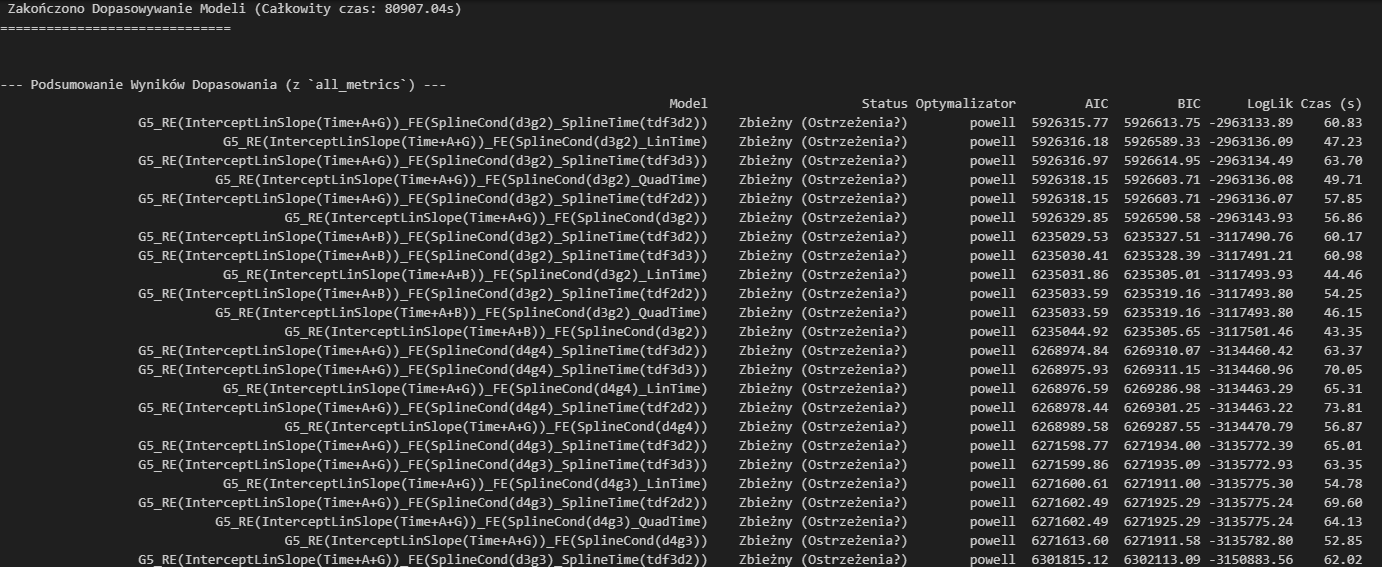
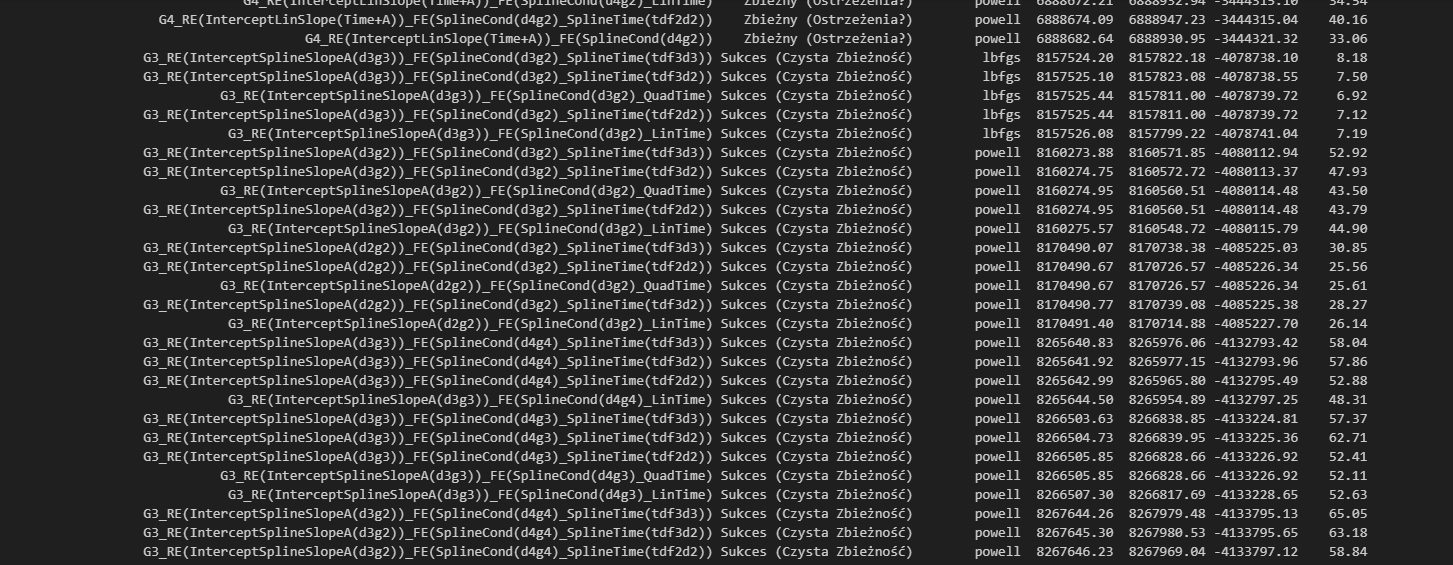

### Analiza Wyników

Ten fragment kodu odpowiada za proces **dopasowywania Liniowych Modeli Mieszanych (LMM)**, których specyfikacje (formuły) zostały wygenerowane we wcześniejszym etapie (`generated_models`). Skrypt iteruje przez listę definicji modeli, próbując dopasować każdy z nich do danych treningowych (`main_data_nested`) za pomocą funkcji `fit_lmm_safely`. Funkcja ta zapewnia robustność procesu poprzez testowanie wielu optymalizatorów (np. `powell`, `lbfgs`) i obsługę potencjalnych błędów czy problemów ze zbieżnością.

Podczas pętli iteracyjnej, kod starannie **zarządza pamięcią RAM**, usuwając duże obiekty wynikowe (`MixedLMResults`) po ekstrakcji kluczowych metryk (status zbieżności, AIC, BIC, LogLik, czas dopasowania). Jest to istotne przy testowaniu wielu potencjalnie złożonych modeli na dużym zbiorze danych.

### Podsumowanie Wyników Dopasowania

Po przetestowaniu wszystkich modeli, skrypt generuje **tabelaryczne podsumowanie** (`summary_df`) zawierające kluczowe metryki dla każdego z nich:
* **Model:** Nazwa wygenerowanej specyfikacji modelu, kodująca użytą grupę, strukturę RE i FE.
* **Status:** Informacja o wyniku dopasowania (np. "Sukces (Czysta Zbieżność)", "Zbieżny (Ostrzeżenia?)", "BŁĄD").
* **Optymalizator:** Nazwa algorytmu, który finalnie dopasował dany model.
* **AIC, BIC, LogLik:** Kryteria informacyjne i log-wiarygodność (niższe AIC/BIC generalnie wskazują na lepsze dopasowanie modelu przy danej złożoności, jeśli porównujemy modele estymowane tą samą metodą - tutaj ML).
* **Czas (s):** Czas potrzebny na dopasowanie danego modelu.

Przedstawiona tabela jest sortowana rosnąco według **AIC**, co ułatwia identyfikację modeli lepiej dopasowanych do danych. Widzimy, że wiele modeli uzyskało status "Zbieżny (Ostrzeżenia?)", co oznacza, że optymalizator znalazł rozwiązanie, ale mogły wystąpić problemy numeryczne lub ostrzeżenia systemowe (co wymagałoby dalszej inspekcji). Pewna liczba modeli na końcu tabeli (z niższym AIC) osiągnęła **"Sukces (Czysta Zbieżność)"**. Całkowity czas dopasowania wszystkich modeli był znaczny (ponad 22 godziny).

### Analiza Najlepszego Modelu

Następnie kod **identyfikuje najlepszy model**, który osiągnął **czystą zbieżność** i ma **najniższą wartość AIC**. Zgodnie z przedstawionym wynikiem, najlepszym modelem okazał się:

**`G3_RE(InterceptSplineSlopeA(d3g3))_FE(SplineCond(d3g2)_SplineTime(tdf3d3))`**

* **AIC:** ~8157524.20
* **Optymalizator:** `lbfgs`
* **Formuła FE (efekty stałe):** `Reaction ~ bs(Alpha_Condition, df=3, degree=2) + bs(Beta_Condition, df=3, degree=2) + bs(Gamma_Condition, df=3, degree=2) + bs(SampleNumber, df=3, degree=3)`
    * *Interpretacja FE:* Modeluje średnią `Reaction` używając splajnów kwadratowych (degree=2) z 3 stopniami swobody (df=3) dla każdego warunku (Alpha, Beta, Gamma) oraz splajnu kubicznego (degree=3) z 3 stopniami swobody dla czasu (`SampleNumber`).
* **Formuła RE (efekty losowe):** `~ 1 + bs(Alpha_Condition, df=3, degree=3)`
    * *Interpretacja RE:* Modeluje zmienność między podmiotami (`Subject`) poprzez losowy intercept (`~ 1`) oraz losowe nachylenia dla **splajnu kubicznego** (degree=3) z 3 stopniami swobody dla warunku `Alpha_Condition`. Oznacza to, że model ten pozwala, aby nie tylko bazowy poziom `Reaction`, ale także **kształt nieliniowej zależności `Reaction` od `Alpha_Condition`** różnił się między podmiotami.

Ten wybrany model jest **ponownie dopasowywany** (używając preferowanego optymalizatora `lbfgs`), tym razem w celu uzyskania **pełnego obiektu wynikowego** (`MixedLMResults`) i możliwości dalszej analizy. Drukowane jest jego szczegółowe podsumowanie (`.summary()`), które zawiera:
* Oszacowania **współczynników efektów stałych** (dla wyrazu wolnego oraz poszczególnych baz splajnów dla warunków i czasu).
* Oszacowania **komponentów wariancji i kowariancji dla efektów losowych** (tutaj: wariancja dla losowego interceptu (`Group Var`), wariancje dla 3 baz losowego splajnu `bs(Alpha_Condition, df=3, degree=3)` oraz ich kowariancje).
* Standardowe błędy, statystyki z i p-wartości dla efektów stałych.
* Ogólne statystyki dopasowania modelu (Log-Likelihood, AIC, BIC).

Na samym końcu, kod generuje **wykres diagnostyczny reszt vs wartości dopasowane** dla tego najlepszego modelu, co pomaga ocenić, czy założenia modelu (np. jednorodność wariancji reszt, brak wzorców) są spełnione.

#### Sprawdzenie dla najlepszego modelu

# Walidacja LLM

### Trenowanie, Diagnostyka i Walidacja Wybranego Modelu LMM

Ten skrypt koncentruje się na **szczegółowej analizie i walidacji jednego, konkretnego Liniowego Modelu Mieszanego (LMM)**, który został wcześniej wybrany (np. na podstawie wyników masowego dopasowania). Proces jest kontrolowany przez szereg stałych konfiguracyjnych definiujących m.in. nazwę analizowanego modelu (`MODEL_NAME_TO_ANALYZE`), nazwy kluczowych kolumn, parametry dopasowania (`FIT_*`) oraz flagi włączające/wyłączające poszczególne etapy analizy (`RUN_*`).

### 1. Przygotowanie i Trenowanie Modelu

* **Wybór Modelu:** Na podstawie stałej `MODEL_NAME_TO_ANALYZE`, skrypt wyszukuje odpowiednią definicję modelu (formułę dla efektów stałych FE i losowych RE) z listy `generated_models`.
* **Przygotowanie Danych:** Dane treningowe (`training_data`) są przygotowywane, m.in. poprzez zapewnienie, że kolumna grupująca (`GROUP_COL`) jest typu kategorycznego.
* **Trenowanie:** Wybrany model LMM jest dopasowywany do danych treningowych za pomocą funkcji `fit_lmm_safely`. Funkcja ta, jak opisano wcześniej, zapewnia robustność procesu estymacji, zwracając obiekt dopasowanego modelu (`result_object`) oraz informacje o zbieżności i ewentualnych problemach.

### 2. Diagnostyka Dopasowanego Modelu

Jeśli model został pomyślnie dopasowany (`result_object` istnieje), przeprowadzana jest jego diagnostyka (jeśli flagi `RUN_SUMMARY`, `RUN_DIAGNOSTICS`, `RUN_INDIVIDUAL_CURVES` są `True`):

* **Podsumowanie Statystyczne:** Wyświetlane jest pełne podsumowanie modelu (`result_object.summary()`) zawierające oszacowane współczynniki, błędy standardowe, statystyki testowe i miary dopasowania.
* **Diagnostyka Graficzna (`plot_lmm_diagnostics`):** Generowane są standardowe wykresy diagnostyczne (Reszty vs Wartości Dopasowane, Wykres Q-Q Reszt) w celu oceny założeń modelu na danych treningowych.
* **Wizualizacja Krzywych Indywidualnych (`IndividualCurvesPlotter`):** Tworzony jest wykres pokazujący przewidywane trajektorie `Reaction` dla poszczególnych podmiotów w zależności od zmian w głównych predyktorach warunkowych (`CONDITION_COLS`). Porównuje on krzywe indywidualne (uwzględniające przynajmniej losowy intercept podmiotu - *zgodnie z implementacją `get_random_intercept`*) ze średnią krzywą populacyjną (efekty stałe).

### 3. Walidacja Predykcyjna Modelu (`LMMValidator`)

Najważniejszym etapem jest ocena zdolności predykcyjnej dopasowanego modelu na danych walidacyjnych (jeśli flaga `RUN_VALIDATION` jest `True`). Proces ten jest hermetyzowany w klasie `LMMValidator`:

* **Przygotowanie Danych Walidacyjnych:** Kluczowym krokiem przed predykcją jest **transformacja danych walidacyjnych** (`validation_data_s1`, `validation_data_s2`) za pomocą biblioteki `patsy`. Używa ona formuły efektów stałych (`fixed_formula`) dopasowanego modelu, aby utworzyć macierze danych (`exog`) o strukturze kolumn (np. z bazami splajnów, interakcjami) dokładnie odpowiadającej tej, której oczekuje metoda `.predict()` obiektu `result_object`. Ten krok jest niezbędny dla modeli o złożonych formułach FE.
* **Dwa Scenariusze Walidacji:** Instancje klasy `LMMValidator` są tworzone i uruchamiane (`.validate()`) dwukrotnie:
    1.  **Scenariusz 1 (`validation_data_s1`)**: Używa danych **znanych podmiotów** w nowych warunkach. Walidacja przeprowadzana jest z opcją `use_random_effects=True`, co oznacza, że do predykcji wartości `Reaction` wykorzystywane są zarówno oszacowane efekty stałe, jak i **oszacowane efekty losowe** dla tych podmiotów. Testuje to zdolność modelu do precyzyjnych predykcji wewnątrzobiektowych.
    2.  **Scenariusz 2 (`validation_data_s2`)**: Używa danych **nowych, niewidzianych wcześniej podmiotów**. Walidacja przeprowadzana jest z opcją `use_random_effects=False`. Ponieważ dla nowych podmiotów nie mamy oszacowanych efektów losowych, predykcje opierają się **wyłącznie na efektach stałych** modelu. Testuje to zdolność modelu do **generalizacji** na nowe obiekty.
* **Obliczanie Metryk i Wizualizacja:** Dla każdego scenariusza, klasa `LMMValidator` oblicza metryki **RMSE, MAE, R²** i (jeśli `PLOT_VALIDATION_RESULTS` jest `True`) generuje wykres **Wartości Przewidywane vs Rzeczywiste**.

### Podsumowanie Procesu

Ten kod wykonuje kompleksową analizę pojedynczego, wybranego modelu LMM. Obejmuje jego robustne dopasowanie, diagnostykę na danych treningowych oraz, co najważniejsze, ocenę jego zdolności predykcyjnych w dwóch kluczowych scenariuszach walidacyjnych, dostarczając metryk ilościowych (RMSE, MAE, R²) i wizualizacji pozwalających ocenić jego potencjalną użyteczność praktyczną.

In [ ]:
# --- Stałe Konfiguracyjne ---
MODEL_NAME_TO_ANALYZE = "G3_RE(InterceptSplineSlopeA(d3g3))_FE(SplineCond(d3g2)_SplineTime(tdf3d3))"
GROUP_COL = "Subject"
REACTION_VAR = "Reaction"
TIME_VAR = "SampleNumber" 
CONDITION_COLS: List[str] = ["Alpha_Condition", "Beta_Condition", "Gamma_Condition"] # j.w.

VALIDATION_DATA_S1_VARNAME = "validation_data_s1"
VALIDATION_DATA_S2_VARNAME = "validation_data_s2"

# Flagi kontrolujące przebieg skryptu
RUN_SUMMARY = True
RUN_DIAGNOSTICS = True
RUN_INDIVIDUAL_CURVES = True
RUN_VALIDATION = True
PLOT_VALIDATION_RESULTS = True 

# Parametry dopasowania modelu
FIT_OPTIMIZERS = ['powell', 'lbfgs', 'bfgs']
FIT_PREFERRED_OPTIMIZER = 'powell'
FIT_USE_ML = True
FIT_MAXITER = 10000
FIT_VERBOSE = True
DEFAULT_VALIDATION_PLOT_SAMPLE_SIZE = 60000

class LMMValidator:
    """
    Klasa do przeprowadzania walidacji predykcyjnej modelu LMM (Linear Mixed Model).

    Hermetyzuje logikę predykcji (FE i opcjonalnie RE), obliczania metryk
    i generowania wykresów walidacyjnych. Zaprojektowana do współpracy z wynikami
    z `statsmodels` i danymi przetworzonymi przez `patsy`.
    Radzi sobie z brakiem atrybutu `model.re_names` poprzez mechanizm fallback.
    """

    # --------------------------------------------------------------------------
    # Metoda __init__ - Z DROBNĄ OPTYMALIZACJĄ (usunięto try/except global)
    # --------------------------------------------------------------------------
    def __init__(self,
                 result_object: Any, # Typ: MixedLMResults lub Any
                 validation_data: pd.DataFrame,
                 scenario_name: str,
                 reaction_col: str,
                 group_col: str,
                 plot: bool = True,
                 use_random_effects: bool = False,
                 plot_sample_size: Optional[int] = None):
        """
        Inicjalizuje walidator LMM.

        Args:
            result_object: Obiekt wyniku dopasowanego modelu LMM (z statsmodels).
            validation_data: DataFrame z danymi do walidacji. Powinien zawierać
                             kolumny reaction_col, group_col oraz WSZYSTKIE kolumny
                             predyktorów wygenerowane przez Patsy (zarówno dla FE jak i RE),
                             zgodne z tym, czego oczekuje model.
            scenario_name: Nazwa scenariusza walidacji (np. "S1 (FE+RE)").
            reaction_col: Nazwa kolumny ze zmienną zależną.
            group_col: Nazwa kolumny grupującej.
            plot: Czy generować wykres Predicted vs True?
            use_random_effects: Czy dodać efekty losowe do predykcji?
            plot_sample_size: Maks. liczba punktów na wykresie walidacyjnym.
                              Jeśli None, użyje DEFAULT_VALIDATION_PLOT_SAMPLE_SIZE.
        """
        self.result_object = result_object
        # Sprawdzenie None przed kopiowaniem
        if validation_data is None:
             logging.error(f"[{scenario_name}] Krytyczny błąd: przekazano validation_data=None do konstruktora.")
             # Ustaw pusty DataFrame, aby uniknąć późniejszych błędów atrybutów
             self.validation_data = pd.DataFrame()
             # Ustaw is_ready na False od razu
             self.is_ready = False
             # Zapisz pozostałe atrybuty
             self.scenario_name = scenario_name
             self.reaction_col = reaction_col
             self.group_col = group_col
             self.plot = plot
             self.use_random_effects = use_random_effects
             self.plot_sample_size = DEFAULT_VALIDATION_PLOT_SAMPLE_SIZE # Użyj domyślnej
             # Zainicjuj pozostałe pola na None/puste
             self.metrics = None
             self.y_true_final = None
             self.y_pred_final = None
             self.model_fe_predictors = []
             self.model_re_names_used = None
             # Zakończ inicjalizację wcześnie
             return
        else:
             # Jeśli dane są OK, kontynuuj normalnie
             self.validation_data = validation_data.copy() # Pracuj na kopii

        self.scenario_name = scenario_name
        self.reaction_col = reaction_col
        self.group_col = group_col
        self.plot = plot
        self.use_random_effects = use_random_effects

        # Rozmiar próbki do wykresu - użyj domyślnej LUB przekazanej wartości
        # Usunięto odwołanie do globalnej zmiennej wewnątrz metody
        self.plot_sample_size = plot_sample_size if plot_sample_size is not None else DEFAULT_VALIDATION_PLOT_SAMPLE_SIZE

        # Atrybuty wewnętrzne
        self.metrics: Optional[Dict[str, Any]] = None
        self.y_true_final: Optional[pd.Series] = None
        self.y_pred_final: Optional[pd.Series] = None
        self.model_fe_predictors: List[str] = []
        self.model_re_names_used: Optional[List[str]] = None
        # Wywołaj _initial_checks na końcu, aby ustawić is_ready
        self.is_ready = self._initial_checks()

    # --------------------------------------------------------------------------
    # Metoda _initial_checks - BEZ ZMIAN (wygląda poprawnie)
    # --------------------------------------------------------------------------
    def _initial_checks(self) -> bool:
        """Sprawdza warunki początkowe."""
        # Sprawdzenie None dla validation_data jest teraz w __init__
        if self.validation_data.empty:
             # Ten log może być potrzebny, jeśli dane stały się puste po skopiowaniu (mało prawdopodobne)
             logging.error(f"[{self.scenario_name}] Błąd: Dane walidacyjne są puste.")
             return False
        if self.result_object is None:
            logging.error(f"[{self.scenario_name}] Błąd: result_object jest None.")
            return False

        required_cols = {self.reaction_col, self.group_col}
        if not required_cols.issubset(self.validation_data.columns):
            logging.error(f"[{self.scenario_name}] Błąd: Brak kolumn {required_cols - set(self.validation_data.columns)} w danych.")
            return False
        if self.validation_data[self.reaction_col].isnull().all():
            logging.error(f"[{self.scenario_name}] Błąd: Kolumna '{self.reaction_col}' ma same NaN.")
            return False
        if self.validation_data[self.group_col].isnull().any():
            logging.warning(f"[{self.scenario_name}] Ostrzeżenie: Kolumna '{self.group_col}' ma wartości NaN. Wiersze z NaN w tej kolumnie zostaną pominięte przy dodawaniu RE.")

        # Pobranie nazw FE
        # Preferuj exog_names, bo zawiera pełną listę łącznie z interceptem, co pasuje do fe_params.index
        try:
            # Sprawdź, czy model istnieje
            if not hasattr(self.result_object, 'model'):
                 raise AttributeError("Obiekt wyniku nie ma atrybutu 'model'.")
            # Spróbuj pobrać exog_names
            if not hasattr(self.result_object.model, 'exog_names'):
                 raise AttributeError("Obiekt model nie ma atrybutu 'exog_names'.")

            self.model_fe_predictors = list(self.result_object.model.exog_names)
            if not self.model_fe_predictors:
                 raise AttributeError("Lista exog_names jest pusta.")
            logging.debug(f"[{self.scenario_name}] Użyto predyktorów FE z `model.exog_names`: {self.model_fe_predictors}")

        except AttributeError as e_exog:
            logging.warning(f"[{self.scenario_name}] Problem z `model.exog_names`: {e_exog}. Fallback na `fe_params.index`.")
            try:
                if not hasattr(self.result_object, 'fe_params'):
                     raise AttributeError("Obiekt wyniku nie ma atrybutu 'fe_params'.")

                self.model_fe_predictors = list(self.result_object.fe_params.index)
                if not self.model_fe_predictors:
                     raise AttributeError("Indeks fe_params jest pusty.")
                logging.debug(f"[{self.scenario_name}] Użyto predyktorów FE z `fe_params.index`: {self.model_fe_predictors}")
            except AttributeError as e_fe_params:
                logging.error(f"[{self.scenario_name}] Błąd krytyczny: Nie można określić predyktorów FE ani z exog_names, ani z fe_params.index: {e_fe_params}.")
                return False

        # Sprawdzenie kolumn FE w danych walidacyjnych (po transformacji Patsy)
        # Walidator potrzebuje wszystkich kolumn FE (w tym interceptu, jeśli jest w modelu)
        # do poprawnego wykonania mnożenia exog @ fe_params.
        missing_fe_in_data = set(self.model_fe_predictors) - set(self.validation_data.columns)
        if missing_fe_in_data:
            logging.error(f"[{self.scenario_name}] Błąd: Brakujące kolumny FE w przetransformowanych danych walidacyjnych! Brakuje: {missing_fe_in_data}.")
            logging.error(f"Dostępne kolumny w danych: {list(self.validation_data.columns)}")
            return False

        # Sprawdzenie RE (jeśli używane)
        if self.use_random_effects:
            try:
                if not hasattr(self.result_object, 'random_effects') or not self.result_object.random_effects:
                    logging.error(f"[{self.scenario_name}] Błąd: Brak `random_effects` lub są puste (potrzebne dla use_random_effects=True).")
                    return False
                if not isinstance(self.result_object.random_effects, dict):
                    logging.error(f"[{self.scenario_name}] Błąd: `random_effects` nie jest słownikiem.")
                    return False
            except Exception as e:
                logging.error(f"[{self.scenario_name}] Błąd podczas sprawdzania `random_effects`: {e}")
                return False

            # Sprawdzenie istnienia model.re_names (loguje ostrzeżenie jeśli brak - obsłużone w _get_re_structure)
            try:
                has_model_attr = hasattr(self.result_object, 'model')
                has_re_names_attr = has_model_attr and hasattr(self.result_object.model, 're_names')
                re_names_val = getattr(self.result_object.model, 're_names', None) if has_re_names_attr else None

                if not has_model_attr:
                    logging.warning(f"[{self.scenario_name}] Ostrzeżenie: Brak `result_object.model`. Nie można sprawdzić `model.re_names`.")
                elif not has_re_names_attr:
                    logging.warning(f"[{self.scenario_name}] Ostrzeżenie: Brak atrybutu `model.re_names`. Walidator spróbuje odgadnąć nazwy RE.")
                elif not re_names_val: # Atrybut istnieje, ale jest pusty (None, [], itp.)
                    logging.warning(f"[{self.scenario_name}] Ostrzeżenie: Atrybut `model.re_names` jest pusty. Walidator spróbuje odgadnąć nazwy RE.")
                else:
                    logging.debug(f"[{self.scenario_name}] Znaleziono `model.re_names`: {re_names_val}")
            except Exception as e:
                logging.warning(f"[{self.scenario_name}] Błąd dostępu do `model.re_names`: {e}. Walidator spróbuje odgadnąć.")

        logging.info(f"[{self.scenario_name}] Wstępne sprawdzenia OK.")
        return True

    # --------------------------------------------------------------------------
    # Metoda _predict_fixed_effects - POPRAWIONA (używa exog @ fe_params)
    # --------------------------------------------------------------------------
    def _predict_fixed_effects(self, data_for_predict: pd.DataFrame) -> Optional[pd.Series]:
        """
        Wykonuje predykcję na podstawie efektów stałych (FE) modelu.
        Używa ręcznego mnożenia macierzy exog * fe_params dla większej kontroli.
        """
        logging.debug(f"[{self.scenario_name}] Rozpoczęcie predykcji FE...")

        # Sprawdź czy mamy listę predyktorów FE i parametry FE
        if not self.model_fe_predictors:
            logging.error(f"[{self.scenario_name}] Brak listy predyktorów FE (self.model_fe_predictors).")
            return None
        # Sprawdź istnienie atrybutu fe_params (powinien istnieć w MixedLMResults)
        if not hasattr(self.result_object, 'fe_params'):
             logging.error(f"[{self.scenario_name}] Brak atrybutu 'fe_params' w obiekcie wyniku modelu.")
             return None

        try:
            # Lista predyktorów FE (z _initial_checks, powinna zawierać Intercept)
            # Ta lista powinna odpowiadać INDEKSOWI self.result_object.fe_params
            fe_cols_for_predict = self.model_fe_predictors
            # Pobierz JEDYNIE parametry efektów stałych
            fe_params = self.result_object.fe_params

            # Sprawdź, czy WSZYSTKIE kolumny FE istnieją w danych wejściowych
            missing_cols = set(fe_cols_for_predict) - set(data_for_predict.columns)
            if missing_cols:
                logging.error(f"[{self.scenario_name}] Błąd wewnętrzny predykcji FE: Brak kolumn {missing_cols} w danych do predykcji.")
                logging.error(f"Oczekiwane kolumny FE (z modelu): {fe_cols_for_predict}")
                logging.error(f"Dostępne kolumny w danych: {list(data_for_predict.columns)}")
                return None

            # Wybierz odpowiednie kolumny w odpowiedniej kolejności z danych walidacyjnych
            # Używamy kolejności z self.model_fe_predictors, która powinna pasować do fe_params.index
            exog_for_predict = data_for_predict[fe_cols_for_predict]

            # --- Poprawione Sprawdzenie Wymiarów ---
            num_fe_params = len(fe_params)
            num_cols_in_exog = exog_for_predict.shape[1]

            if num_cols_in_exog != num_fe_params:
                 # Ten błąd teraz nie powinien wystąpić, jeśli fe_cols_for_predict pasuje do fe_params
                 logging.error(f"[{self.scenario_name}] KRYTYCZNA Niezgodność wymiarów PRZED mnożeniem: "
                               f"Liczba kolumn w exog ({num_cols_in_exog}) != Liczba parametrów FE ({num_fe_params}).")
                 logging.error(f"Kolumny w exog: {list(exog_for_predict.columns)}")
                 logging.error(f"Nazwy parametrów FE (indeks): {list(fe_params.index)}")
                 # Sprawdźmy też listę z self.model_fe_predictors dla porównania
                 logging.error(f"Predyktory FE wg _initial_checks: {self.model_fe_predictors}")
                 return None

            logging.debug(f"Obliczanie predykcji FE przez: np.dot(exog shape: {exog_for_predict.shape}, fe_params shape: {fe_params.shape})")

            # --- Ręczne Obliczenie Predykcji FE (exog @ fe_params) ---
            # Używamy .values, aby upewnić się, że pracujemy na ndarray i uniknąć problemów z indeksami/nazwami
            y_pred_values = np.dot(exog_for_predict.values, fe_params.values)

            # Wynik np.dot to ndarray, konwertuj na Series z odpowiednim indeksem danych wejściowych
            if len(y_pred_values) == len(data_for_predict):
                 y_pred_raw = pd.Series(y_pred_values, index=data_for_predict.index, name=f"predicted_{self.reaction_col}_fe")
                 logging.debug(f"Predykcja FE obliczona (rozmiar: {y_pred_raw.shape})")
                 return y_pred_raw
            else:
                 # Ten błąd nie powinien wystąpić, jeśli wymiary wejściowe były zgodne
                 raise ValueError(f"Niezgodna długość wyniku np.dot ({len(y_pred_values)}) vs data ({len(data_for_predict)}).")

        except Exception as e:
            logging.error(f"[{self.scenario_name}] Błąd podczas predykcji FE: {e}", exc_info=True)
            # Dodaj logowanie kształtów, jeśli zmienne istnieją
            if 'exog_for_predict' in locals() and 'fe_params' in locals():
                 logging.error(f"Kształty przy błędzie: exog={exog_for_predict.shape}, fe_params={fe_params.shape}")
            return None

    # --------------------------------------------------------------------------
    # Metoda _get_re_structure - BEZ ZMIAN (wygląda poprawnie)
    # --------------------------------------------------------------------------
    def _get_re_structure(self, random_effects_dict: Dict) -> Optional[List[str]]:
        """Próbuje ustalić nazwy RE, priorytetyzując model.re_names."""
        # Priorytet 1: Spróbuj użyć model.re_names
        try:
            if hasattr(self.result_object, 'model') and hasattr(self.result_object.model, 're_names'):
                model_re_names = self.result_object.model.re_names
                # Sprawdź, czy lista nie jest pusta i jest listą
                if model_re_names and isinstance(model_re_names, list):
                    logging.info(f"[{self.scenario_name}] Użyto nazw RE z `model.re_names`: {model_re_names}")
                    self.model_re_names_used = list(model_re_names) # Zapisz używane nazwy
                    return self.model_re_names_used
                else:
                    # Atrybut istnieje, ale jest pusty lub niepoprawnego typu
                    logging.warning(f"[{self.scenario_name}] Atrybut `model.re_names` istnieje, ale jest pusty lub nie jest listą ({type(model_re_names)}). Przechodzenie do odgadywania.")
            else:
                # Brak atrybutu model lub re_names
                 logging.warning(f"[{self.scenario_name}] Brak atrybutu `model.re_names`. Przechodzenie do odgadywania.")
        except Exception as e:
             logging.warning(f"[{self.scenario_name}] Błąd podczas dostępu do `model.re_names`: {e}. Przechodzenie do odgadywania.")

        # Priorytet 2: Odgadywanie ze struktury random_effects
        logging.info(f"[{self.scenario_name}] Odgadywanie nazw RE ze struktury `random_effects`...")
        if not random_effects_dict:
             logging.error(f"[{self.scenario_name}] Słownik `random_effects` jest pusty. Nie można odgadnąć nazw RE.")
             return None

        try:
            # Użyj wartości dla pierwszego klucza jako reprezentatywnej struktury
            first_subj_re_structure = next(iter(random_effects_dict.values()))

            # Przypadek 1: Struktura to Series (najczęstszy dla wielu RE)
            if isinstance(first_subj_re_structure, pd.Series):
                guessed_names = list(first_subj_re_structure.index)
                if guessed_names:
                    logging.info(f"[{self.scenario_name}] Odgadnięte nazwy RE (z indeksu Series): {guessed_names}")
                    self.model_re_names_used = guessed_names
                    return guessed_names
                else:
                    logging.error(f"[{self.scenario_name}] Indeks Series w `random_effects` jest pusty. Nie można odgadnąć nazw.")
                    return None
            # Przypadek 2: Struktura to ndarray (może się zdarzyć)
            elif isinstance(first_subj_re_structure, np.ndarray):
                if len(first_subj_re_structure) == 1:
                    # Załóż, że to intercept, użyj standardowej nazwy
                    guessed_names = ['Group / Intercept']
                    logging.warning(f"[{self.scenario_name}] RE to ndarray(1). Zakładam nazwę: {guessed_names}")
                    self.model_re_names_used = guessed_names
                    return guessed_names
                else:
                    logging.error(f"[{self.scenario_name}] RE to ndarray z {len(first_subj_re_structure)} elementami, ale brak `model.re_names`. Nie można odgadnąć nazw nachyleń.")
                    return None
            # Przypadek 3: Struktura to skalar (tylko intercept)
            elif isinstance(first_subj_re_structure, (int, float)):
                guessed_names = ['Group / Intercept']
                logging.warning(f"[{self.scenario_name}] RE to skalar ({type(first_subj_re_structure)}). Zakładam nazwę: {guessed_names}")
                self.model_re_names_used = guessed_names
                return guessed_names
            # Przypadek 4: Nieznany typ
            else:
                logging.error(f"[{self.scenario_name}] Nieobsługiwany typ struktury RE do odgadywania: {type(first_subj_re_structure)}.")
                return None
        except StopIteration: # Jeśli random_effects_dict było puste (sprawdzone wcześniej, ale dla pewności)
            logging.error(f"[{self.scenario_name}] Słownik `random_effects` jest pusty (StopIteration). Nie można odgadnąć nazw.")
            return None
        except Exception as e:
            logging.error(f"[{self.scenario_name}] Nieoczekiwany błąd podczas odgadywania struktury RE: {e}", exc_info=True)
            return None

    def _add_random_effects(self, y_pred_fixed: pd.Series, data_aligned: pd.DataFrame) -> pd.Series:
        """
        Dodaje efekty losowe (RE) do predykcji efektów stałych (FE).

        Ta wersja zawiera ulepszoną logikę mapowania nazw RE (w tym tych
        generowanych przez Patsy dla transformacji jak bs()) na kolumny
        w danych walidacyjnych oraz rozszerzone logowanie na poziomie DEBUG
        w celu śledzenia procesu dodawania RE.
        """
        # Krok 0: Zwróć predykcje FE, jeśli nie używamy RE
        if not self.use_random_effects:
            return y_pred_fixed

        logging.info(f"[{self.scenario_name}] Dodawanie efektów losowych (RE)...")
        y_pred_with_re = y_pred_fixed.copy() # Pracuj na kopii

        # Krok 1: Pobierz słownik efektów losowych z obiektu wyniku
        try:
            random_effects_dict = self.result_object.random_effects
            if not random_effects_dict or not isinstance(random_effects_dict, dict):
                logging.error(f"[{self.scenario_name}] Atrybut 'random_effects' jest pusty lub nie jest słownikiem. Przerywanie dodawania RE.")
                return y_pred_fixed # Zwróć tylko FE
        except AttributeError:
            logging.error(f"[{self.scenario_name}] Brak atrybutu 'random_effects' w obiekcie wyniku. Przerywanie dodawania RE.")
            return y_pred_fixed

        # Krok 2: Uzyskaj nazwy RE (z model.re_names lub przez odgadywanie)
        # Metoda _get_re_structure zapisze użyte nazwy w self.model_re_names_used
        model_re_names = self._get_re_structure(random_effects_dict)
        if not model_re_names:
            logging.error(f"[{self.scenario_name}] Nie udało się uzyskać nazw RE (model_re_names jest puste). Przerywanie dodawania RE.")
            return y_pred_fixed
        logging.debug(f"[{self.scenario_name}] Używane nazwy RE (z modelu/odgadnięte): {model_re_names}")

        # Krok 3: Zidentyfikuj nazwę interceptu RE
        intercept_re_name: Optional[str] = None
        # Lista potencjalnych nazw dla interceptu (standardowe i często spotykane)
        possible_intercept_names = ['Intercept', 'Group', 'Group / Intercept']
        found_intercept = False
        for name in model_re_names:
            if name in possible_intercept_names:
                if not found_intercept:
                    intercept_re_name = name
                    found_intercept = True
                    logging.debug(f"[{self.scenario_name}] Zidentyfikowano intercept RE jako: '{intercept_re_name}'")
                else:
                    logging.warning(f"[{self.scenario_name}] Znaleziono wiele potencjalnych nazw interceptu RE ('{intercept_re_name}', '{name}'). Używam pierwszej: '{intercept_re_name}'.")
        # Fallback: jeśli jest tylko jeden RE, zakładamy, że to intercept
        if not found_intercept and len(model_re_names) == 1:
            intercept_re_name = model_re_names[0]
            logging.debug(f"[{self.scenario_name}] Znaleziono tylko jeden RE ('{intercept_re_name}'). Zakładam, że to intercept.")
        elif not found_intercept and len(model_re_names) > 1:
            logging.warning(f"[{self.scenario_name}] Nie znaleziono standardowej nazwy interceptu RE wśród: {model_re_names}. Intercept RE może nie zostać dodany.")

        # Krok 4: Zmapuj nazwy nachyleń RE na kolumny w danych walidacyjnych
        logging.debug(f"[{self.scenario_name}] Mapowanie nazw nachyleń RE na kolumny w danych walidacyjnych...")
        available_data_cols = set(data_aligned.columns) # Zbiór kolumn dla szybkiego sprawdzania
        slope_re_map: Dict[str, str] = {} # Mapa: Nazwa RE -> Nazwa kolumny w danych
        warnings_logged_for_mapping = set() # Aby logować ostrzeżenie tylko raz dla każdej brakującej nazwy

        for re_name in model_re_names:
            # Rozważamy tylko te nazwy RE, które NIE są zidentyfikowanym interceptem
            if re_name != intercept_re_name:
                mapped_col = None
                # --- Ulepszona logika mapowania ---
                # 1. Sprawdź DOKŁADNE dopasowanie nazwy RE do nazwy kolumny
                #    (To powinno działać dla nazw generowanych przez Patsy, np. bs(...)[N])
                if re_name in available_data_cols:
                    mapped_col = re_name
                    logging.debug(f"  - Mapowanie OK: RE '{re_name}' -> Kolumna '{mapped_col}' (dopasowanie bezpośrednie)")
                else:
                    # 2. Jeśli dokładne dopasowanie zawiodło, sprawdź, czy nazwa RE zaczyna się od 'Group / '
                    #    i spróbuj dopasować nazwę bez tego prefiksu (przydatne dla prostszych RE)
                    simple_name_candidate = None # Zdefiniuj przed blokiem if
                    if re_name.startswith('Group / '):
                        simple_name_candidate = re_name[len('Group / '):]
                        if simple_name_candidate in available_data_cols:
                            mapped_col = simple_name_candidate
                            logging.debug(f"  - Mapowanie OK: RE '{re_name}' -> Kolumna '{mapped_col}' (dopasowanie po usunięciu prefiksu)")

                # --- Zapisz mapowanie lub zaloguj ostrzeżenie ---
                if mapped_col:
                    slope_re_map[re_name] = mapped_col
                elif re_name not in warnings_logged_for_mapping:
                    # Zbuduj komunikat ostrzegawczy krok po kroku, aby uniknąć błędów składni
                    warning_msg_base = f"  - Mapowanie FAIL: Brak pasującej kolumny w danych dla nachylenia RE '{re_name}'. Sprawdzano: '{re_name}'"
                    
                    # Zmienna simple_name_candidate jest już zdefiniowana wyżej w pętli
                    # Sprawdźmy, czy próbowaliśmy dopasować nazwę bez prefiksu
                    checked_simple_name = False
                    if re_name.startswith('Group / '):
                         simple_name_candidate = re_name[len('Group / '):] # Upewnijmy się, że jest zdefiniowana
                         checked_simple_name = True # Zaznacz, że ta ścieżka była sprawdzana

                    # Dodaj informację o sprawdzaniu prostej nazwy, jeśli to miało miejsce
                    if checked_simple_name:
                         warning_msg_base += f" oraz (bez prefiksu) '{simple_name_candidate}'"
                    
                    # Dodaj końcową część komunikatu
                    warning_msg_final = warning_msg_base + ". To nachylenie zostanie pominięte."
                    
                    # Zaloguj gotowy komunikat
                    logging.warning(warning_msg_final)
                    warnings_logged_for_mapping.add(re_name) # Zaznacz, że ostrzeżenie zostało zalogowane

        logging.debug(f"[{self.scenario_name}] Zakończono mapowanie. Używany Intercept RE: '{intercept_re_name}'. Zmapowane nachylenia RE: {slope_re_map}")

        # Jeśli nie udało się zidentyfikować ani interceptu, ani ŻADNYCH nachyleń, przerwij
        if not intercept_re_name and not slope_re_map:
            logging.error(f"[{self.scenario_name}] Nie udało się zidentyfikować ani interceptu RE, ani zmapować żadnych nachyleń RE. Dodawanie RE przerwane.")
            return y_pred_fixed

        # Krok 5: Konwertuj klucze słownika RE na stringi (profilaktycznie)
        try:
            random_effects_dict_str_keys = {str(k): v for k, v in random_effects_dict.items()}
        except Exception as e:
            logging.error(f"[{self.scenario_name}] Błąd podczas konwersji kluczy słownika random_effects na stringi: {e}. Dodawanie RE przerwane.")
            return y_pred_fixed

        subjects_in_model_re = set(random_effects_dict_str_keys.keys())
        n_missing_subj = 0
        missing_subj_list = []
        processed_groups_count = 0 # Licznik do logowania debug

        # Krok 6: Grupuj dane walidacyjne (po usunięciu NaN w kolumnie grupującej)
        try:
            valid_groups_filter = data_aligned[self.group_col].notna()
            if not valid_groups_filter.any():
                logging.error(f"[{self.scenario_name}] Brak ważnych (nie-NaN) grup w kolumnie '{self.group_col}'. Dodawanie RE przerwane.")
                return y_pred_fixed

            data_valid_groups = data_aligned[valid_groups_filter]
            # Konwertuj kolumnę grupy na string PRZED grupowaniem, aby dopasować klucze dict
            grouped_validation_data = data_valid_groups.groupby(data_valid_groups[self.group_col].astype(str))
            num_groups_to_process = len(grouped_validation_data)
        except Exception as e:
            logging.error(f"[{self.scenario_name}] Błąd podczas grupowania danych walidacyjnych po kolumnie '{self.group_col}': {e}. Dodawanie RE przerwane.")
            return y_pred_fixed

        logging.info(f"[{self.scenario_name}] Przetwarzanie RE dla {num_groups_to_process} grup...")
        # Sprawdźmy dostępne kolumny raz jeszcze na poziomie DEBUG
        logging.debug(f"Dostępne kolumny w data_aligned (do użycia w pętli): {list(data_aligned.columns)}")

        # Krok 7: Pętla po grupach w danych walidacyjnych
        for subj_str, group_indices in grouped_validation_data.groups.items():
            processed_groups_count += 1
            # Loguj postęp co pewien czas dla dużych zbiorów
            if num_groups_to_process > 100 and processed_groups_count % 50 == 0:
                 logging.info(f"  Przetworzono {processed_groups_count}/{num_groups_to_process} grup...")

            # Sprawdź, czy bieżąca grupa z danych walidacyjnych ma efekty losowe w modelu
            if subj_str in subjects_in_model_re:
                subj_re_full = random_effects_dict_str_keys[subj_str] # Struktura RE dla tej grupy
                subj_data_rows = data_valid_groups.loc[group_indices] # Wiersze danych dla tej grupy
                subj_re_contribution = pd.Series(0.0, index=group_indices) # Wektor wkładu RE (inicjalizowany zerami)
                # Loguj szczegóły tylko dla pierwszych N grup (np. 2) na poziomie DEBUG
                log_this_group_details = (processed_groups_count <= 2 and logging.getLogger().isEnabledFor(logging.DEBUG))

                if log_this_group_details: logging.debug(f"  Grupa: {subj_str} (Liczba obs: {len(group_indices)})")

                try:
                    # 7a: Dodaj wkład interceptu RE (jeśli istnieje)
                    if intercept_re_name:
                        re_intercept_val = self._get_re_value(subj_re_full, intercept_re_name, model_re_names)
                        if re_intercept_val is not None:
                            subj_re_contribution += re_intercept_val # Dodaj stałą wartość do wszystkich wierszy
                            if log_this_group_details: logging.debug(f"    Intercept RE '{intercept_re_name}': {re_intercept_val:.4f}")
                        elif log_this_group_details:
                            logging.debug(f"    Intercept RE '{intercept_re_name}': Nie znaleziono/pobrano wartości.")

                    # 7b: Dodaj wkład zmapowanych nachyleń RE
                    if slope_re_map:
                        # Sprawdź (profilaktycznie), czy potrzebne kolumny istnieją w danych DLA TEJ GRUPY
                        cols_needed = list(slope_re_map.values())
                        if set(cols_needed).issubset(subj_data_rows.columns):
                            # Wybierz podzbiór danych z potrzebnymi kolumnami
                            subj_slope_data = subj_data_rows[cols_needed]
                            # Pętla po zmapowanych nachyleniach
                            for re_name, col_name in slope_re_map.items():
                                re_slope_val = self._get_re_value(subj_re_full, re_name, model_re_names)
                                if re_slope_val is not None:
                                    # Wkład nachylenia = wartość_RE * kolumna_danych
                                    slope_effect = re_slope_val * subj_slope_data[col_name]
                                    # Dodaj wkład tego nachylenia do całkowitego wkładu RE
                                    subj_re_contribution = subj_re_contribution.add(slope_effect, fill_value=0)
                                    if log_this_group_details:
                                         # Oblicz statystyki wkładu tylko jeśli logujemy
                                         min_eff, max_eff = slope_effect.min(), slope_effect.max()
                                         logging.debug(f"    Nachylenie RE '{re_name}' (Kol: '{col_name}'): {re_slope_val:.4f} -> Wkład [min={min_eff:.3f}, max={max_eff:.3f}]")
                                elif log_this_group_details:
                                    logging.debug(f"    Nachylenie RE '{re_name}' (Kol: '{col_name}'): Nie znaleziono/pobrano wartości.")
                        else:
                            # Ten błąd jest mało prawdopodobny po sprawdzeniach mapowania, ale logujemy
                            missing_cols_subj = set(cols_needed) - set(subj_data_rows.columns)
                            logging.error(f"KRYTYCZNY (wewn. pętli grup): Brak kolumn {missing_cols_subj} dla nachyleń RE w danych grupy {subj_str}.")

                    # Loguj podsumowanie wkładu RE dla tej grupy (tylko jeśli logujemy szczegóły)
                    if log_this_group_details:
                         min_contr, max_contr, mean_contr = subj_re_contribution.min(), subj_re_contribution.max(), subj_re_contribution.mean()
                         logging.debug(f"    Całkowity wkład RE dla grupy {subj_str}: [min={min_contr:.3f}, max={max_contr:.3f}, mean={mean_contr:.3f}]")

                    # 7c: Dodaj obliczony całkowity wkład RE do predykcji FE dla tej grupy
                    # Używamy .loc dla bezpieczeństwa dopasowania indeksów
                    y_pred_with_re.loc[group_indices] = y_pred_with_re.loc[group_indices].add(subj_re_contribution, fill_value=0)

                except Exception as e_subj:
                    # Złap błędy specyficzne dla przetwarzania pojedynczej grupy
                    logging.error(f"[{self.scenario_name}] Błąd podczas przetwarzania RE dla grupy {subj_str}: {e_subj}", exc_info=True)
                    # Kontynuuj dla innych grup, ale ta grupa może nie mieć poprawnie dodanych RE

            else:
                # Grupa z danych walidacyjnych nie ma odpowiadających RE w modelu
                n_missing_subj += 1
                if n_missing_subj <= 10: # Loguj tylko kilka pierwszych brakujących
                     missing_subj_list.append(subj_str)
                elif n_missing_subj == 11:
                     missing_subj_list.append('...')
                if log_this_group_details: logging.debug(f"  Grupa: {subj_str} - Brak RE w modelu.")

        # Koniec pętli po grupach

        # Krok 8: Zaloguj podsumowanie o brakujących grupach
        if n_missing_subj > 0:
            logging.warning(f"[{self.scenario_name}] Nie znaleziono dopasowania RE dla {n_missing_subj} grup z danych walidacyjnych (np. {missing_subj_list}). Dla tych grup użyto tylko predykcji FE (lub FE+InterceptRE).")

        logging.info(f"[{self.scenario_name}] Zakończono dodawanie RE.")
        # Krok 9: Zwróć predykcje z dodanym wkładem RE
        return y_pred_with_re

    def _get_re_value(self, subj_re_full: Any, re_name: str, model_re_names: List[str]) -> Optional[float]:
        """
        Pomocnicza funkcja do bezpiecznego pobierania wartości pojedynczego efektu losowego (RE)
        dla danej grupy (subj_re_full) i konkretnej nazwy RE (re_name).
        Obsługuje różne formaty subj_re_full (Series, dict, ndarray, scalar)
        oraz próbuje dopasować nazwę (np. 'Intercept' vs 'Group / Intercept').
        """
        try:
            re_val = None
            # Sprawdź typ struktury RE dla tej grupy
            # Przypadek 1: Series lub Dict (najczęstszy)
            if isinstance(subj_re_full, (pd.Series, dict)):
                # Spróbuj pobrać wartość bezpośrednio po nazwie
                re_val = subj_re_full.get(re_name)
                # Jeśli nie znaleziono, a nazwa RE jest w formacie 'Group / ...',
                # spróbuj pobrać po nazwie bez prefiksu (na wypadek niespójności)
                if re_val is None and re_name.startswith('Group / '):
                    simple_name = re_name[len('Group / '):]
                    re_val = subj_re_full.get(simple_name)
                    # if re_val is not None: logging.debug(f"Dopasowano RE '{re_name}' przez prostą nazwę '{simple_name}'")

            # Przypadek 2: Numpy array
            elif isinstance(subj_re_full, np.ndarray):
                # Potrzebujemy znaleźć indeks tej nazwy RE w liście nazw RE modelu
                try:
                    idx = -1
                    if re_name in model_re_names:
                        idx = model_re_names.index(re_name)
                    # Spróbuj też dopasować prostą nazwę, jeśli oryginalna zawiera prefiks
                    elif re_name.startswith('Group / '):
                         simple_name = re_name[len('Group / '):]
                         if simple_name in model_re_names:
                              idx = model_re_names.index(simple_name)
                              # if idx != -1: logging.debug(f"Dopasowano RE '{re_name}' (ndarray) przez prostą nazwę '{simple_name}' na indeksie {idx}")

                    if idx == -1:
                         # Nie znaleziono ani oryginalnej, ani prostej nazwy w liście nazw modelu
                         raise ValueError(f"Nazwa RE '{re_name}' (ani jej prosta forma) nie znaleziona na liście model_re_names: {model_re_names}")

                    # Sprawdź, czy indeks jest w zakresie arraya
                    if 0 <= idx < len(subj_re_full):
                        re_val = subj_re_full[idx]
                    else:
                        # To nie powinno się zdarzyć, jeśli model_re_names pasuje do wymiaru ndarray
                        logging.warning(f"Indeks RE '{re_name}' ({idx}) poza zakresem ndarray (len={len(subj_re_full)}) dla grupy.")
                        return None
                except ValueError as e_idx: # Błąd z .index() lub podniesiony wyżej
                    logging.warning(f"Błąd podczas znajdowania indeksu dla RE '{re_name}' w ndarray: {e_idx}")
                    return None
                except IndexError: # Teoretycznie nie powinno wystąpić po sprawdzeniu zakresu
                    logging.warning(f"Błąd indeksowania ndarray dla RE '{re_name}' (idx={idx}).")
                    return None

            # Przypadek 3: Skalar (np. float, int) - sensowne tylko jeśli jest to jedyny RE
            elif isinstance(subj_re_full, (int, float)):
                # Sprawdź, czy lista nazw RE ma tylko jeden element i czy pasuje on do re_name
                if len(model_re_names) == 1:
                    # Sprawdź, czy żądana nazwa pasuje do jedynej nazwy w modelu
                    # (bezpośrednio lub przez prostą nazwę, jeśli jest prefiks)
                    model_re_name_single = model_re_names[0]
                    matches = (re_name == model_re_name_single)
                    if not matches and re_name.startswith('Group / '):
                         simple_name = re_name[len('Group / '):]
                         matches = (simple_name == model_re_name_single)

                    if matches:
                        re_val = subj_re_full
                    else:
                        # Żądano RE o nazwie X, ale jedyny RE w modelu nazywa się Y
                        # logging.debug(f"RE jest skalarem, ale żądana nazwa '{re_name}' nie pasuje do jedynej nazwy w modelu '{model_re_name_single}'.")
                        return None # Nie można dopasować
                else:
                    # Jeśli jest skalar, ale model oczekuje wielu RE, to jest niespójne
                    # logging.debug(f"RE jest skalarem, ale model oczekuje {len(model_re_names)} efektów RE ({model_re_names}). Nie można dopasować '{re_name}'.")
                    return None # Nie można przypisać skalara do konkretnej nazwy, gdy jest ich wiele

            # Inne nieobsługiwane typy
            else:
                logging.warning(f"[{self.scenario_name}] Nieobsługiwany typ danych RE ({type(subj_re_full)}) napotkany podczas pobierania wartości dla '{re_name}'.")
                return None

            # Sprawdzenie, czy udało się znaleźć wartość (mogło być None np. z .get())
            if re_val is None:
                # Logowanie tego może być zbyt szczegółowe, chyba że w trybie debug
                # logging.debug(f"Nie znaleziono wartości dla RE '{re_name}' w strukturze {type(subj_re_full)} dla grupy.")
                return None

            # Konwersja na float (na wszelki wypadek, np. jeśli wartość była int)
            return float(re_val)

        except (ValueError, TypeError) as e:
            # Błędy podczas konwersji na float lub inne nieprzewidziane
            logging.warning(f"[{self.scenario_name}] Błąd podczas pobierania/konwersji wartości RE '{re_name}' (typ struktury: {type(subj_re_full)}): {e}")
            return None
        except Exception as e_fatal:
             # Inne, potencjalnie poważniejsze błędy
             logging.error(f"[{self.scenario_name}] Nieoczekiwany błąd w _get_re_value dla RE '{re_name}': {e_fatal}", exc_info=True)
             return None

    def _calculate_metrics(self, y_true: pd.Series, y_pred: pd.Series, n_subjects: Union[int, str]) -> Optional[Dict[str, Any]]:
        """Oblicza metryki walidacyjne."""
        logging.info(f"[{self.scenario_name}] Obliczanie metryk...")
        # Sprawdź czy biblioteka jest dostępna
        # Zakładamy, że atrapy są zdefiniowane na górze skryptu, jeśli import zawiedzie
        if 'r2_score' not in globals() or not callable(r2_score):
             logging.error("Funkcje metryk (np. r2_score) nie są dostępne. Sprawdź import sklearn.metrics.")
             return None

        # --- Kluczowy krok: Dopasowanie danych przed obliczeniem metryk ---
        # 1. Znajdź wspólny indeks dla y_true i y_pred, gdzie żadna z wartości nie jest NaN
        common_idx = y_true.dropna().index.intersection(y_pred.dropna().index)

        if common_idx.empty:
            logging.error(f"[{self.scenario_name}] Brak wspólnych obserwacji (po usunięciu NaN) między y_true a y_pred. Nie można obliczyć metryk.")
            logging.error(f"Rozmiar y_true: {len(y_true)}, non-NaN: {y_true.notna().sum()}. Rozmiar y_pred: {len(y_pred)}, non-NaN: {y_pred.notna().sum()}")
            return None

        # 2. Wybierz dane tylko dla wspólnego indeksu
        self.y_true_final = y_true.loc[common_idx]
        self.y_pred_final = y_pred.loc[common_idx]
        n_obs = len(self.y_true_final)

        if n_obs == 0: # To nie powinno się zdarzyć po sprawdzeniu common_idx.empty, ale dla pewności
             logging.error(f"[{self.scenario_name}] Brak obserwacji po dopasowaniu i usunięciu NaN (n_obs=0).")
             return None

        # Sprawdzenia poprawności danych do metryk
        if self.y_pred_final.isnull().any(): # Nie powinno być NaN po intersection, ale sprawdzamy
            logging.error(f"[{self.scenario_name}] Wykryto NaN w y_pred_final po filtrowaniu! To nie powinno się zdarzyć.")
            return None
        if np.isinf(self.y_pred_final).any():
             logging.error(f"[{self.scenario_name}] Wykryto nieskończone wartości (inf) w y_pred_final. Nie można obliczyć metryk.")
             inf_indices = self.y_pred_final[np.isinf(self.y_pred_final)].index
             logging.error(f"Indeksy z inf: {list(inf_indices[:10])}{'...' if len(inf_indices)>10 else ''}")
             return None
        if self.y_true_final.isnull().any(): # Podobnie dla y_true
            logging.error(f"[{self.scenario_name}] Wykryto NaN w y_true_final po filtrowaniu! To nie powinno się zdarzyć.")
            return None
        if np.isinf(self.y_true_final).any():
             logging.error(f"[{self.scenario_name}] Wykryto nieskończone wartości (inf) w y_true_final.")
             return None

        logging.info(f"[{self.scenario_name}] Obliczanie metryk na {n_obs} obserwacjach dla {n_subjects} grup.")
        try:
            # Oblicz metryki
            rmse = np.sqrt(mean_squared_error(self.y_true_final, self.y_pred_final))
            mae = mean_absolute_error(self.y_true_final, self.y_pred_final)

            # R2 wymaga wariancji w y_true
            if self.y_true_final.nunique() > 1:
                r2 = r2_score(self.y_true_final, self.y_pred_final)
            else:
                r2 = np.nan # R2 jest niezdefiniowane, jeśli y_true jest stałe
                logging.warning(f"[{self.scenario_name}] Wartości y_true są stałe (nunique=1). R² ustawiono na NaN.")

            # Sprawdzenie, czy metryki są skończone
            if not np.isfinite(rmse) or not np.isfinite(mae):
                logging.error(f"[{self.scenario_name}] Obliczone metryki są nieskończone lub NaN: RMSE={rmse}, MAE={mae}. Sprawdź predykcje.")
                # Loguj przykładowe wartości, które mogły to spowodować
                logging.error(f"Przykładowe y_true: {self.y_true_final.head().tolist()}")
                logging.error(f"Przykładowe y_pred: {self.y_pred_final.head().tolist()}")
                return None

            # Zapisz metryki
            self.metrics = {
                'Scenario': self.scenario_name,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2,
                'N_obs': n_obs,
                'N_subj': n_subjects,
                'Used_RE': self.use_random_effects,
                # Zapisz nazwy RE, które faktycznie były użyte (ustawione w _get_re_structure)
                'RE_Names_Used': self.model_re_names_used if self.use_random_effects else None
            }
            logging.info(f"[{self.scenario_name}] Wyniki metryk: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f} (N_obs={n_obs}, N_subj={n_subjects})")
            return self.metrics
        except Exception as e:
             logging.error(f"[{self.scenario_name}] Błąd podczas obliczania metryk: {e}", exc_info=True)
             # Zresetuj stany w razie błędu
             self.metrics=None
             self.y_true_final=None
             self.y_pred_final=None
             return None

    def _plot_results(self):
        """Generuje wykres Predicted vs True."""
        # Sprawdzenia początkowe
        if not self.plot: # Sprawdź flagę plot przekazaną w __init__
             logging.debug(f"[{self.scenario_name}] Pomijanie rysowania wykresu (plot=False).")
             return

        if self.y_true_final is None or self.y_pred_final is None or self.metrics is None:
            logging.warning(f"[{self.scenario_name}] Brak danych (y_true_final, y_pred_final) lub metryk do wygenerowania wykresu.")
            return
        if self.y_true_final.empty or self.y_pred_final.empty:
             logging.warning(f"[{self.scenario_name}] Dane do wykresu są puste.")
             return

        logging.info(f"[{self.scenario_name}] Generowanie wykresu Predicted vs True...")
        fig = None # Inicjalizuj fig na None
        try:
            # Próbkowanie danych do wykresu, jeśli jest ich zbyt wiele
            n_plot = len(self.y_true_final)
            # Użyj skonfigurowanego plot_sample_size z __init__
            sample_size = min(self.plot_sample_size, n_plot)

            if n_plot > sample_size:
                logging.debug(f"[{self.scenario_name}] Losowanie {sample_size} z {n_plot} punktów do wykresu.")
                # Użyj wspólnego indeksu do wylosowania próby
                # Ustawienie random_state dla powtarzalności próbkowania
                sample_indices = np.random.choice(self.y_true_final.index, size=sample_size, replace=False)
                # Użyj .loc do wybrania danych z wylosowanymi indeksami
                y_true_sample = self.y_true_final.loc[sample_indices]
                y_pred_sample = self.y_pred_final.loc[sample_indices]
                sampling_info = f"(próbka {sample_size}/{n_plot})"
            else:
                # Użyj wszystkich dostępnych punktów
                y_true_sample = self.y_true_final
                y_pred_sample = self.y_pred_final
                sampling_info = f"(N={n_plot})"

            # Stworzenie figury i osi
            fig, ax = plt.subplots(figsize=(7, 7))

            # Wykres rozrzutu
            # rasterized=True może przyspieszyć renderowanie PDF dla dużej liczby punktów
            ax.scatter(y_true_sample, y_pred_sample, alpha=0.3, s=15, edgecolors='k', linewidths=0.5, rasterized=True, label=f"Obserwacje {sampling_info}")

            # Linia y=x (idealna predykcja)
            # Znajdź zakres danych (z całości, nie tylko z próby), aby ustawić granice linii
            combined_for_lims = pd.concat([self.y_true_final, self.y_pred_final]).dropna()
            if not combined_for_lims.empty and np.isfinite(combined_for_lims).all():
                lim_min = combined_for_lims.min()
                lim_max = combined_for_lims.max()
                # Dodaj mały margines
                range_ = lim_max - lim_min if lim_max > lim_min else 1.0
                # Zabezpieczenie przed zerowym zakresem
                padding = range_ * 0.05 if range_ > 1e-9 else 0.5
                lims = [lim_min - padding, lim_max + padding]
                # Użyj LaTeX do formatowania etykiety linii
                ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Idealna predykcja ($y_{pred} = y_{true}$)')
                ax.set_xlim(lims)
                ax.set_ylim(lims)
            else:
                 logging.warning(f"[{self.scenario_name}] Nie można automatycznie określić zakresu osi dla linii y=x (dane puste lub non-finite).")

            # Dodanie tekstu z metrykami
            # Użyj LaTeX dla R^2
            metrics_text = (f"RMSE = {self.metrics['RMSE']:.3f}\n"
                            f"MAE = {self.metrics['MAE']:.3f}\n"
                            f"$R^2$ = {self.metrics['R2']:.3f}\n" # LaTeX dla R^2
                            f"N_obs = {self.metrics['N_obs']}\n"
                            f"N_subj = {self.metrics['N_subj']}")
            # Umieść tekst w rogu wykresu
            ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=9,
                    verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

            # Etykiety osi i tytuł
            ax.set_xlabel(f"Rzeczywiste wartości: {self.reaction_col}")
            ax.set_ylabel(f"Przewidywane wartości: {self.reaction_col}")
            title_suffix = "(FE + RE)" if self.use_random_effects else "(Tylko FE)"
            ax.set_title(f"Walidacja: {self.scenario_name}\nPredicted vs True {title_suffix}")

            # Dodatkowe elementy (siatka, legenda)
            ax.grid(True, linestyle=':', alpha=0.6)
            ax.legend(loc='lower right')
            ax.set_aspect('equal', adjustable='box') # Kwadratowy wykres
            plt.tight_layout() # Dopasuj układ
            plt.show() # Pokaż wykres

        except Exception as e:
            logging.error(f"[{self.scenario_name}] Błąd podczas generowania wykresu: {e}", exc_info=True)
        finally:
            # Bezpieczne zamknięcie figury, jeśli została utworzona
            # Sprawdź, czy 'fig' zostało przypisane i czy okno nadal istnieje
            if fig is not None and plt.fignum_exists(fig.number):
                plt.close(fig)

    def validate(self) -> Optional[Dict[str, Any]]:
        """Główna metoda uruchamiająca proces walidacji."""
        # Sprawdź, czy walidator jest gotowy (wynik _initial_checks z __init__)
        if not self.is_ready:
            logging.error(f"[{self.scenario_name}] Walidator nie jest gotowy do uruchomienia (is_ready=False). Sprawdź błędy z inicjalizacji.")
            return None

        logging.info(f"--- Rozpoczęcie walidacji: {self.scenario_name} ---")
        t_start = time.time() # Start timera

        try:
            # Krok 1: Przygotuj dane (kopia jest już w self.validation_data)
            val_data_prepared = self.validation_data
            # Pobierz oryginalne wartości y_true (mogą zawierać NaN)
            y_true_original = val_data_prepared[self.reaction_col]

            # Krok 2: Predykcja efektów stałych (FE) - używa poprawionej wersji
            y_pred_fixed = self._predict_fixed_effects(val_data_prepared)
            if y_pred_fixed is None:
                logging.error(f"[{self.scenario_name}] Predykcja efektów stałych (FE) nie powiodła się. Przerwanie walidacji.")
                return None

            # Krok 3: Dopasowanie indeksów po predykcji FE (usuń NaN z y_true ORAZ y_pred_fixed)
            common_index_after_fe = y_true_original.dropna().index.intersection(y_pred_fixed.dropna().index)

            if common_index_after_fe.empty:
                logging.error(f"[{self.scenario_name}] Brak wspólnych obserwacji po predykcji FE i usunięciu NaN. Nie można kontynuować.")
                logging.error(f"Rozmiar y_true_original: {len(y_true_original)}, non-NaN: {y_true_original.notna().sum()}")
                logging.error(f"Rozmiar y_pred_fixed: {len(y_pred_fixed)}, non-NaN: {y_pred_fixed.notna().sum()}")
                return None

            logging.info(f"[{self.scenario_name}] Liczba obserwacji po predykcji FE i dopasowaniu indeksów: {len(common_index_after_fe)} (z {len(y_true_original)} oryginalnie)")

            # Przygotuj dane do dodania RE - tylko wspólne, ważne obserwacje
            y_true_aligned = y_true_original.loc[common_index_after_fe]
            y_pred_aligned_fe = y_pred_fixed.loc[common_index_after_fe]
            # Przekaż również dopasowane dane (potrzebne do mnożenia przez kolumny nachyleń)
            data_aligned_for_re = val_data_prepared.loc[common_index_after_fe]

            # Krok 4: Dodaj efekty losowe (RE), jeśli wymagane - używa poprawionej wersji
            # Ta metoda wewnętrznie sprawdzi self.use_random_effects
            y_pred_final_temp = self._add_random_effects(y_pred_aligned_fe, data_aligned_for_re)
            # y_pred_final_temp będzie równy y_pred_aligned_fe, jeśli use_random_effects=False

            # Krok 5: Oblicz liczbę unikalnych grup (podmiotów) w danych użytych do metryk
            if self.group_col in data_aligned_for_re:
                 # Oblicz na danych FAKTYCZNIE użytych (data_aligned_for_re)
                 n_subjects = data_aligned_for_re[self.group_col].dropna().nunique()
            else:
                 # To nie powinno się zdarzyć po initial_checks, ale jako zabezpieczenie
                 logging.warning(f"[{self.scenario_name}] Brak kolumny grupującej '{self.group_col}' w danych po dopasowaniu indeksów.")
                 n_subjects = 'N/A'

            # Krok 6: Oblicz metryki walidacyjne
            self.metrics = self._calculate_metrics(y_true_aligned, y_pred_final_temp, n_subjects)

            # Krok 7: Wygeneruj wykres, jeśli wymagane i metryki zostały obliczone
            if self.metrics is not None:
                # Sprawdź flagę plot jawnie przed wywołaniem
                if self.plot:
                     self._plot_results()
                else:
                     logging.debug(f"[{self.scenario_name}] Pomijanie rysowania wykresu (self.plot=False).")

            # Krok 8: Zakończenie
            status = "Sukces" if self.metrics else "Nie udało się obliczyć metryk"
            logging.info(f"--- Zakończono walidację: {self.scenario_name} (Czas: {time.time() - t_start:.2f}s) - Status: {status} ---")
            return self.metrics # Zwróć obliczone metryki (lub None, jeśli błąd)

        except Exception as e:
            logging.critical(f"[{self.scenario_name}] KRYTYCZNY BŁĄD podczas głównej metody walidacji ({self.validate.__name__}): {e}", exc_info=True)
            self.metrics=None
            self.y_true_final=None
            self.y_pred_final=None
            return None

result_object = None
train_result_info = None
data_s1_transformed = None
data_s2_transformed = None
validator_s1 = None
validator_s2 = None

try: 
    # --- Krok 1 i 2: Pobranie definicji modelu (z Twojego kodu) ---
    logging.info("Pobieranie definicji modelu...")
    # Zakładamy, że `main` i `target_model_def` są zdefiniowane/pobrane poprawnie
    generated_models = main()
    target_model_def = next((m for m in generated_models if m.get("name") == MODEL_NAME_TO_ANALYZE), None)
    
    fixed_formula = target_model_def.get('fixed_formula')
    re_formula_for_fit = target_model_def.get('re_formula_statsmodels')
    if not fixed_formula: raise ValueError("Brak fixed_formula")

    logging.info(f"Formuła FE: {fixed_formula}")
    logging.info(f"Formuła RE: {re_formula_for_fit or 'InterceptOnly'}")

    # --- Krok 3: Przygotowanie Danych Treningowych (z Twojego kodu) ---
    logging.info("Przygotowywanie danych treningowych...")
    training_data = globals()['training_data'] # Pobranie danych globalnych
    logging.info("Dane treningowe OK.")

    # --- Krok 4: Trenowanie Modelu (z Twojego kodu) ---
    logging.info(f"Trenowanie modelu: {MODEL_NAME_TO_ANALYZE}")
    # Zakładamy, że `fit_lmm_safely` jest zdefiniowane i działa
    train_result_info = fit_lmm_safely(
         formula=fixed_formula,
         re_formula=re_formula_for_fit,
         data=training_data,
         group_col=GROUP_COL,
         verbose=FIT_VERBOSE
    )
    if not train_result_info or 'result' not in train_result_info:
         raise RuntimeError("fit_lmm_safely nie zwróciło poprawnych wyników.")
    result_object = train_result_info.get('result')
    if result_object is None:
         raise RuntimeError("Dopasowanie modelu nie powiodło się, result_object jest None.")
    logging.info("Model dopasowany.")

    # --- Krok 5.1: Przygotowanie Danych Walidacyjnych (Transformacja Patsy) ---
    logging.info("Przygotowywanie danych walidacyjnych (transformacja Patsy)...")
    data_s1_raw = globals().get(VALIDATION_DATA_S1_VARNAME)
    data_s2_raw = globals().get(VALIDATION_DATA_S2_VARNAME)

    # Tworzenie połączonej formuły (jak wcześniej)
    if '~' in fixed_formula: fe_rhs = fixed_formula.split("~", 1)[1].strip()
    else: fe_rhs = fixed_formula.strip()
    re_rhs_terms_only = ""
    if re_formula_for_fit:
         re_rhs_raw = re_formula_for_fit.strip().lstrip('~').strip()
         if re_rhs_raw.startswith('1 +'): re_rhs_terms_only = re_rhs_raw[len('1 +'):].strip()
         elif re_rhs_raw != '1': re_rhs_terms_only = re_rhs_raw
    fe_terms_list=[t.strip() for t in fe_rhs.split('+')]; re_terms_list=[t.strip() for t in re_rhs_terms_only.split('+')] if re_rhs_terms_only else[]
    all_unique_terms=[]; seen_terms=set()
    for term in fe_terms_list + re_terms_list:
        if term and term not in seen_terms: all_unique_terms.append(term); seen_terms.add(term)
    formula_rhs_combined = "~ " + " + ".join(all_unique_terms) if all_unique_terms else "~ 1"
    logging.info(f"Połączona formuła RHS dla Patsy: {formula_rhs_combined}")

    # Transformacja S1
    if isinstance(data_s1_raw, pd.DataFrame) and not data_s1_raw.empty:
        try:
            transformed_exog_s1 = patsy.dmatrix(formula_rhs_combined, data_s1_raw, return_type='dataframe', NA_action='raise')
            data_s1_transformed = data_s1_raw[[REACTION_VAR, GROUP_COL]].join(transformed_exog_s1, how='inner')
            logging.info("Dane S1 przetransformowane.")
        except Exception as e:
            logging.error(f"Błąd transformacji Patsy dla S1: {e}")
            data_s1_transformed = None # Ustaw na None w razie błędu
    else:
         logging.warning("Brak danych S1 do transformacji.")
         data_s1_transformed = None

    # Transformacja S2
    if isinstance(data_s2_raw, pd.DataFrame) and not data_s2_raw.empty:
        try:
            transformed_exog_s2 = patsy.dmatrix(formula_rhs_combined, data_s2_raw, return_type='dataframe', NA_action='raise')
            data_s2_transformed = data_s2_raw[[REACTION_VAR, GROUP_COL]].join(transformed_exog_s2, how='inner')
            logging.info("Dane S2 przetransformowane.")
        except Exception as e:
            logging.error(f"Błąd transformacji Patsy dla S2: {e}")
            data_s2_transformed = None # Ustaw na None w razie błędu
    else:
         logging.warning("Brak danych S2 do transformacji.")
         data_s2_transformed = None

    # --- Krok 5.2: Inicjalizacja LMMValidator (Uruchomienie __init__) ---
    # Teraz można bezpiecznie uruchomić inicjalizację, bo mamy result_object i dane_transformed

    # Inicjalizacja dla S1
    if data_s1_transformed is not None:
         logging.info("Inicjalizacja walidatora S1...")
         validator_s1 = LMMValidator(
             result_object=result_object,           # Wynik dopasowania
             validation_data=data_s1_transformed,   # PRZETRANSFORMOWANE dane S1
             scenario_name="S1 (FE+RE)",            # Nazwa scenariusza
             reaction_col=REACTION_VAR,             # Nazwa kolumny Y
             group_col=GROUP_COL,                   # Nazwa kolumny grupującej
             plot=PLOT_VALIDATION_RESULTS,          # Czy rysować wykres
             use_random_effects=True                # **Włączenie** obsługi efektów losowych
         )
         logging.info(f"Walidator S1 zainicjalizowany. Is ready: {getattr(validator_s1, 'is_ready', 'N/A')}")
         validator_s1.validate()
    else:
        logging.warning("Nie można zainicjalizować walidatora S1 - brak przetworzonych danych.")

    # Inicjalizacja dla S2
    if data_s2_transformed is not None:
         logging.info("Inicjalizacja walidatora S2...")
         validator_s2 = LMMValidator(
             result_object=result_object,           # Ten sam obiekt wyniku modelu
             validation_data=data_s2_transformed,   # PRZETRANSFORMOWANE dane S2
             scenario_name="S2 (Tylko FE)",         # Inna nazwa scenariusza
             reaction_col=REACTION_VAR,             # Kolumna reakcji
             group_col=GROUP_COL,                   # Kolumna grupująca
             plot=PLOT_VALIDATION_RESULTS,          # Opcja rysowania
             use_random_effects=False               # **Wyłączenie** obsługi efektów losowych
         )
         logging.info(f"Walidator S2 zainicjalizowany. Is ready: {getattr(validator_s2, 'is_ready', 'N/A')}")
         validator_s2.validate()

    else:
        logging.warning("Nie można zainicjalizować walidatora S2 - brak przetworzonych danych.")


except Exception as e:
    logging.critical(f"Wystąpił błąd w głównym bloku: {e}", exc_info=True)

finally:
    # Opcjonalne sprzątanie
    del result_object, train_result_info, data_s1_transformed, data_s2_transformed, validator_s1, validator_s2
    gc.collect()

# Podejścia Bayesowskie:  Metody MCMC 

In [6]:
import logging
import time
from functools import partial
from typing import Any, Dict, List, Optional, Tuple, Union

import arviz as az
import patsy # Do tworzenia baz splajnów
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- Importy PyMC ---
import pymc as pm
import pytensor # Upewnij się, że masz zainstalowany PyTensor (zależność PyMC >= v4)
import pytensor.tensor as pt
print(f"PyMC version: {pm.__version__}")
print(f"PyTensor version: {pytensor.__version__}")

print(f"ArviZ Version: {az.__version__}")
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')



class PyMCReactionModeler: # Zmiana nazwy klasy
    """
    Klasa do budowy, trenowania i ewaluacji hierarchicznych modeli bayesowskich
    dla danych reakcji przy użyciu PyMC (z opcjonalnym backendem Numpyro).

    Obsługuje numeryczne warunki (Alpha, Beta, Gamma) modelowane za pomocą splajnów,
    liniowy efekt czasu oraz losowe efekty podmiotów (intercept, nachylenie czasu,
    współczynniki splajnów) skorelowane w ramach podmiotu.
    """
    def __init__(self, data_column_mapping: Optional[Dict[str, str]] = None,
                 spline_df: int = 3,
                 spline_degree: int = 2):

        # Wyniki wnioskowania i stan
        self.idata: Optional[az.InferenceData] = None # Wynik z pm.sample()
        self.model: Optional[pm.Model] = None # Zbudowany model PyMC
        self.posterior_predictive_samples: Optional[Dict[str, np.ndarray]] = None # Próbki z pm.sample_posterior_predictive

        # Zachowujemy te same atrybuty stanu dla spójności
        self.inference_method: Optional[str] = None # 'mcmc' (VI w PyMC wymagałoby osobnej logiki)
        self.subject_encoder: Optional[LabelEncoder] = None
        self.subject_list: Optional[List[str]] = None
        self.num_subjects: Optional[int] = None

        # Mapowanie kolumn - bez zmian
        default_columns = {
            'subject': 'Subject',
            'alpha': 'Alpha_Condition',
            'beta': 'Beta_Condition',
            'gamma': 'Gamma_Condition',
            'time': 'SampleNumber',
            'target': 'Reaction'
        }
        self.data_columns: Dict[str, str] = data_column_mapping if data_column_mapping else default_columns

        # Parametry splajnów - bez zmian
        self.spline_df = spline_df
        self.spline_degree = spline_degree
        self.K_alpha: Optional[int] = None
        self.K_beta: Optional[int] = None
        self.K_gamma: Optional[int] = None
        self._spline_info: Dict[str, Any] = {}

        self.is_trained: bool = False
        self.training_time: Optional[float] = None
        # self._guide / self.vi_params nie są bezpośrednio używane w tym przepisie na MCMC

        # Metody _validate_data_columns i _prepare_subject_encoding pozostają identyczne

    def _validate_data_columns(self, df: pd.DataFrame):
        """Sprawdza obecność wymaganych kolumn i ich typy numeryczne (poza 'subject')."""
        required_cols = list(self.data_columns.values())
        missing = [col for col in required_cols if col not in df.columns]
        if missing:
            raise ValueError(f"Brakujące wymagane kolumny w danych: {missing}")

        for key, col_name in self.data_columns.items():
            if key != 'subject':
                if not pd.api.types.is_numeric_dtype(df[col_name]):
                    raise TypeError(f"Kolumna '{col_name}' (mapowana z '{key}') musi być typu numerycznego.")

    def _prepare_subject_encoding(self,
                                  all_dataframes: List[pd.DataFrame]
                                  ) -> Tuple[LabelEncoder, List[str]]:
        """Tworzy globalny enkoder LabelEncoder dla kolumny 'Subject'."""
        # Implementacja identyczna jak w NumpyroReactionModeler
        subject_col = self.data_columns['subject']
        logging.info(f"Przygotowywanie globalnego enkodowania dla kolumny '{subject_col}'.")
        all_subjects_set = set()
        for i, df in enumerate(all_dataframes):
            if df is not None and not df.empty:
                self._validate_data_columns(df)
                unique_in_df = df[subject_col].unique()
                all_subjects_set.update(unique_in_df)
                logging.info(f"Znaleziono {len(unique_in_df)} unikalnych podmiotów w DataFrame {i+1}.")
            else:
                logging.warning(f"DataFrame {i+1} jest None lub pusty, pomijanie w zbieraniu podmiotów.")
        if not all_subjects_set:
            raise ValueError("Nie znaleziono żadnych podmiotów w dostarczonych danych.")
        unique_all_subjects = sorted(list(all_subjects_set))
        self.num_subjects = len(unique_all_subjects)
        logging.info(f"Łączna liczba unikalnych podmiotów we wszystkich zbiorach: {self.num_subjects}")
        encoder = LabelEncoder()
        encoder.fit(unique_all_subjects)
        return encoder, unique_all_subjects

    def _get_data_for_model(self,
                            df: pd.DataFrame,
                            fit_splines: bool = False,
                            base_encoder: Optional[LabelEncoder] = None
                            ) -> Dict[str, Any]: # Zwraca teraz szerszy słownik, w tym dane NumPy
        """
        Przygotowuje słownik danych wejściowych (jako NumPy arrays) oraz informacje strukturalne.
        Zwraca również 'safe_subject_idx' i 'is_known' do obsługi nowych podmiotów w PyMC.
        (Wersja poprawiona v2: Jawna konwersja typu przed porównaniem)
        """
        logging.info(f"Przygotowywanie danych (NumPy) dla modelu PyMC - rozmiar wejściowy: {df.shape}")
        self._validate_data_columns(df)

        df_processed = df.copy()
        subject_col = self.data_columns['subject']

        # --- Kodowanie Podmiotów ---
        if base_encoder is None:
            if not hasattr(self, 'subject_encoder') or self.subject_encoder is None:
                 raise RuntimeError("Enkoder podmiotów nie został zainicjalizowany.")
            logging.warning("Używanie istniejącego enkodera z obiektu, ponieważ 'base_encoder' nie został podany explicite.")
            current_encoder = self.subject_encoder
        else:
             current_encoder = base_encoder

        known_subjects = set(current_encoder.classes_)
        df_processed['Subject_idx_Original'] = df_processed[subject_col].apply(
            lambda x: current_encoder.transform([x])[0] if x in known_subjects else -1
        )

        # --- POCZĄTEK POPRAWKI v2 ---
        # Stworzenie bezpiecznych indeksów i maski dla PyMC
        # Pobierz serię Pandas
        subject_idx_original_series = df_processed['Subject_idx_Original']

        # >>> JAWNIE przekonwertuj typ danych serii na numeryczny (int64) <<<
        # To powinno zapobiec traktowaniu jej jako Categorical podczas porównania.
        try:
            subject_idx_numeric_series = subject_idx_original_series.astype(np.int64)
        except ValueError as e:
            # Dodaj obsługę błędu, jeśli konwersja na int się nie powiedzie (np. przez NaN)
            logging.error(f"Błąd konwersji kolumny Subject_idx_Original na int64: {e}")
            logging.error(f"Próbka danych z kolumny: {subject_idx_original_series.head()}")
            raise TypeError(f"Nie można przekonwertować Subject_idx_Original na typ numeryczny. Sprawdź dane. Błąd: {e}")

        # Wykonaj porównanie `>= 0` na serii o jawnym typie numerycznym
        is_known_series = (subject_idx_numeric_series >= 0)
        # Pobierz wynikową tablicę boolean NumPy
        is_known = is_known_series.values
        # --- KONIEC POPRAWKI v2 ---

        new_subjects_count = (~is_known).sum()
        if new_subjects_count > 0:
            new_subject_names = df_processed.loc[~is_known, subject_col].unique()
            logging.warning(f"Znaleziono {new_subjects_count} obserwacji dla {len(new_subject_names)} nowych podmiotów: {list(new_subject_names)}.")

        # Zastąp -1 przez 0, używając wartości z serii numerycznej
        safe_subject_idx = np.where(is_known, subject_idx_numeric_series.values, 0).astype(np.int32)

        # --- Generowanie Baz Splajnów (Nadal używamy Patsy) ---
        # (Reszta tej sekcji bez zmian)
        formula_alpha = f"bs(Q('{self.data_columns['alpha']}'), df={self.spline_df}, degree={self.spline_degree}, include_intercept=False) - 1"
        formula_beta  = f"bs(Q('{self.data_columns['beta']}'), df={self.spline_df}, degree={self.spline_degree}, include_intercept=False) - 1"
        formula_gamma = f"bs(Q('{self.data_columns['gamma']}'), df={self.spline_df}, degree={self.spline_degree}, include_intercept=False) - 1"

        if fit_splines:
            logging.info(f"Generowanie i dopasowywanie baz splajnów (Patsy) (df={self.spline_df}, degree={self.spline_degree})...")
            self._spline_info = {}
            spline_basis_alpha = patsy.dmatrix(formula_alpha, df_processed, return_type='dataframe', eval_env=1)
            self._spline_info['alpha'] = spline_basis_alpha.design_info
            spline_basis_beta  = patsy.dmatrix(formula_beta,  df_processed, return_type='dataframe', eval_env=1)
            self._spline_info['beta']  = spline_basis_beta.design_info
            spline_basis_gamma = patsy.dmatrix(formula_gamma, df_processed, return_type='dataframe', eval_env=1)
            self._spline_info['gamma'] = spline_basis_gamma.design_info

            self.K_alpha = spline_basis_alpha.shape[1]
            self.K_beta = spline_basis_beta.shape[1]
            self.K_gamma = spline_basis_gamma.shape[1]
            logging.info(f"Wymiary dopasowanych baz splajnów: K_alpha={self.K_alpha}, K_beta={self.K_beta}, K_gamma={self.K_gamma}")
        else:
            logging.info("Generowanie baz splajnów (Patsy) na podstawie istniejących informacji...")
            if not self._spline_info or not all(k in self._spline_info for k in ['alpha', 'beta', 'gamma']):
                raise RuntimeError("Brak zapisanych informacji o splajnach (_spline_info).")
            try:
                spline_basis_alpha = patsy.build_design_matrices([self._spline_info['alpha']], df_processed, return_type='dataframe')[0]
                spline_basis_beta  = patsy.build_design_matrices([self._spline_info['beta']],  df_processed, return_type='dataframe')[0]
                spline_basis_gamma = patsy.build_design_matrices([self._spline_info['gamma']], df_processed, return_type='dataframe')[0]
                if spline_basis_alpha.shape[1] != self.K_alpha or spline_basis_beta.shape[1] != self.K_beta or spline_basis_gamma.shape[1] != self.K_gamma:
                     raise ValueError("Niezgodność wymiarów splajnów.")
            except Exception as e:
                logging.error(f"Błąd podczas budowania baz splajnów (Patsy) dla nowych danych: {e}", exc_info=True)
                raise

        # --- Przygotowanie Słownika Danych (NumPy) ---
        model_data = {
            'safe_subject_idx': safe_subject_idx,
            'is_known': is_known,
            'time_cond': df_processed[self.data_columns['time']].values.astype(np.float32),
            'target': df_processed[self.data_columns['target']].values.astype(np.float32),
            'spline_basis_alpha': np.asarray(spline_basis_alpha).astype(np.float32),
            'spline_basis_beta': np.asarray(spline_basis_beta).astype(np.float32),
            'spline_basis_gamma': np.asarray(spline_basis_gamma).astype(np.float32),
        }

        if fit_splines:
             model_data.update({
                 'K_alpha': self.K_alpha,
                 'K_beta': self.K_beta,
                 'K_gamma': self.K_gamma,
                 'num_subjects': self.num_subjects,
                 'subject_list': self.subject_list
             })

        logging.info(f"Dane (NumPy) przygotowane dla modelu PyMC - liczba obserwacji: {len(model_data['target'])}")
        return model_data

    def train(self,
              training_data: pd.DataFrame,
              validation_data_s1: Optional[pd.DataFrame] = None,
              validation_data_s2: Optional[pd.DataFrame] = None,
              method: str = 'mcmc', # Obecnie obsługuje tylko 'mcmc'
              spline_df: Optional[int] = None,
              num_warmup: int = 1000,
              num_samples: int = 1000,
              num_chains: int = 4,
              # vi_steps: int = 50000, # Parametry VI nieużywane
              # vi_lr: float = 0.01,
              seed: int = 0,
              # Dodatkowe argumenty dla pm.sample
              target_accept: float = 0.9,
              max_treedepth: int = 10,
              # Backend dla PyMC
              backend: str = 'numpyro'): # <-- Ustawienie backendu
        """
        Trenuje model hierarchiczny używając PyMC z wybranym backendem (domyślnie numpyro).
        """
        if method != 'mcmc':
            # Implementacja VI w PyMC wymagałaby osobnej logiki (`pm.fit`)
            raise NotImplementedError("Obecna implementacja obsługuje tylko metodę 'mcmc'.")
        self.inference_method = method
        # Ziarno losowości dla NumPy (może być potrzebne dla train/test split itp.)
        np.random.seed(seed)

        current_spline_df = spline_df if spline_df is not None else self.spline_df
        if current_spline_df != self.spline_df:
             logging.info(f"Używanie spline_df={current_spline_df} (nadpisano domyślne {self.spline_df}).")
             self.spline_df = current_spline_df

        logging.info(f"Rozpoczynanie treningu modelem PyMC (Backend: {backend.upper()}) ze splajnami (df={self.spline_df})")

        # --- Krok 1: Enkoder Podmiotów (Bez zmian) ---
        all_dfs = [df for df in [training_data, validation_data_s1, validation_data_s2] if df is not None and not df.empty]
        if not all_dfs:
            raise ValueError("Należy podać przynajmniej dane treningowe.")
        self.subject_encoder, self.subject_list = self._prepare_subject_encoding(all_dfs)

        # --- Krok 2: Przygotowanie Danych (NumPy) ---
        train_data_dict = self._get_data_for_model(
            training_data,
            fit_splines=True,
            base_encoder=self.subject_encoder
        )

        # Pobranie parametrów strukturalnych
        K_alpha = train_data_dict.pop('K_alpha')
        K_beta = train_data_dict.pop('K_beta')
        K_gamma = train_data_dict.pop('K_gamma')
        num_subjects_for_model = train_data_dict.pop('num_subjects')
        subject_list_for_coords = train_data_dict.pop('subject_list')
        num_random_effects = 1 + 1 + K_alpha + K_beta + K_gamma

        # Przygotowanie koordynatów dla PyMC
        coords = {
            "subject": subject_list_for_coords,
            "random_effect_dim": np.arange(num_random_effects),
            # Koordynat obserwacji jest domyślnie tworzony przez PyMC
            "spline_dim_alpha": np.arange(K_alpha),
            "spline_dim_beta": np.arange(K_beta),
            "spline_dim_gamma": np.arange(K_gamma),
        }

        # --- Krok 3: Definicja Modelu PyMC ---
        logging.info("Budowanie modelu PyMC...")
        with pm.Model(coords=coords) as self.model: # Zapisujemy model w instancji
            # --- Rejestracja Danych ---
            # Używamy pm.MutableData, aby umożliwić późniejszą predykcję przez pm.set_data
            sb_alpha_data = pm.MutableData("sb_alpha_data", train_data_dict['spline_basis_alpha'], dims=("obs_id", "spline_dim_alpha"))
            sb_beta_data = pm.MutableData("sb_beta_data", train_data_dict['spline_basis_beta'], dims=("obs_id", "spline_dim_beta"))
            sb_gamma_data = pm.MutableData("sb_gamma_data", train_data_dict['spline_basis_gamma'], dims=("obs_id", "spline_dim_gamma"))
            time_data = pm.MutableData("time_data", train_data_dict['time_cond'], dims="obs_id")
            safe_subject_idx_data = pm.MutableData("safe_subject_idx_data", train_data_dict['safe_subject_idx'], dims="obs_id")
            is_known_data = pm.MutableData("is_known_data", train_data_dict['is_known'], dims="obs_id")
            target_obs = train_data_dict['target'] # Obserwacje dla likelihood

            # --- Priory dla Efektów Stałych ---
            Intercept = pm.Normal('Intercept', mu=0., sigma=10.)
            beta_Time = pm.Normal('beta_Time', mu=0., sigma=5.)
            beta_coeffs_alpha = pm.Normal('beta_coeffs_Alpha', mu=0., sigma=5., dims="spline_dim_alpha")
            beta_coeffs_beta = pm.Normal('beta_coeffs_Beta', mu=0., sigma=5., dims="spline_dim_beta")
            beta_coeffs_gamma = pm.Normal('beta_coeffs_Gamma', mu=0., sigma=5., dims="spline_dim_gamma")

            # --- Priory i Próbkowanie Efektów Losowych (NCP z LKJCholeskyCov) ---
            # pm.LKJCholeskyCov łączy prior LKJ dla korelacji i prior dla odchyleń standardowych
            chol_packed = pm.LKJCholeskyCov("chol_RE",
                                            n=num_random_effects,
                                            eta=2.0, # Prior dla macierzy korelacji
                                            sd_dist=pm.HalfCauchy.dist(2.5), # Prior dla odchyleń std
                                            compute_corr=False) # Potrzebujemy tylko Cholesky kowariancji
            # Odzyskaj pełną macierz Cholesky'ego kowariancji
            chol_RE = pm.expand_packed_triangular(num_random_effects, chol_packed, lower=True)

            # Próbkuj niezależne standardowe normalne dla każdego podmiotu i efektu
            Z_vector = pm.Normal("Z_vector", mu=0.0, sigma=1.0, dims=("subject", "random_effect_dim"))

            # Transformacja NCP do skorelowanych efektów losowych
            # subj_R_effects = Z_vector @ chol_RE.T
            subj_R_effects = pt.dot(Z_vector, chol_RE.T)
            # Można dodać pm.Deterministic, jeśli chcemy śledzić subj_R_effects w wynikach
            # pm.Deterministic("subj_R_effects", subj_R_effects, dims=("subject", "random_effect_dim"))

            # --- Indeksowanie i Obliczanie Efektów dla Obserwacji ---
            # Wybierz efekty losowe dla odpowiednich podmiotów, używając bezpiecznego indeksu
            indexed_re = subj_R_effects[safe_subject_idx_data, :] # Indeksowanie po pierwszym wymiarze (podmioty)

            # Wyzeruj efekty dla nieznanych podmiotów używając pt.switch i maski is_known_data
            # Rozszerz maskę `is_known_data` do kształtu `indexed_re` dla broadcastingu
            obs_R_effects = pt.switch(is_known_data[:, None], indexed_re, 0.0)

            # Dekonstrukcja wektora efektów losowych dla obserwacji
            idx = 0
            r_Intercept = obs_R_effects[:, idx]; idx += 1
            r_Time      = obs_R_effects[:, idx]; idx += 1
            # Indeksowanie wektorów/macierzy współczynników splajnów
            r_coeffs_alpha = obs_R_effects[:, idx : idx + K_alpha]; idx += K_alpha
            r_coeffs_beta  = obs_R_effects[:, idx : idx + K_beta];  idx += K_beta
            r_coeffs_gamma = obs_R_effects[:, idx : idx + K_gamma]

            # Całkowite współczynniki/nachylenia (efekt stały + losowy)
            # PyTensor/Aesara obsługuje broadcasting
            obs_coeffs_alpha = beta_coeffs_alpha + r_coeffs_alpha # Shape: (N, K_alpha)
            obs_coeffs_beta  = beta_coeffs_beta  + r_coeffs_beta  # Shape: (N, K_beta)
            obs_coeffs_gamma = beta_coeffs_gamma + r_coeffs_gamma # Shape: (N, K_gamma)
            obs_time_slope   = beta_Time         + r_Time         # Shape: (N,)

            # --- Obliczenie Predyktora Liniowego `mu` ---
            intercept_part = Intercept + r_Intercept
            effect_time    = obs_time_slope * time_data

            # Efekty splajnów - odpowiednik einsum 'ik,ik->i' to mnożenie element-wise i suma po osi k (axis=1)
            effect_alpha   = pt.sum(sb_alpha_data * obs_coeffs_alpha, axis=1)
            effect_beta    = pt.sum(sb_beta_data * obs_coeffs_beta, axis=1)
            effect_gamma   = pt.sum(sb_gamma_data * obs_coeffs_gamma, axis=1)

            # Końcowe mu
            mu = pm.Deterministic("mu", intercept_part + effect_time + effect_alpha + effect_beta + effect_gamma)

            # --- Likelihood ---
            sigma_Error = pm.HalfCauchy('sigma_Error', beta=5.)
            Reaction = pm.Normal('Reaction', mu=mu, sigma=sigma_Error, observed=target_obs, dims="obs_id")

        # --- Krok 4: Uruchomienie Wnioskowania MCMC ---
        logging.info(f"Rozpoczynanie próbkowania MCMC (Backend: {backend.upper()})...")
        start_time = time.time()
        with self.model: # Użyj kontekstu zbudowanego modelu
            self.idata = pm.sample(draws=num_samples,
                                    tune=num_warmup,
                                    chains=num_chains,
                                    random_seed=seed,
                                    target_accept=target_accept,
                                    nuts_sampler=backend, # <-- TUTAJ jest wybór backendu
                                    #nuts_sampler_kwargs={"max_treedepth": max_treedepth},
                                    idata_kwargs={'log_likelihood': True})


        end_time = time.time()
        self.training_time = end_time - start_time
        self.is_trained = True
        logging.info(f"Próbkowanie MCMC zakończone. Całkowity czas treningu ({backend.upper()}): {self.training_time:.2f} s")

        # --- Krok 5: Diagnostyka (Używamy ArviZ na idata) ---
        self.diagnose_mcmc() # Metoda diagnostyczna może teraz działać na self.idata

    def predict(self, new_data: pd.DataFrame, seed: int = 1) -> Dict[str, np.ndarray]:
        """Generuje predykcje posterior predictive używając pm.sample_posterior_predictive."""
        if not self.is_trained or self.model is None or self.idata is None:
            raise RuntimeError("Model nie został wytrenowany lub brakuje wyników (model/idata). Uruchom 'train' najpierw.")
        if self.subject_encoder is None or not self._spline_info:
             raise RuntimeError("Brak enkodera podmiotów lub informacji o splajnach.")
        if self.K_alpha is None or self.K_beta is None or self.K_gamma is None or self.num_subjects is None:
             raise RuntimeError("Parametry strukturalne modelu (K_*, num_subjects) nie zostały zapisane.")

        logging.info(f"Rozpoczynanie generowania predykcji (PyMC) dla {len(new_data)} obserwacji...")

        # --- Krok 1: Przygotowanie Nowych Danych (NumPy) ---
        try:
            predict_data_dict = self._get_data_for_model(
                new_data,
                fit_splines=False, # Użyj istniejących splajnów
                base_encoder=self.subject_encoder
            )
        except Exception as e:
            logging.error(f"Błąd podczas przygotowywania danych dla predykcji (PyMC): {e}", exc_info=True)
            raise

        # Dane do ustawienia w modelu PyMC
        data_to_set = {
            "sb_alpha_data": predict_data_dict['spline_basis_alpha'],
            "sb_beta_data": predict_data_dict['spline_basis_beta'],
            "sb_gamma_data": predict_data_dict['spline_basis_gamma'],
            "time_data": predict_data_dict['time_cond'],
            "safe_subject_idx_data": predict_data_dict['safe_subject_idx'],
            "is_known_data": predict_data_dict['is_known'],
            # Nie ustawiamy 'target_data', bo to predykcja
        }

        # Logowanie nowych podmiotów - bez zmian

        # --- Krok 2: Generowanie Predykcji ---
        logging.info("Uruchamianie pm.sample_posterior_predictive...")
        try:
            with self.model: # Wejdź w kontekst zapisanego modelu
                # Ustaw nowe dane wejściowe w modelu
                pm.set_data(data_to_set)
                # Wygeneruj próbki posterior predictive
                # var_names=['Reaction'] wskazuje, że interesują nas próbki z likelihood
                ppc = pm.sample_posterior_predictive(
                    self.idata,
                    var_names=["Reaction", "mu"], # Możemy też pobrać predykcje `mu`
                    random_seed=seed,
                    # progressbar=True # Opcjonalnie
                )
                # Wynik ppc jest obiektem xarray.Dataset, musimy przekonwertować na słownik NumPy
                # Dostosuj to w zależności od struktury zwracanej przez twoją wersję PyMC
                predictions = {var: ppc.posterior_predictive[var].values.squeeze() for var in ppc.posterior_predictive.data_vars}
                # Squeeze może być potrzebny do usunięcia zbędnych wymiarów (np. chain)

        except Exception as e:
            logging.error(f"Błąd podczas pm.sample_posterior_predictive: {e}", exc_info=True)
            raise

        logging.info("Generowanie predykcji (PyMC) zakończone.")
        # Oczekiwany kształt np. predictions['Reaction']: (num_chains * num_samples, num_pred_obs)
        return predictions

    # Metoda evaluate może pozostać bardzo podobna, używa teraz self.predict() z PyMC
    def evaluate(self, validation_data: pd.DataFrame, dataset_name: str = "Validation Data", plot: bool = True, seed: int = 2) -> Optional[Dict[str, Any]]:
        if not self.is_trained:
            logging.error("Model nie jest wytrenowany (PyMC). Nie można przeprowadzić ewaluacji.")
            return None

        target_col = self.data_columns['target']
        if target_col not in validation_data.columns:
             logging.error(f"Brak kolumny celu '{target_col}' w danych walidacyjnych '{dataset_name}'.")
             return None

        y_true_pd = validation_data[target_col].values
        logging.info(f"Rozpoczęcie ewaluacji modelu PyMC na zbiorze: {dataset_name} ({validation_data.shape[0]} obserwacji)")

        try:
            # --- Krok 1: Generowanie Predykcji ---
            ppc_val = self.predict(validation_data, seed=seed) # Używa nowej metody predict
            if 'Reaction' not in ppc_val:
                 logging.error(f"Klucz 'Reaction' nie znaleziony w wynikach predykcji PyMC dla '{dataset_name}'.")
                 return None

            # Wynik z predict jest już słownikiem NumPy arrays
            # Kształt: (num_posterior_samples_total, num_validation_obs)
            y_pred_samples = ppc_val['Reaction']

            # --- Krok 2: Obliczanie Metryk ---
            y_pred_mean = y_pred_samples.mean(axis=0)
            y_pred_std = y_pred_samples.std(axis=0)
            rmse = np.sqrt(mean_squared_error(y_true_pd, y_pred_mean))
            r2 = r2_score(y_true_pd, y_pred_mean)

            logging.info(f"Wyniki ewaluacji dla: {dataset_name} (Metoda: PyMC MCMC, Backend: {self.model.backend.__name__ if self.model else 'N/A'})") # Poprawiony log backendu
            logging.info(f"  RMSE: {rmse:.4f}")
            logging.info(f"  R^2:  {r2:.4f}")

            results = {'RMSE': rmse, 'R2': r2, 'y_true': y_true_pd, 'y_pred_mean': y_pred_mean, 'y_pred_std': y_pred_std}

            # --- Krok 3: Rysowanie Wykresu ---
            if plot:
                # Użyj _plot_evaluation bez zmian, bo operuje na NumPy arrays
                self._plot_evaluation(y_true_pd, y_pred_mean, y_pred_std, dataset_name, rmse, r2, target_col)

            return results

        except Exception as e:
            logging.error(f"Wystąpił błąd podczas ewaluacji modelu PyMC na '{dataset_name}': {e}", exc_info=True)
            return None

    # Metoda _plot_evaluation pozostaje bez zmian (operuje na NumPy)
    def _plot_evaluation(self, y_true: np.ndarray, y_pred_mean: np.ndarray, y_pred_std: np.ndarray,
                         dataset_name: str, rmse: float, r2: float, target_col: str):
        """Pomocnicza funkcja do rysowania wykresu porównującego wartości prawdziwe i przewidywane."""
        plt.figure(figsize=(8, 8))
        plt.errorbar(y_true, y_pred_mean, yerr=y_pred_std, fmt='o', alpha=0.6, markersize=5,
                     ecolor='lightcoral', elinewidth=1, capsize=0, label='Predykcje (śr +/- std)')
        min_val = min(y_true.min(), y_pred_mean.min()) * 0.9
        max_val = max(y_true.max(), y_pred_mean.max()) * 1.1
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Idealna predykcja (y=x)')
        plt.xlabel(f"Prawdziwe wartości '{target_col}'")
        plt.ylabel(f"Przewidywane wartości '{target_col}' (średnia posterior)")
        inference_info = f"PyMC MCMC (Backend: {self.model.backend.__name__ if self.model else 'N/A'})"
        plt.title(f"Ewaluacja modelu - {dataset_name}\n({inference_info}, RMSE: {rmse:.3f}, R2: {r2:.3f})")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xlim(min_val, max_val)
        plt.ylim(min_val, max_val)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.tight_layout()
        plt.show()

    # Metoda diagnose_mcmc działa teraz na obiekcie self.idata z PyMC
    def diagnose_mcmc(self):
        """Wyświetla diagnostykę MCMC używając ArviZ na obiekcie InferenceData."""
        if not self.is_trained or self.idata is None:
            logging.warning("Diagnostyka MCMC wymaga wytrenowanego modelu i obiektu InferenceData (self.idata).")
            return
        if not isinstance(self.idata, az.InferenceData):
             logging.warning("Atrybut self.idata nie jest obiektem ArviZ InferenceData.")
             return

        logging.info("--- Diagnostyka MCMC (ArviZ dla PyMC) ---")
        try:
            # Wykluczanie zmiennych - Z_vector może nadal być duży
            # Sprawdź nazwy w self.idata.posterior.data_vars
            excluded_vars = ['Z_vector', 'chol_RE'] # chol_RE też może być spory
            var_names_to_exclude_regex = '~(' + '|'.join(excluded_vars) + ')'

            summary = az.summary(self.idata, hdi_prob=0.94, kind='stats', round_to=3,
                                 var_names=var_names_to_exclude_regex)
            print("\nPodsumowanie głównych parametrów (MCMC):")
            with pd.option_context('display.max_rows', None, 'display.max_columns', None):
                print(summary)

            full_summary = az.summary(self.idata, hdi_prob=0.94, kind='all', round_to=3)

            # Sprawdzenie R-hat - logika bez zmian
            rhats = full_summary['r_hat']
            if (rhats > 1.05).any():
                logging.warning(f"Wysokie wartości R-hat (> 1.05) wskazują na potencjalne problemy ze zbieżnością:\n{rhats[rhats > 1.05]}")
            elif (rhats > 1.01).any():
                 logging.info(f"Niektóre wartości R-hat są > 1.01, ale <= 1.05. Zbieżność prawdopodobnie OK.")
            else:
                 logging.info("Wszystkie wartości R-hat <= 1.01 - dobra zbieżność łańcuchów.")

            # Sprawdzenie ESS - logika bez zmian
            ess_bulk = full_summary['ess_bulk']
            ess_tail = full_summary['ess_tail']
            # num_chains_in_trace = self.idata.posterior.dims.get('chain', 1) # Użyj .sizes w nowszych Arviz/Xarray
            num_chains_in_trace = self.idata.posterior.sizes.get('chain', 1)
            min_ess = 100 * num_chains_in_trace

            low_ess_bulk = ess_bulk < min_ess
            if low_ess_bulk.any():
                 logging.warning(f"Niskie wartości ESS Bulk (< {min_ess}):\n{ess_bulk[low_ess_bulk]}")
            else:
                 logging.info(f"Wszystkie wartości ESS Bulk >= {min_ess} - wygląda OK.")

            low_ess_tail = ess_tail < min_ess
            if low_ess_tail.any():
                 logging.warning(f"Niskie wartości ESS Tail (< {min_ess}):\n{ess_tail[low_ess_tail]}")
            else:
                 logging.info(f"Wszystkie wartości ESS Tail >= {min_ess} - wygląda OK.")

        except Exception as e:
            logging.error(f"Wystąpił błąd podczas generowania diagnostyki Arviz (PyMC): {e}", exc_info=True)

    # Metoda get_summary działa teraz na self.idata
    def get_summary(self, var_names: Optional[Union[str, List[str]]] = None, **kwargs) -> Union[pd.DataFrame, str]:
        """Zwraca podsumowanie parametrów modelu jako DataFrame z ArviZ (dla MCMC)."""
        if not self.is_trained or self.idata is None:
            return "Model nie wytrenowany lub brak obiektu InferenceData (self.idata)."
        if not isinstance(self.idata, az.InferenceData):
             return "Atrybut self.idata nie jest obiektem ArviZ InferenceData."

        try:
            summary_kwargs = {'hdi_prob': 0.94, 'round_to': 3, 'kind': 'stats'}
            if var_names is None:
                excluded_vars = ['Z_vector', 'chol_RE']
                var_names_to_exclude_regex = '~(' + '|'.join(excluded_vars) + ')'
                summary_kwargs['var_names'] = var_names_to_exclude_regex
            else:
                summary_kwargs['var_names'] = var_names
            summary_kwargs.update(kwargs)
            return az.summary(self.idata, **summary_kwargs)
        except Exception as e:
            logging.error(f"Błąd generowania podsumowania Arviz (PyMC): {e}", exc_info=True)
            return f"Błąd generowania podsumowania Arviz (PyMC): {e}"


# --- Sekcja główna (przykład użycia dla PyMCReactionModeler) ---
if __name__ == "__main__":

    # --- Podział danych (bez zmian) ---
    training_fraction = 0.125
    random_seed = 123

    # Sprawdź czy zmienne danych istnieją
    if 'training_data' not in locals() or 'validation_data_s1' not in locals() or 'validation_data_s2' not in locals():
         raise NameError("Zmienne danych (training_data, validation_data_s1, validation_data_s2) nie są zdefiniowane.")

    train_stratify_data, _ = train_test_split(
        training_data, train_size=training_fraction, stratify=training_data['Subject'], random_state=42) # Użyj train_size

    training_set_to_use = train_stratify_data.copy()
    validation_data_s1_copy = validation_data_s1.copy()
    validation_data_s2_copy = validation_data_s2.copy()

    logging.info(f"Rozmiary zbiorów: Treningowy={len(training_set_to_use)}, Walidacja S1={len(validation_data_s1_copy)}, Walidacja S2={len(validation_data_s2_copy)}")
    logging.info("="*30 + f" Rozpoczęcie Treningu Modelu na {training_fraction*100:.1f}% Danych (PyMC) " + "="*30)

    # 1. Inicjalizacja modelera (PyMC)
    modeler_pymc = PyMCReactionModeler() # Używamy nowej klasy

    # 2. Trenowanie modelu (MCMC z backendem numpyro)
    backend_choice = 'numpyro' # Można zmienić na 'pytensor' do testów
    num_chains_to_run = 6 # Liczba łańcuchów

    logging.info("="*30 + f" Rozpoczęcie Treningu Modelu PyMC (Backend: {backend_choice.upper()}) " + "="*30)
    modeler_pymc.train(
        training_data=training_set_to_use,
        validation_data_s1=validation_data_s1_copy,
        validation_data_s2=validation_data_s2_copy,
        method='mcmc', # Tylko MCMC jest obecnie zaimplementowane
        backend=backend_choice, # Przekazanie wyboru backendu
        num_warmup=1400,
        num_samples=2200,
        num_chains=num_chains_to_run,
        seed=random_seed,
        target_accept=0.9 # Przykład przekazania parametru NUTS
    )
    logging.info("="*30 + f" Zakończenie Treningu Modelu PyMC (Backend: {backend_choice.upper()}) " + "="*30)

    # Wyświetlenie podsumowania parametrów (dla MCMC)
    print("\nPodsumowanie parametrów (PyMC):")
    summary_df_or_str = modeler_pymc.get_summary(round_to=2)
    print(summary_df_or_str)

    # 3. Ewaluacja na zbiorach walidacyjnych
    results_s1 = None
    if validation_data_s1_copy is not None and not validation_data_s1_copy.empty:
        logging.info("="*30 + " Rozpoczęcie Ewaluacji S1 (starzy podmioty - PyMC) " + "="*30)
        results_s1 = modeler_pymc.evaluate(validation_data_s1_copy, dataset_name="Walidacja S1 (Starzy podmioty)", plot=True, seed=random_seed+1)
        logging.info("="*30 + " Zakończenie Ewaluacji S1 " + "="*30)
    else:
        logging.info("Pomijanie ewaluacji S1 - brak danych.")

    results_s2 = None
    if validation_data_s2_copy is not None and not validation_data_s2_copy.empty:
        logging.info("="*30 + " Rozpoczęcie Ewaluacji S2 (nowi podmioty - PyMC) " + "="*30)
        results_s2 = modeler_pymc.evaluate(validation_data_s2_copy, dataset_name="Walidacja S2 (Nowi podmioty)", plot=True, seed=random_seed+2)
        logging.info("="*30 + " Zakończenie Ewaluacji S2 " + "="*30)
    else:
         logging.info("Pomijanie ewaluacji S2 - brak danych.")

    # Wyświetlenie końcowych wyników RMSE
    print("\n--- Końcowe wyniki ewaluacji (model PyMC) ---")
    if results_s1:
        print(f"RMSE dla Walidacji S1 (Starzy podmioty): {results_s1['RMSE']:.4f} | R2: {results_s1['R2']:.4f}")
    else:
        print("RMSE dla Walidacji S1: Brak danych do ewaluacji.")

    if results_s2:
        print(f"RMSE dla Walidacji S2 (Nowi podmioty):  {results_s2['RMSE']:.4f} | R2: {results_s2['R2']:.4f}")
    else:
        print("RMSE dla Walidacji S2: Brak danych do ewaluacji.")

PyMC version: 5.20.1
PyTensor version: 2.27.1
ArviZ Version: 0.21.0


2025-05-03 15:46:53,863 - INFO - Rozmiary zbiorów: Treningowy=227812, Walidacja S1=144000, Walidacja S2=607500
2025-05-03 15:46:53,864 - INFO - ============================== Rozpoczęcie Treningu Modelu na 12.5% Danych (PyMC) ==============================
2025-05-03 15:46:53,864 - INFO - ============================== Rozpoczęcie Treningu Modelu PyMC (Backend: NUMPYRO) ==============================
2025-05-03 15:46:53,864 - INFO - Rozpoczynanie treningu modelem PyMC (Backend: NUMPYRO) ze splajnami (df=3)
2025-05-03 15:46:53,865 - INFO - Przygotowywanie globalnego enkodowania dla kolumny 'Subject'.
2025-05-03 15:46:53,866 - INFO - Znaleziono 9 unikalnych podmiotów w DataFrame 1.
2025-05-03 15:46:53,866 - INFO - Znaleziono 9 unikalnych podmiotów w DataFrame 2.
2025-05-03 15:46:53,870 - INFO - Znaleziono 3 unikalnych podmiotów w DataFrame 3.
2025-05-03 15:46:53,870 - INFO - Łączna liczba unikalnych podmiotów we wszystkich zbiorach: 12
2025-05-03 15:46:53,871 - INFO - Przygotowywanie dan

AttributeError: 'numpy.ndarray' object has no attribute 'at'